# Exploratory Analysis of the Ames dataset

In [323]:
import pathlib
import pickle


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 500)

It is a good idea to define a variable for the base data directory, and to construct the exact filenames from that variable. Another good idea is to use the `pathlib` library for manipulating paths in Python, as it will make your code work in both Windows and Linux/MacOS.

In [324]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

c:\Users\code\Desktop\ML\BANGU2\ames-Bangu1\data


## Analyzing the columns individually

Let's load the data from the previous section - this way we don't need to re-run all of the previous data adjusting:

In [325]:
processed_file_path = DATA_DIR / 'processed' / 'ames_with_correct_types.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)


### A first look at the categorical variables

In [326]:
def plot_categoricals(data, cols, sorted=True):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ser = data[col].value_counts()
        if sorted:
            ser = ser.sort_values()
        else:
            ser = ser.sort_index()
        ax = ser.plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

               count unique      top  freq
Misc.Feature     106      5     Shed    95
Alley            198      2     Grvl   120
Mas.Vnr.Type    1155      4  BrkFace   880
Garage.Type     2773      6   Attchd  1731
MS.SubClass     2930     16       20  1079
Central.Air     2930      2        Y  2734
Heating         2930      6     GasA  2885
Foundation      2930      6    PConc  1310
Exterior.2nd    2930     17  VinylSd  1015
Exterior.1st    2930     16  VinylSd  1026
Roof.Matl       2930      8  CompShg  2887
Roof.Style      2930      6    Gable  2321
House.Style     2930      8   1Story  1481
Bldg.Type       2930      5     1Fam  2425
Condition.2     2930      8     Norm  2900
Condition.1     2930      9     Norm  2522
Neighborhood    2930     28    NAmes   443
Lot.Config      2930      5   Inside  2140
Land.Contour    2930      4      Lvl  2633
Street          2930      2     Pave  2918
MS.Zoning       2930      7       RL  2273
Sale.Type       2930     10      WD   2536
Sale.Condit

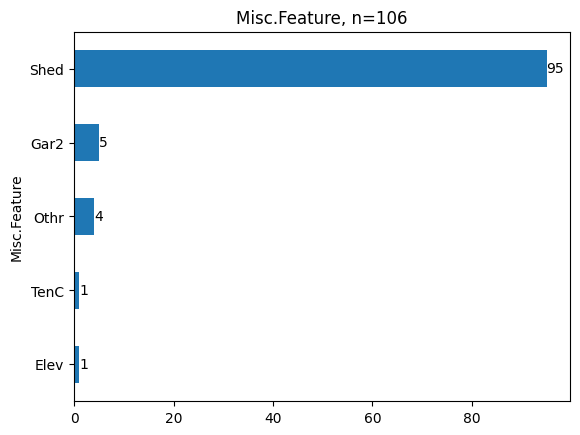

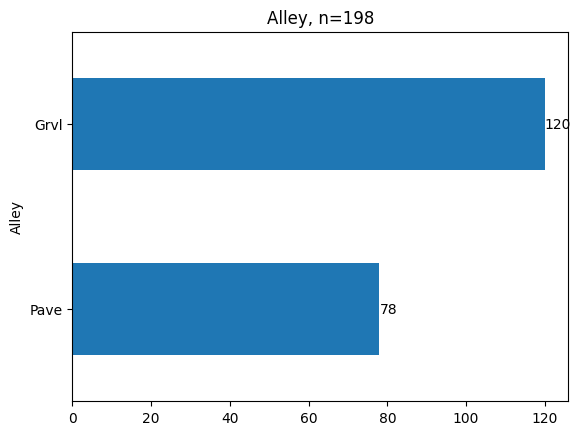

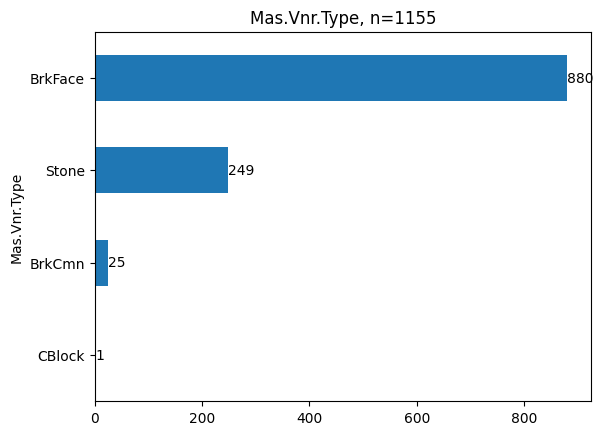

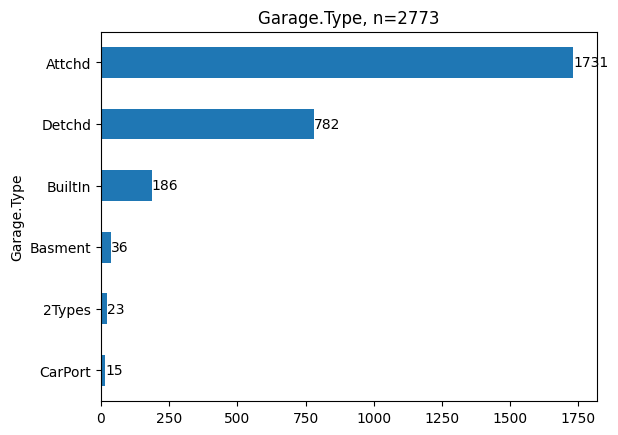

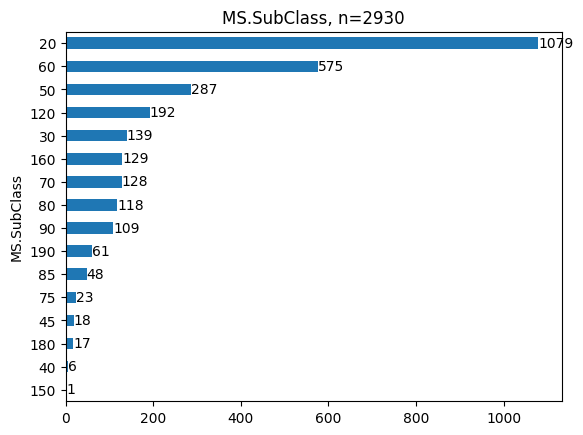

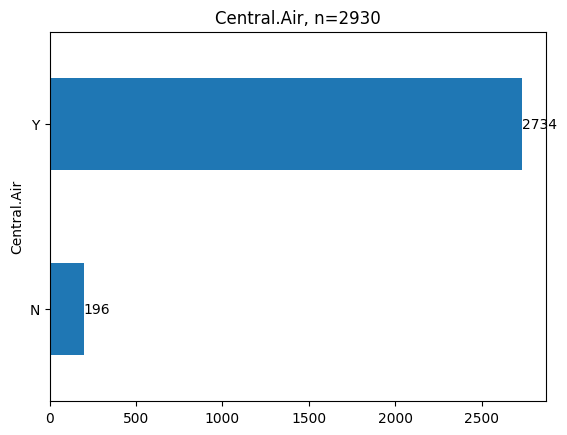

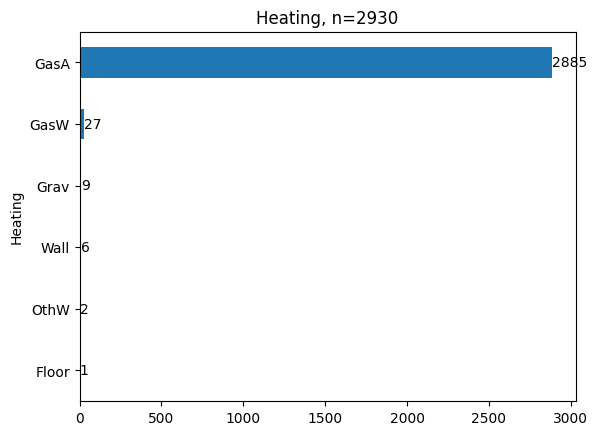

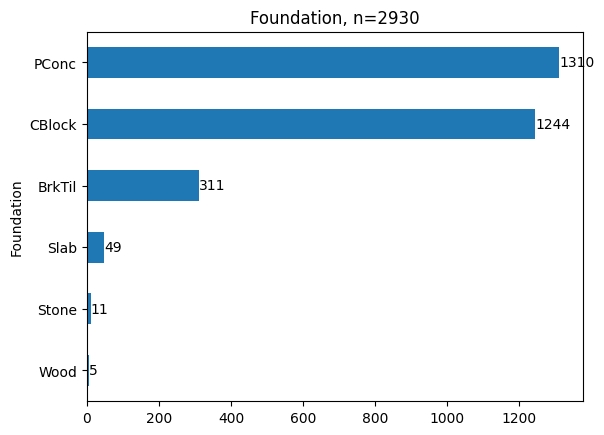

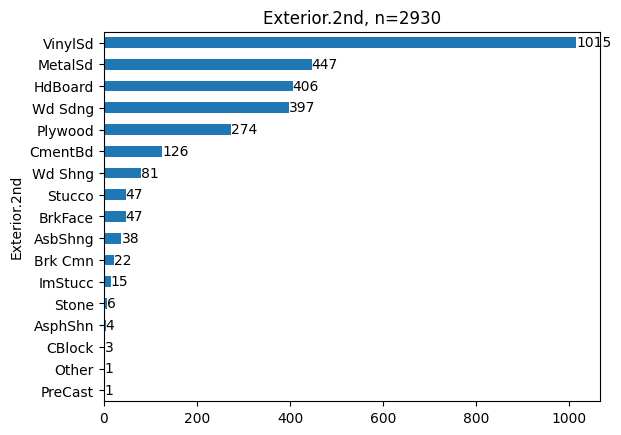

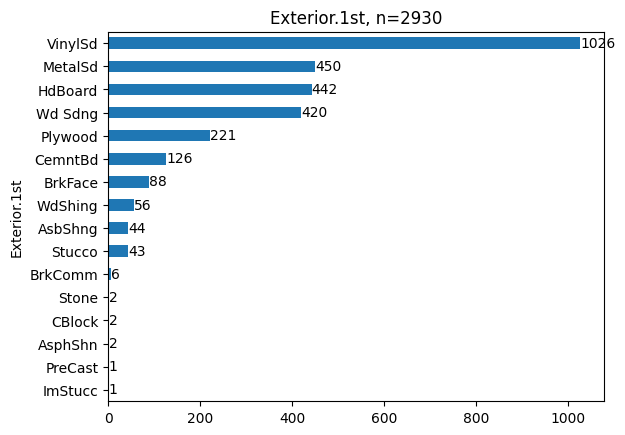

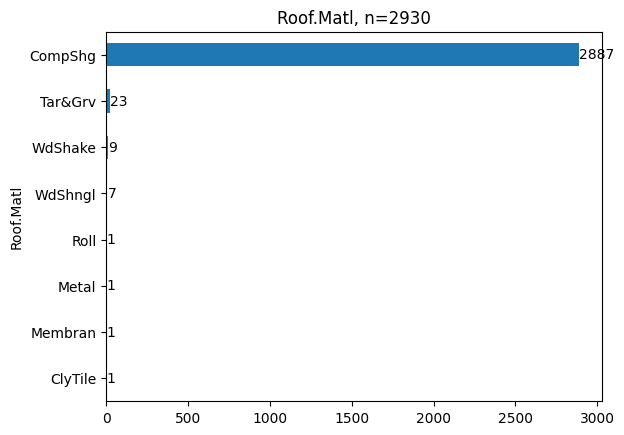

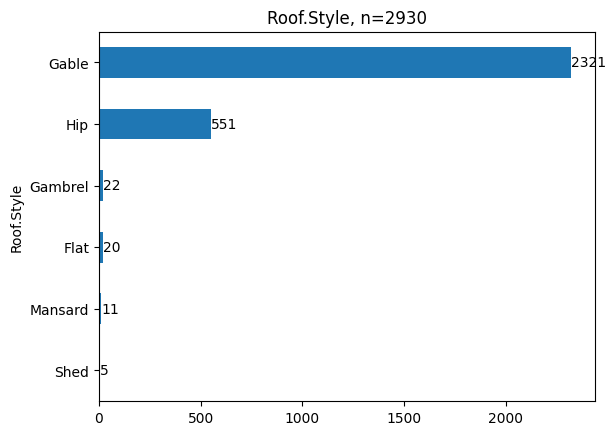

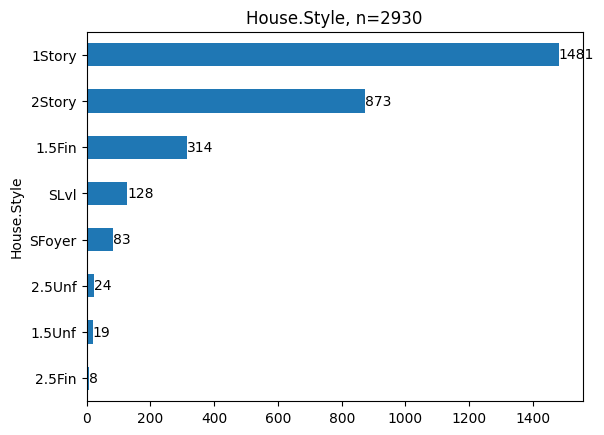

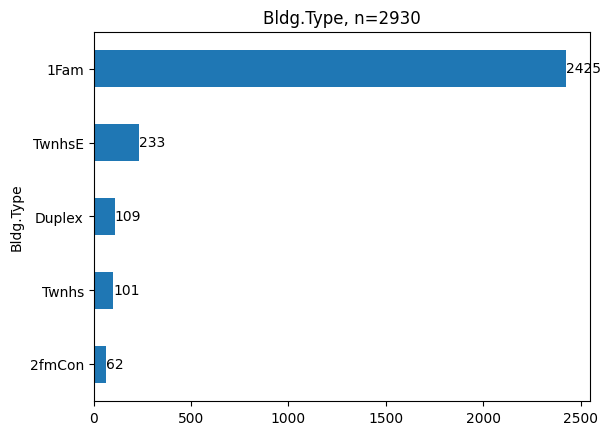

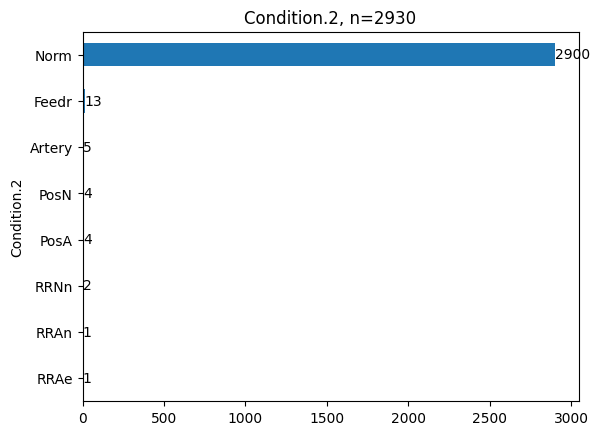

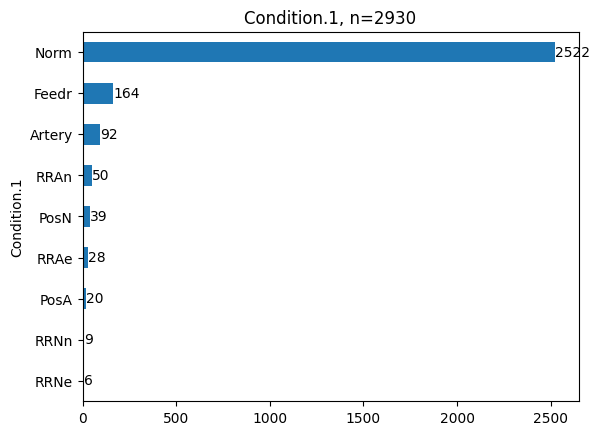

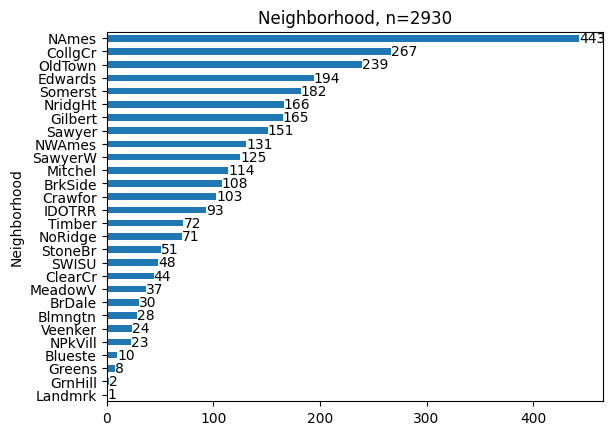

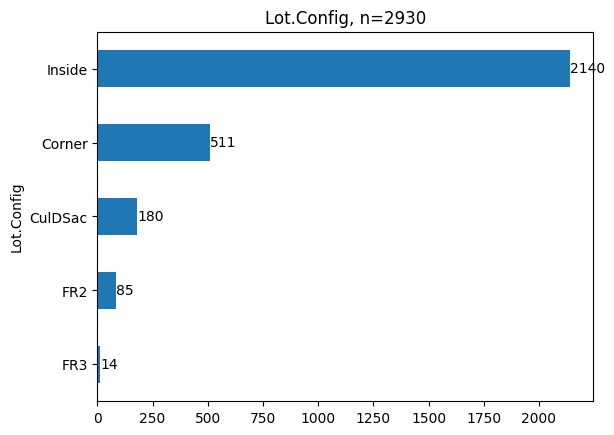

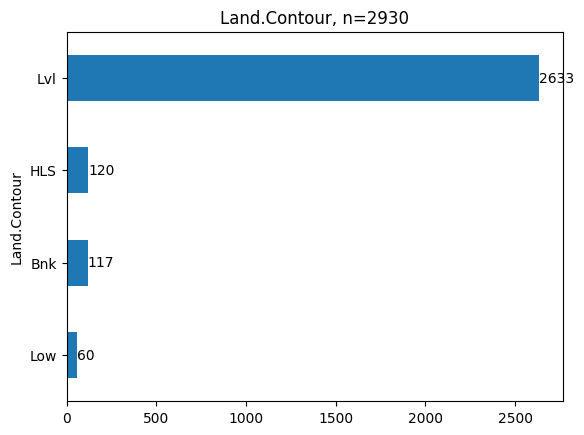

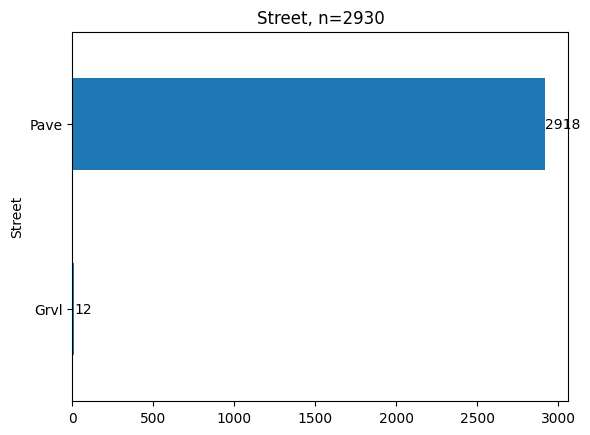

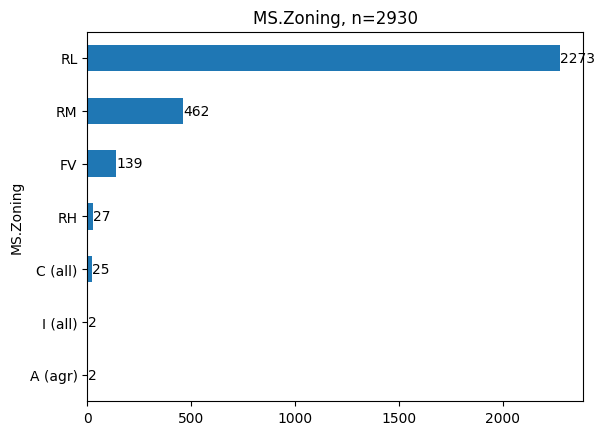

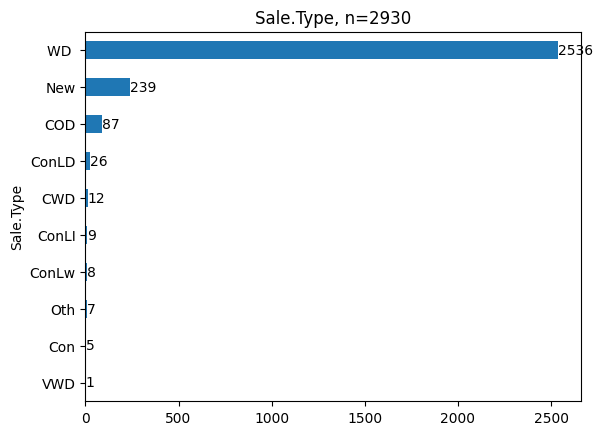

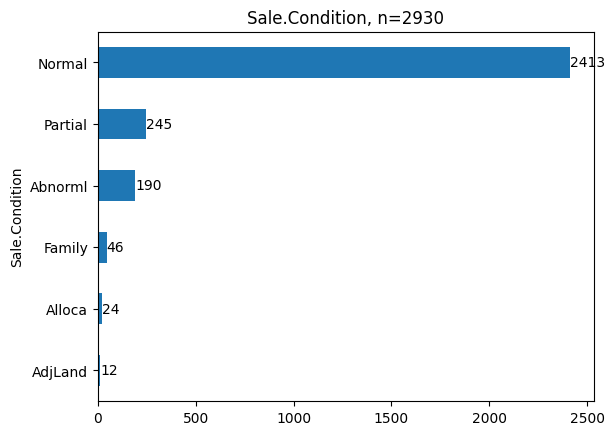

In [327]:
plot_categoricals(data, categorical_variables)

It is important to notice:

- There are variables that have many categories with little representation. 
    - It may be interesting to remove the minor categories, and make a note that the model that we are developing is not suitable to process houses of these categories. 
    - Or we may decide to ignore columns of this nature altogether.
    - A third option is to group the minor categories into a new category named `Other`, to indicate that we are not ignoring these properties, but we don't have enough evidence to infer the effect of the precise minor categories into the sale price.
- Some variables contain a great number of missing values. 
    - It may be better to drop those columns,
    - or to assign all missing values to a newly created `Unknown` category



In order to simplify the data (CAREFUL: we may end up damaging the model here! If the future model is not performing well, it could be interesting to revisit these assumptions), we will process each variable, remove outliers, etc.

#### Residential zoning, sales types and conditions (`MS.Zoning`, `Sale.Type`, and `Sale.Condition`)

Lets concentrate first on residential sales types:

In [328]:
data['MS.Zoning'].unique()

['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)']
Categories (7, object): ['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM']

In [329]:
data['MS.Zoning'].value_counts()

MS.Zoning
RL         2273
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: count, dtype: int64

We observe that a small number of sales are for non-residential properties, namely the categories `C (all)`, `A (agr)`, and `I (all)`. Let's remove them.

In [330]:
selection = ~(data['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
selection.value_counts()

MS.Zoning
True     2901
False      29
Name: count, dtype: int64

So far, so good.

In [331]:
data = data[selection]

After removing those undesired rows, lets remove the unused categories

In [332]:
data['MS.Zoning'] = data['MS.Zoning'].cat.remove_unused_categories()

In [333]:
data['MS.Zoning'].value_counts()

MS.Zoning
RL    2273
RM     462
FV     139
RH      27
Name: count, dtype: int64

Lets analyze the types of sale and condition. The documentation states:

```
Sale Type (Nominal): Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
Sale Condition (Nominal): Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
```

Lets look at the representation of each category in the dataset.

In [334]:
data['Sale.Type'].value_counts()

Sale.Type
WD       2513
New       239
COD        85
ConLD      22
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64

In [335]:
data['Sale.Type'].unique()

['WD ', 'New', 'COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw', 'CWD', 'VWD']
Categories (10, object): ['COD', 'CWD', 'Con', 'ConLD', ..., 'New', 'Oth', 'VWD', 'WD ']

*AHA!* Careful with the name of the categories! The category `"WD "` has a space in it! Too many hours were spent debugging this kind of thing.

In [336]:
data['Sale.Condition'].value_counts()

Sale.Condition
Normal     2397
Partial     245
Abnorml     179
Family       46
Alloca       22
AdjLand      12
Name: count, dtype: int64

Upon careful analysis, looks like all types of sales and conditions are valid. But we need to be careful with the low representativity of some categories in both `Sale.Type` and `Sale.Condition`. Let's do some category reassigning:

- All warranty deed types will go into a `GroupedWD` category;
- Category `New` stays as-is.
- All the remaining minor categories go into an `Other` category.

In [337]:
processed_data = data.copy()

In [338]:
def remap_categories(
    series: pd.Series,
    old_categories: tuple[str],
    new_category: str,
) -> pd.Series:
    # Add the new category to the list of valid categories.
    series = series.cat.add_categories(new_category)

    # Set all items of the old categories as the new category.
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category

    # Clean up the list of categories, the old categories no longer exist.
    series = series.cat.remove_unused_categories()

    return series

In [339]:
processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('WD ', 'CWD', 'VWD'),
    new_category='GroupedWD',
)

processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
    new_category='Other',
)

In [340]:
processed_data['Sale.Type'].value_counts()

Sale.Type
GroupedWD    2526
New           239
Other         136
Name: count, dtype: int64

Much better!

In [341]:
data = processed_data

#### Street paving (`Street`)

Now lets focus on street paving (`Street`):

In [342]:
data['Street'].value_counts()

Street
Pave    2895
Grvl       6
Name: count, dtype: int64

The very low representativity of the minor class `Grvl` forces us to ignore this column altogether:

In [343]:
data = data.drop(columns='Street')

#### House surroundings (`Condition.1` and `Condition.2`)

Let's check for conditions (`Condition.1` and `Condition.2`) pertaining to the house surroundings:

In [344]:
data['Condition.1'].value_counts()

Condition.1
Norm      2500
Feedr      158
Artery      91
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: count, dtype: int64

In [345]:
data['Condition.2'].value_counts()

Condition.2
Norm      2872
Feedr       12
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: count, dtype: int64

In [346]:
pd.crosstab(data['Condition.1'], data['Condition.2'])

Condition.2  Artery  Feedr  Norm  PosA  PosN  RRAe  RRAn  RRNn
Condition.1                                                   
Artery            2      0    88     1     0     0     0     0
Feedr             1      3   150     0     0     1     1     2
Norm              0      0  2500     0     0     0     0     0
PosA              0      0    17     3     0     0     0     0
PosN              0      0    35     0     4     0     0     0
RRAe              0      0    28     0     0     0     0     0
RRAn              1      8    41     0     0     0     0     0
RRNe              0      0     6     0     0     0     0     0
RRNn              1      1     7     0     0     0     0     0

Again, we observe very low representation of the minor classes. Lets reassign some categories to group similar features:

- The railroad proximity categories (`RRAn`, `RRAe`, `RRNn`, and `RRNe`) will go into a single `Railroad` category;
- The `Feedr` and `Artery` categories refer to larger streets that collect traffic from local streets and connect neighborhoods (e.g. large avenues), lets place them into a `Roads` category;
- The `PosA` and `PosN` refer to positive features adjacent or nearby the building, lets place them into a `Positive` category.

In [347]:
processed_data = data.copy()

In [348]:
for col in ('Condition.1', 'Condition.2'):
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
        new_category='Railroad',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('Feedr', 'Artery'),
        new_category='Roads',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('PosA', 'PosN'),
        new_category='Positive',
    )

In [349]:
processed_data['Condition.1'].value_counts()

Condition.1
Norm        2500
Roads        249
Railroad      93
Positive      59
Name: count, dtype: int64

In [350]:
processed_data['Condition.2'].value_counts()

Condition.2
Norm        2872
Roads         17
Positive       8
Railroad       4
Name: count, dtype: int64

In [351]:
pd.crosstab(processed_data['Condition.1'], processed_data['Condition.2'])

Condition.2  Norm  Railroad  Roads  Positive
Condition.1                                 
Norm         2500         0      0         0
Railroad       82         0     11         0
Roads         238         4      6         1
Positive       52         0      0         7

Looks like we can recombine the `Condition.1` and `Condition.2` columns into a single categorical column with the categories:

- `Norm`: `Condition.1` is `Norm`;
- `Railroad`: `Condition.1` is `Railroad` and `Condition.2` is `Norm`;
- `Roads`: `Condition.1` is `Roads` and `Condition.2` is not `Railroad`;
- `Positive`: `Condition.1` is `Positive`;
- `RoadsAndRailroad`: (`Condition.1` is `Railroad` and `Condition.2` is `Roads`) or (`Condition.1` is `Roads` and `Condition.2` is `Railroad`).

In [352]:
processed_data['Condition'] = pd.Series(
    index=processed_data.index,
    dtype=pd.CategoricalDtype(categories=(
        'Norm',
        'Railroad',
        'Roads',
        'Positive',
        'RoadsAndRailroad',
    )),
)

In [353]:
norm_items = processed_data['Condition.1'] == 'Norm'
processed_data['Condition'][norm_items] = 'Norm'

In [354]:
railroad_items = \
    (processed_data['Condition.1'] == 'Railroad') \
    & (processed_data['Condition.2'] == 'Norm')
processed_data['Condition'][railroad_items] = 'Railroad'

In [355]:
roads_items = \
    (processed_data['Condition.1'] == 'Roads') \
    & (processed_data['Condition.2'] != 'Railroad')
processed_data['Condition'][roads_items] = 'Roads'

In [356]:
positive_items = processed_data['Condition.1'] == 'Positive'
processed_data['Condition'][positive_items] = 'Positive'

In [357]:
roads_and_railroad_items = \
    ( \
        (processed_data['Condition.1'] == 'Railroad') \
        & (processed_data['Condition.2'] == 'Roads')
    ) \
    | ( \
        (processed_data['Condition.1'] == 'Roads') \
        & (processed_data['Condition.2'] == 'Railroad') \
    )
processed_data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'

In [358]:
processed_data['Condition'].value_counts()

Condition
Norm                2500
Roads                245
Railroad              82
Positive              59
RoadsAndRailroad      15
Name: count, dtype: int64

There is no apparent need, for now, to go into further simplification of this variable. Lets drop the original variables:

In [359]:
processed_data = processed_data.drop(columns=['Condition.1', 'Condition.2'])

In [360]:
data = processed_data

#### Columns with many missing values (`Misc.Feature` and `Alley`)

The columns `Misc.Feature` and `Alley` are mostly formed by missing values!

             count unique   top freq
Misc.Feature   104      5  Shed   93
Alley          195      2  Grvl  119


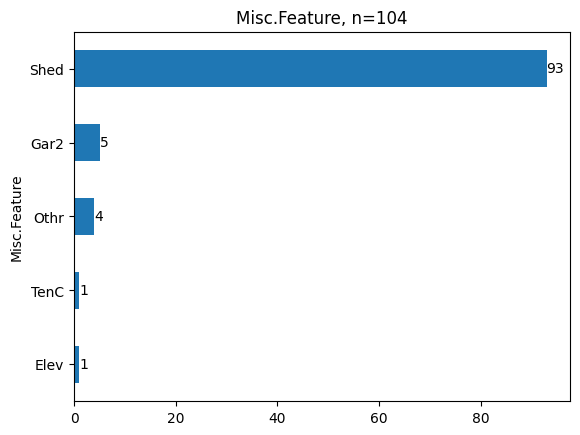

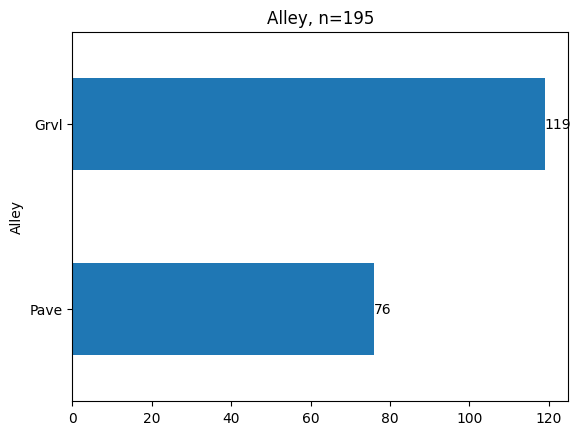

In [361]:
plot_categoricals(data, ['Misc.Feature', 'Alley'])

But it looks like we can reuse this information, still. We can transform the `Misc.Feature` variable into a `HasShed` variable that indicates whether the house has a shed:

In [362]:
data['HasShed'] = data['Misc.Feature'] == 'Shed'
data = data.drop(columns='Misc.Feature')

In [363]:
data['HasShed'].value_counts()

HasShed
False    2808
True       93
Name: count, dtype: int64

Likewise, we can mutate the `Alley` feature into a `HasAlley` feature:

In [364]:
data['HasAlley'] = ~data['Alley'].isna()
data = data.drop(columns='Alley')

In [365]:
data['HasAlley'].value_counts()

HasAlley
False    2706
True      195
Name: count, dtype: int64

#### Exterior coverings (`Exterior.1st` and `Exterior.2nd`)

The exterior coverings have a lot of categories, some with very low representativity:

             count unique      top  freq
Exterior.1st  2901     16  VinylSd  1025
Exterior.2nd  2901     17  VinylSd  1012


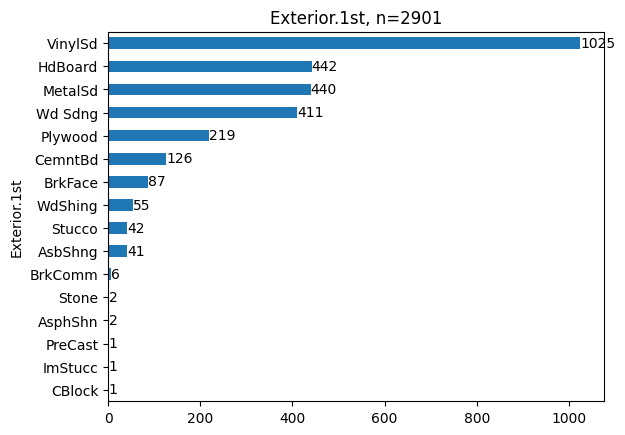

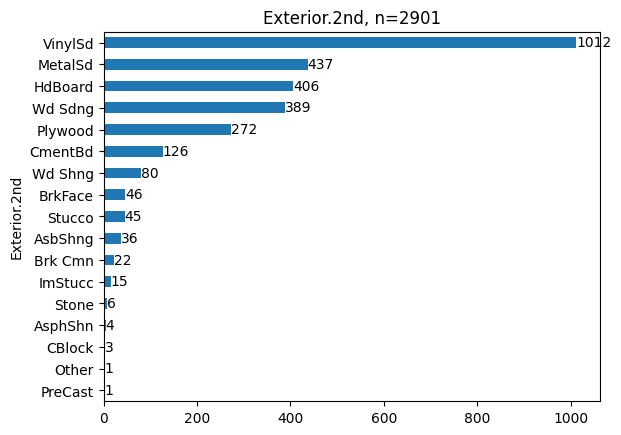

In [366]:
plot_categoricals(data, ['Exterior.1st', 'Exterior.2nd'])

Also, it looks like there are a few typos!


| `Exterior.1st` | `Exterior.2nd` | `Correct value` |
|----------------|----------------|-----------------|
| `BrkComm`      | `Brk Cmn`      | `BrkComm`       |
| `CemntBd`      | `CmentBd`      | `CemntBd`       |
| `WdShing`      | `Wd Shng`      | `WdShing`       |

Lets fix those

In [367]:
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Brk Cmn', ),
    new_category='BrkComm',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('CmentBd', ),
    new_category='CemntBd',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Wd Shng', ),
    new_category='WdShing',
)


In [368]:
for col in ('Exterior.1st', 'Exterior.2nd'):
    categories = data[col].cat.categories
    data[col] = data[col].cat.reorder_categories(sorted(categories))

In [369]:
pd.crosstab(data['Exterior.1st'], data['Exterior.2nd'])

Exterior.2nd  AsbShng  AsphShn  BrkComm  BrkFace  CBlock  CemntBd  HdBoard  \
Exterior.1st                                                                 
AsbShng            33        0        0        0       0        1        0   
AsphShn             0        2        0        0       0        0        0   
BrkComm             0        0        4        0       0        0        0   
BrkFace             1        0        0       43       0        0        3   
CBlock              0        0        0        0       1        0        0   
CemntBd             0        0        0        0       0      124        0   
HdBoard             0        1        0        1       0        0      383   
ImStucc             0        0        0        0       0        0        0   
MetalSd             0        1        0        0       1        0        3   
Plywood             0        0       18        0       1        0        6   
PreCast             0        0        0        0       0        0        0   
Stone               0        0        0        0       0        0        1   
Stucco              0        0        0        1       0        1        0   
VinylSd             1        0        0        0       0        0        1   
Wd Sdng             1        0        0        1       0        0        7   
WdShing             0        0        0        0       0        0        2   

Exterior.2nd  ImStucc  MetalSd  Other  Plywood  PreCast  Stone  Stucco  \
Exterior.1st                                                             
AsbShng             0        0      0        5        0      0       1   
AsphShn             0        0      0        0        0      0       0   
BrkComm             0        0      0        0        0      0       1   
BrkFace             0        3      0        8        0      3       3   
CBlock              0        0      0        0        0      0       0   
CemntBd             0        0      0        0        0      0       0   
HdBoard             6        1      0       41        0      0       1   
ImStucc             1        0      0        0        0      0       0   
MetalSd             0      427      0        0        0      0       3   
Plywood             4        0      0      184        0      0       0   
PreCast             0        0      0        0        1      0       0   
Stone               0        0      0        0        0      1       0   
Stucco              0        0      0        1        0      1      32   
VinylSd             1        2      1        2        0      0       1   
Wd Sdng             3        4      0       21        0      1       2   
WdShing             0        0      0       10        0      0       1   

Exterior.2nd  VinylSd  Wd Sdng  WdShing  
Exterior.1st                             
AsbShng             0        1        0  
AsphShn             0        0        0  
BrkComm             0        1        0  
BrkFace             1       21        1  
CBlock              0        0        0  
CemntBd             0        1        1  
HdBoard             0        3        5  
ImStucc             0        0        0  
MetalSd             2        2        1  
Plywood             1        4        1  
PreCast             0        0        0  
Stone               0        0        0  
Stucco              0        2        4  
VinylSd          1005        2        9  
Wd Sdng             3      350       18  
WdShing             0        2       40

It looks like there are a few popular options and lots of poorly represented materials beyond the popular ones. Due to lack of representativity, lets keep only the popular categories as-is, and group the rest into an `Other` category.

Also, looks like it is often the case that the first material is the same as the second material, probably to indicate that the house exterior contains only one material. Therefore, we will keep only the `Exterior.1st` variable.

In [370]:
processed_data = data.copy()

In [371]:
mat_count = processed_data['Exterior.1st'].value_counts()
mat_count

Exterior.1st
VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
BrkComm       6
AsphShn       2
Stone         2
CBlock        1
ImStucc       1
PreCast       1
Name: count, dtype: int64

In [372]:
rare_materials = list(mat_count[mat_count < 40].index)
rare_materials

['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'PreCast']

In [373]:
processed_data['Exterior'] = remap_categories(
    series=processed_data['Exterior.1st'],
    old_categories=rare_materials,
    new_category='Other',
)
processed_data = processed_data.drop(columns=['Exterior.1st', 'Exterior.2nd'])

In [374]:
processed_data['Exterior'].value_counts()

Exterior
VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
Other        13
Name: count, dtype: int64

In [375]:
data = processed_data

#### `Heating`

        count unique   top  freq
Heating  2901      6  GasA  2859


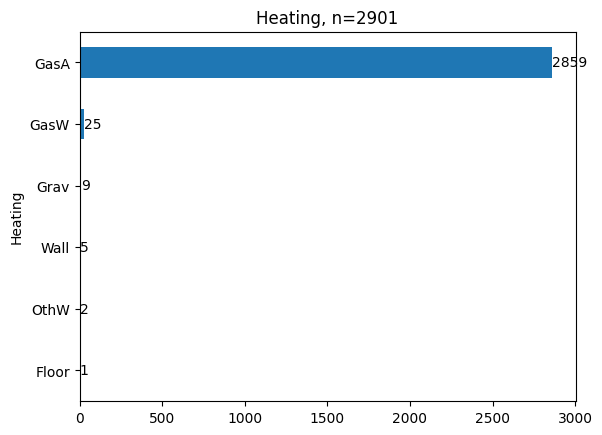

In [376]:
plot_categoricals(data, ['Heating',])

This column does not have missing values, and an overwhelming amount of items belong to the same category. As such, there is not much information here, lets discard the column.

In [377]:
data = data.drop(columns='Heating')

#### `Roof.Matl` and `Roof.Style`

           count unique      top  freq
Roof.Matl   2901      8  CompShg  2858
Roof.Style  2901      6    Gable  2301


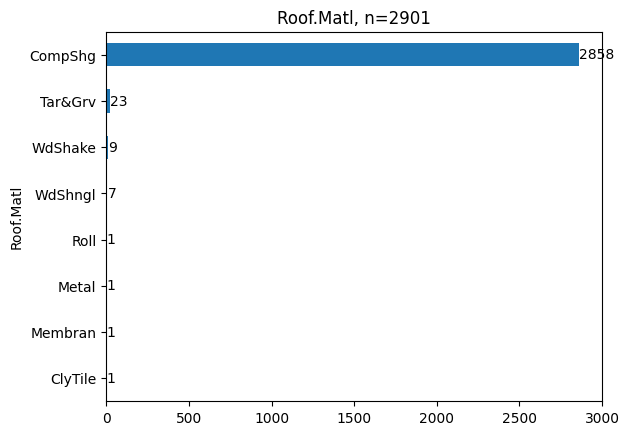

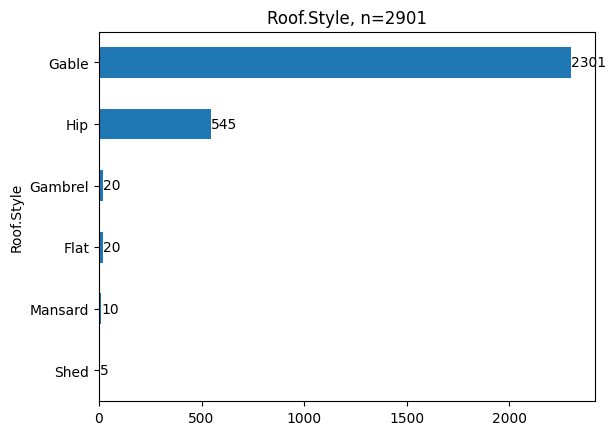

In [378]:
plot_categoricals(data, ['Roof.Matl', 'Roof.Style'])

Due to the low representativity of the minor categories in the `Roof.Matl` feature, we will drop it.

In [379]:
data = data.drop(columns='Roof.Matl')

In the `Roof.Style` feature we have two substantial categories, and a few very minor ones. Lets group the minor categories into an `Other` category:

In [380]:
data['Roof.Style'] = remap_categories(
    series=data['Roof.Style'],
    old_categories=[
        'Flat',
        'Gambrel',
        'Mansard',
        'Shed',
    ],
    new_category='Other',
)

In [381]:
data['Roof.Style'].value_counts()

Roof.Style
Gable    2301
Hip       545
Other      55
Name: count, dtype: int64

#### `Mas.Vnr.Type`

In [382]:
data['Mas.Vnr.Type'].info()

<class 'pandas.core.series.Series'>
Index: 2901 entries, 0 to 2929
Series name: Mas.Vnr.Type
Non-Null Count  Dtype   
--------------  -----   
1155 non-null   category
dtypes: category(1)
memory usage: 25.7 KB


In [383]:
data['Mas.Vnr.Type'].value_counts()

Mas.Vnr.Type
BrkFace    880
Stone      249
BrkCmn      25
CBlock       1
Name: count, dtype: int64

Lets group the two minor classes into an `Other` class:

In [384]:
data['Mas.Vnr.Type'] = remap_categories(
    series=data['Mas.Vnr.Type'],
    old_categories=[
        'BrkCmn',
        'CBlock',
    ],
    new_category='Other',
)

Also, lets add the missing entries to the `None` category, since we have no evidence of the veneer type here.

In [385]:
data['Mas.Vnr.Type'] = data['Mas.Vnr.Type'].cat.add_categories('None')
data['Mas.Vnr.Type'][data['Mas.Vnr.Type'].isna()] = 'None'


In [386]:
data['Mas.Vnr.Type'].value_counts()

Mas.Vnr.Type
None       1746
BrkFace     880
Stone       249
Other        26
Name: count, dtype: int64

#### `MS.SubClass`

             count  unique  top  freq
MS.SubClass   2901      16   20  1074


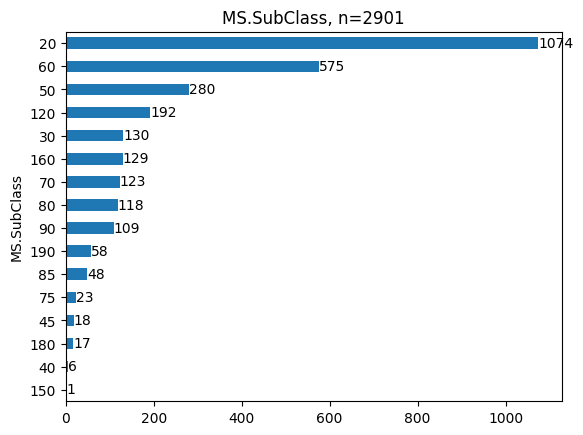

In [387]:
plot_categoricals(data, ['MS.SubClass'])

This is a complicated feature, lets look at the documentation:

```
MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.	

       020	1-STORY 1946 & NEWER ALL STYLES
       030	1-STORY 1945 & OLDER
       040	1-STORY W/FINISHED ATTIC ALL AGES
       045	1-1/2 STORY - UNFINISHED ALL AGES
       050	1-1/2 STORY FINISHED ALL AGES
       060	2-STORY 1946 & NEWER
       070	2-STORY 1945 & OLDER
       075	2-1/2 STORY ALL AGES
       080	SPLIT OR MULTI-LEVEL
       085	SPLIT FOYER
       090	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
```

This is the moment where you reach out to a real-estate agent and ask what is the meaning of these categories, and whether they can they be meaningfully grouped together. For now lets just reassign the minor categories to an `Other` category:

In [388]:
data['MS.SubClass'] = remap_categories(
    series=data['MS.SubClass'],
    old_categories=[75, 45, 180, 40, 150],
    new_category='Other',
)

In [389]:
data['MS.SubClass'].value_counts()

MS.SubClass
20       1074
60        575
50        280
120       192
30        130
160       129
70        123
80        118
90        109
Other      65
190        58
85         48
Name: count, dtype: int64

#### `Foundation`

           count unique    top  freq
Foundation  2901      6  PConc  1308


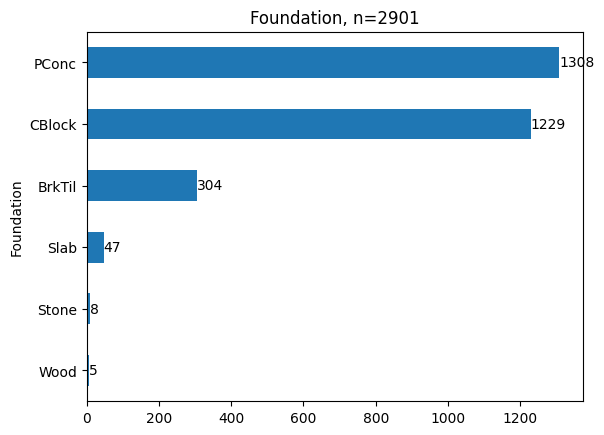

In [390]:
plot_categoricals(data, ['Foundation'])

Same story: minor categories grouped into an `Other` category.

In [391]:
data['Foundation'] = remap_categories(
    series=data['Foundation'],
    old_categories=['Slab', 'Stone', 'Wood'],
    new_category='Other',
)

#### `Neighborhood`

In [392]:
data['Neighborhood'].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    237
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    113
BrkSide    108
Crawfor    103
Timber      72
NoRidge     71
IDOTRR      68
StoneBr     51
SWISU       47
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

We can either group the minor categories into an `Other` category, or drop the rows. Both approaches have their pros and cons:

- If we delete the rows we are being more precise, in the sense that we restrict our model to fewer neighborhoods.
- If we mantain the rows we have more data to construct the model.

Lets drop the rows and make a note that this model does not work for those neighborhoods.

In [393]:
selection = ~data['Neighborhood'].isin([
    'Blueste',
    'Greens',
    'GrnHill',
    'Landmrk',
])
data = data[selection]

In [394]:
data['Neighborhood'] = data['Neighborhood'].cat.remove_unused_categories()

In [395]:
data['Neighborhood'].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    237
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    113
BrkSide    108
Crawfor    103
Timber      72
NoRidge     71
IDOTRR      68
StoneBr     51
SWISU       47
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Name: count, dtype: int64

#### `Garage.Type`

In [396]:
data['Garage.Type'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Garage.Type
Non-Null Count  Dtype   
--------------  -----   
2733 non-null   category
dtypes: category(1)
memory usage: 25.5 KB


In [397]:
data['Garage.Type'].value_counts()

Garage.Type
Attchd     1714
Detchd      761
BuiltIn     186
Basment      35
2Types       23
CarPort      14
Name: count, dtype: int64

Looks like there are a few residences that do not have a garage, lets create a `NoGarage` category for them.

In [398]:
data['Garage.Type'] = data['Garage.Type'].cat.add_categories(['NoGarage'])
data['Garage.Type'][data['Garage.Type'].isna()] = 'NoGarage'

In [399]:
data['Garage.Type'].value_counts()

Garage.Type
Attchd      1714
Detchd       761
BuiltIn      186
NoGarage     147
Basment       35
2Types        23
CarPort       14
Name: count, dtype: int64

### A final look at the categorical variables

After all of this processing, even the set of categorical variables has changed, so lets make a new list:

In [400]:
all_categorical = data.select_dtypes('category').columns

new_categorical_variables = [ \
    col for col in all_categorical \
    if not col in ordinal_variables \
]

               count unique        top  freq
MS.SubClass     2880     12         20  1074
MS.Zoning       2880      4         RL  2265
Land.Contour    2880      4        Lvl  2594
Lot.Config      2880      5     Inside  2103
Neighborhood    2880     24      NAmes   443
Bldg.Type       2880      5       1Fam  2399
House.Style     2880      8     1Story  1454
Roof.Style      2880      3      Gable  2280
Mas.Vnr.Type    2880      4       None  1726
Foundation      2880      4      PConc  1306
Central.Air     2880      2          Y  2702
Garage.Type     2880      7     Attchd  1714
Sale.Type       2880      3  GroupedWD  2506
Sale.Condition  2880      6     Normal  2376
Condition       2880      5       Norm  2479
Exterior        2880     11    VinylSd  1024


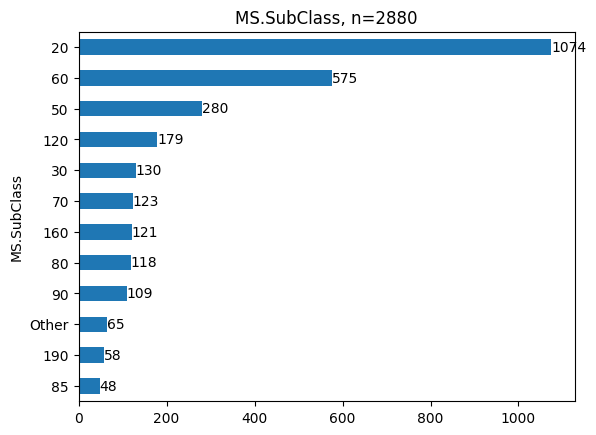

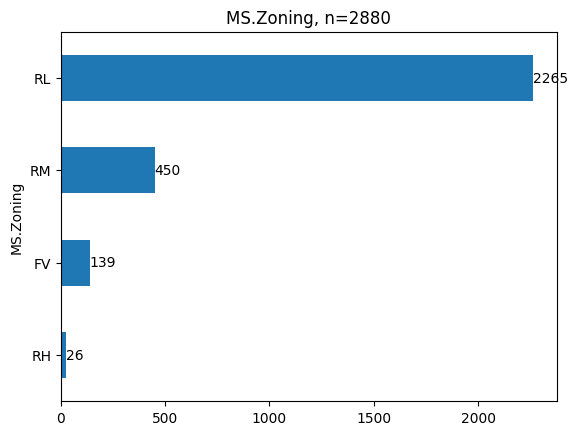

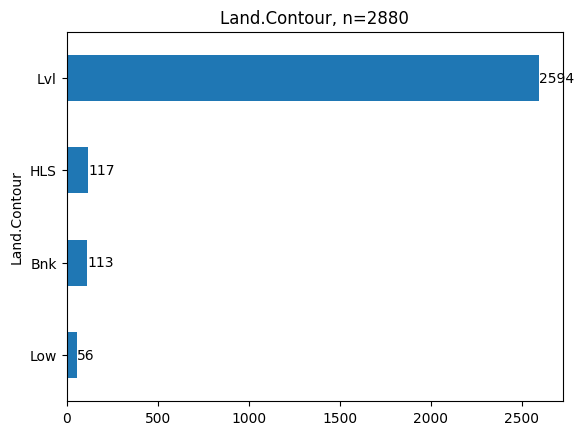

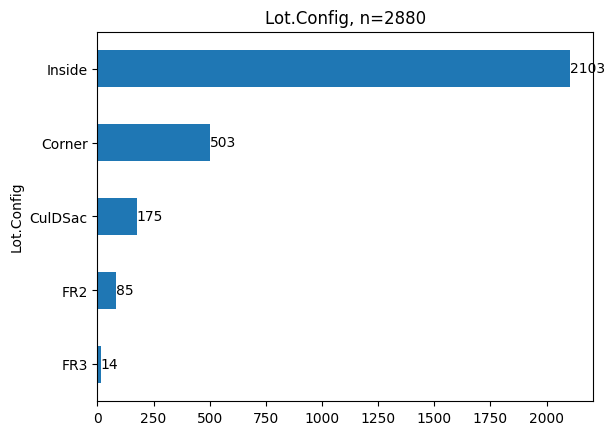

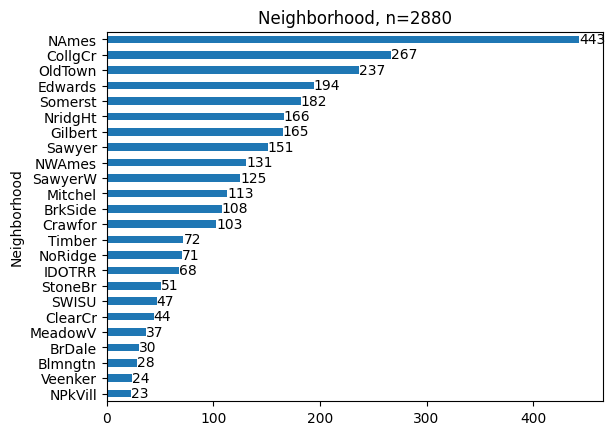

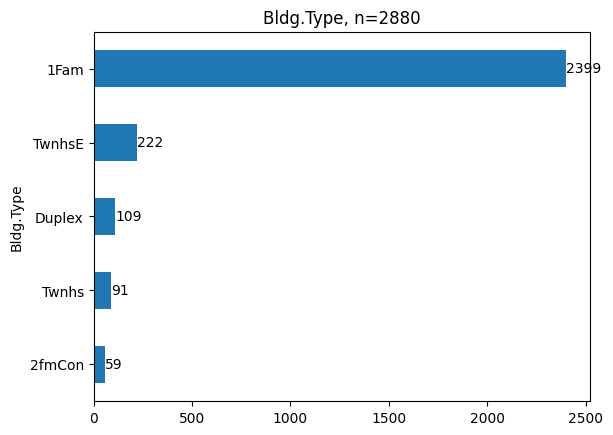

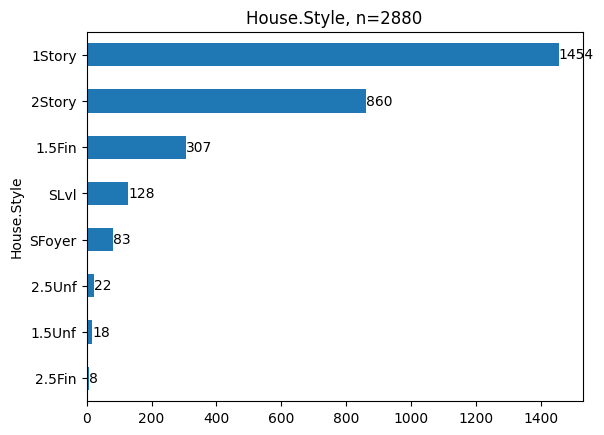

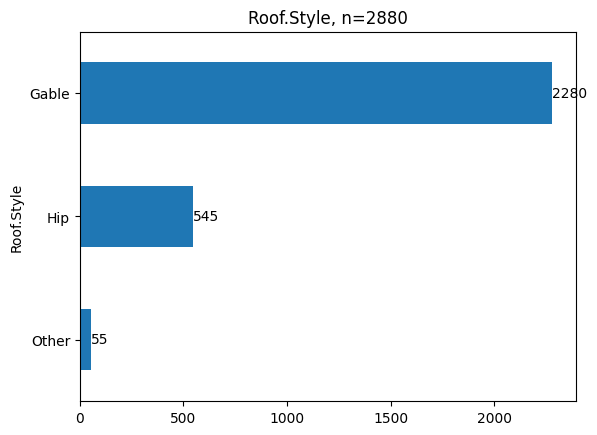

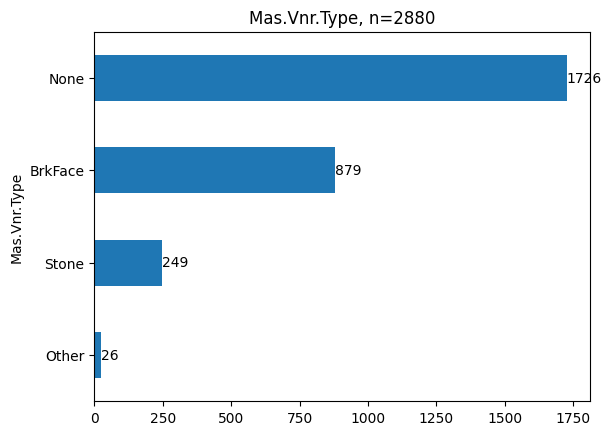

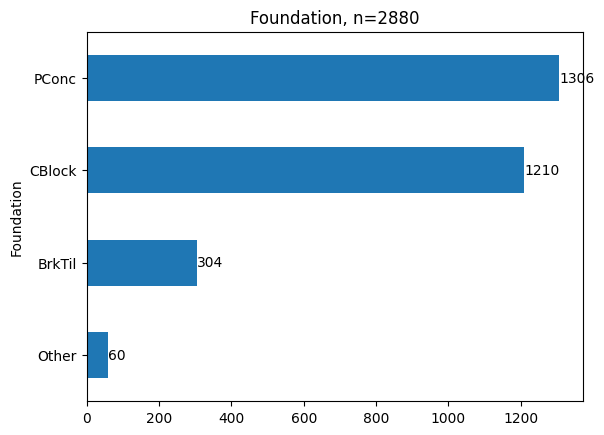

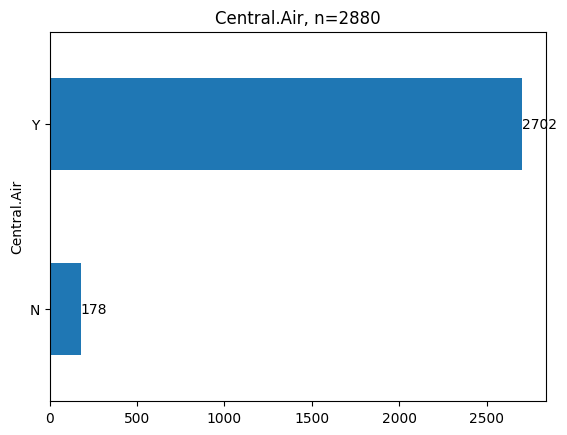

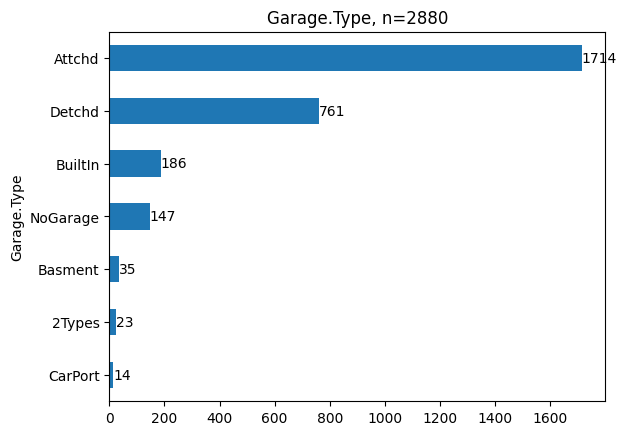

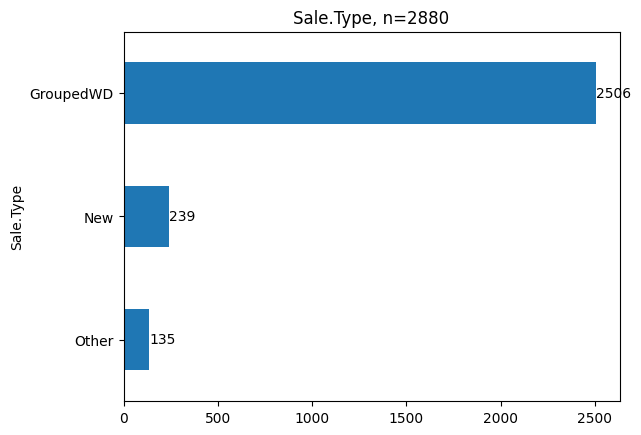

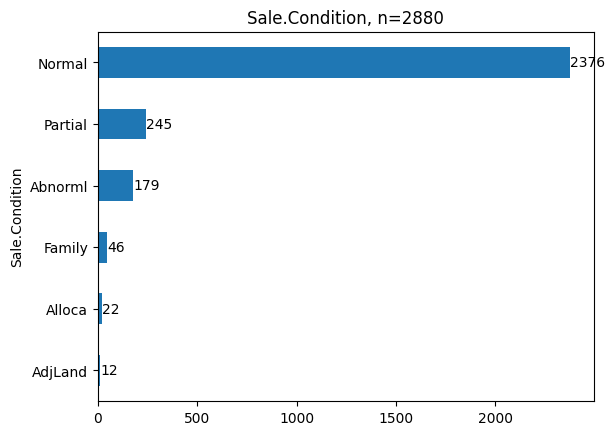

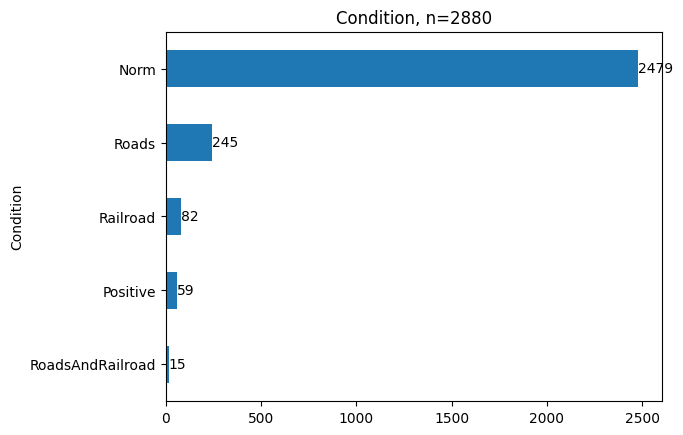

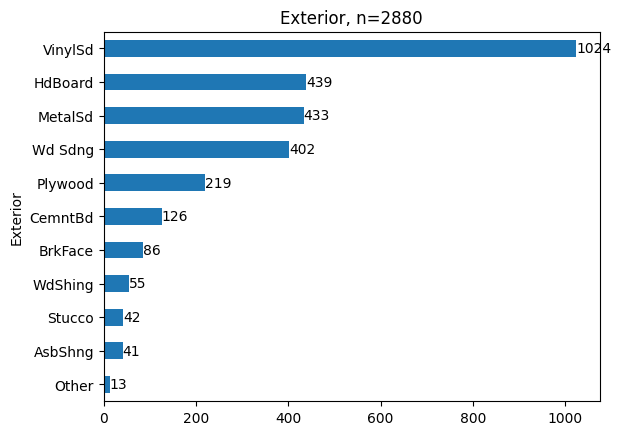

In [401]:
plot_categoricals(data, new_categorical_variables)

Looks like we are done with the categorical variables, yay! Notice that there are no more missing values among the categorical variables!

### Analyzing the ordinal variables

Lets take a first look:

               count unique     top  freq
Pool.QC           13      4      Ex     4
Fence            561      4   MnPrv   325
Fireplace.Qu    1488      5      Gd   742
Garage.Cond     2731      5      TA  2631
Garage.Qual     2731      5      TA  2580
Garage.Finish   2731      3     Unf  1210
Bsmt.Exposure   2802      4      No  1879
BsmtFin.Type.2  2804      6     Unf  2459
Bsmt.Cond       2805      5      TA  2577
BsmtFin.Type.1  2805      6     GLQ   843
Bsmt.Qual       2805      4      TA  1262
Electrical      2879      5   SBrkr  2643
Exter.Cond      2880      5      TA  2513
Exter.Qual      2880      4      TA  1770
Heating.QC      2880      5      Ex  1487
Kitchen.Qual    2880      5      TA  1462
Functional      2880      8     Typ  2685
Overall.Cond    2880      9       5  1638
Overall.Qual    2880     10       5   820
Land.Slope      2880      3     Gtl  2746
Utilities       2880      3  AllPub  2878
Paved.Drive     2880      3       Y  2623
Lot.Shape       2880      4     Re

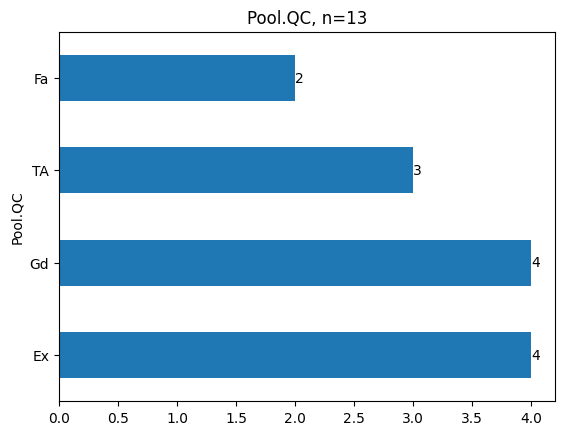

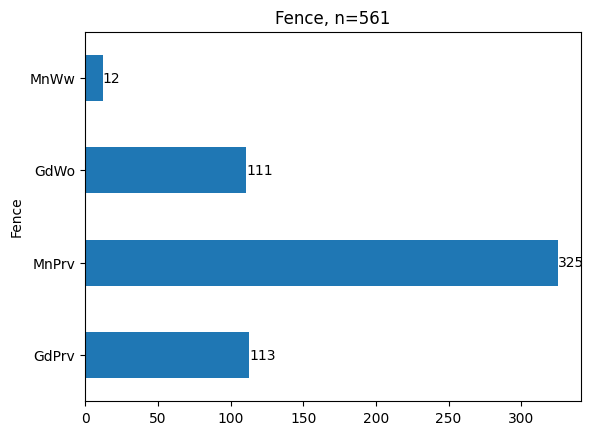

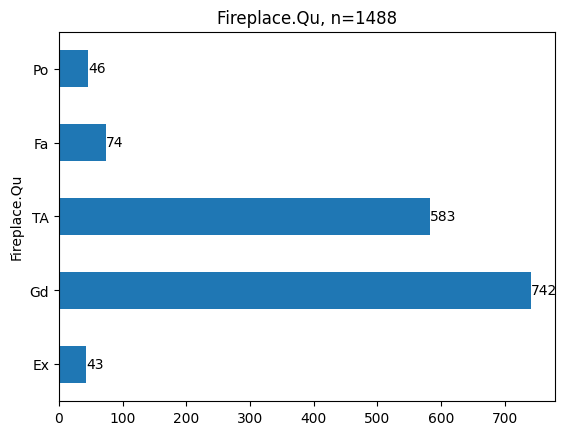

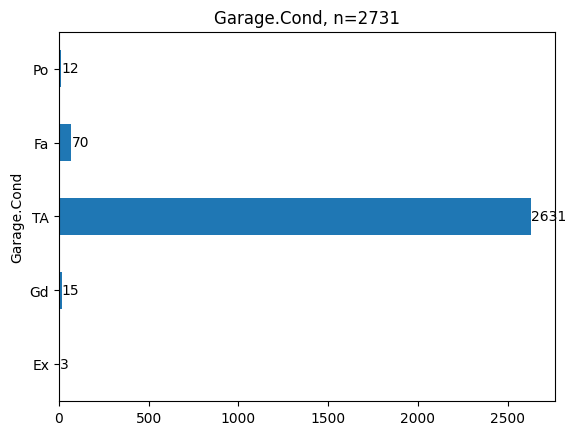

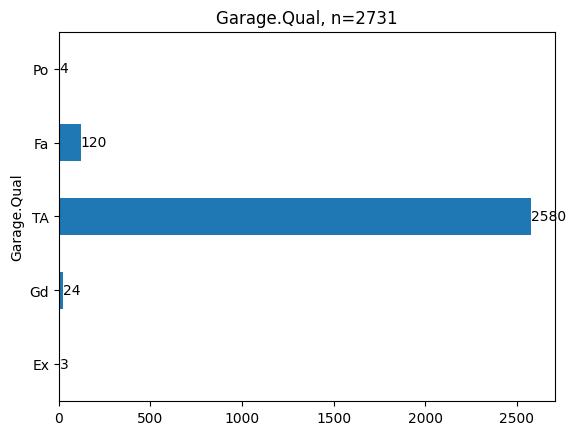

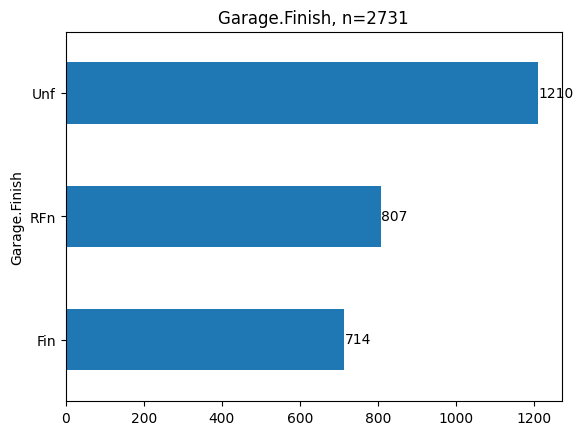

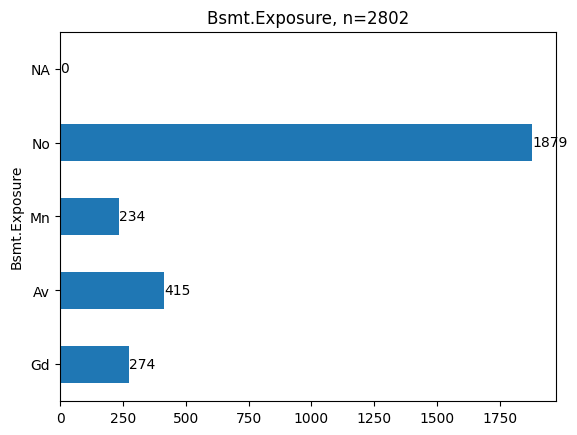

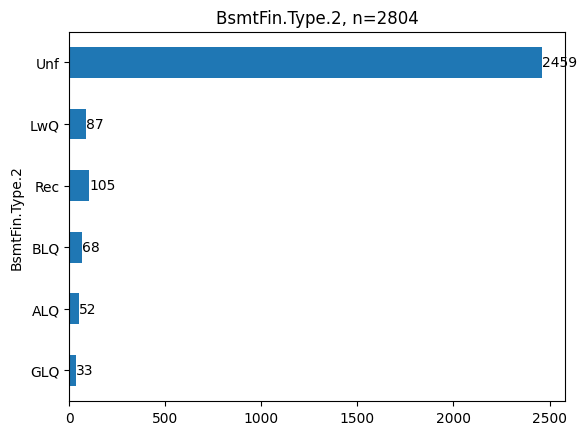

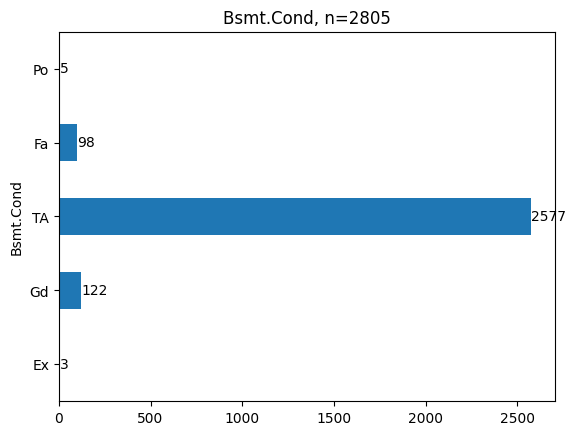

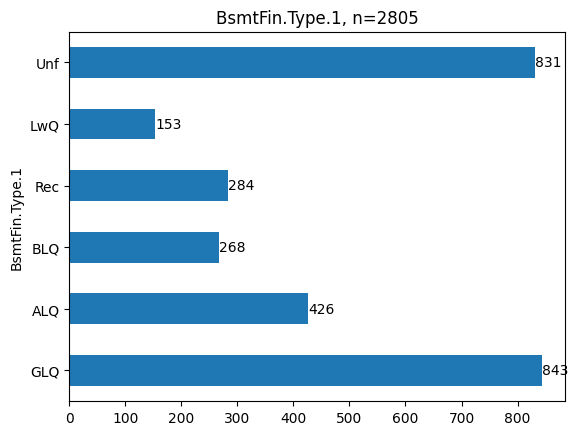

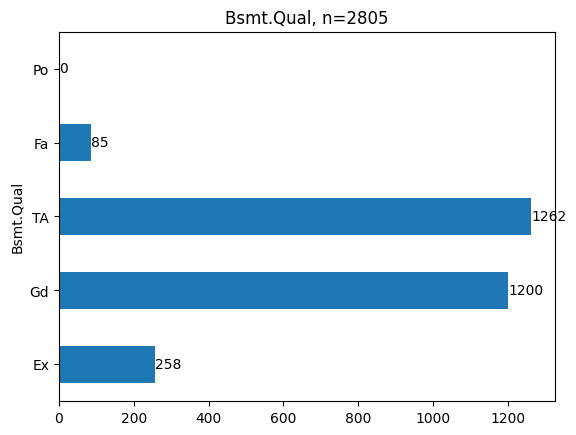

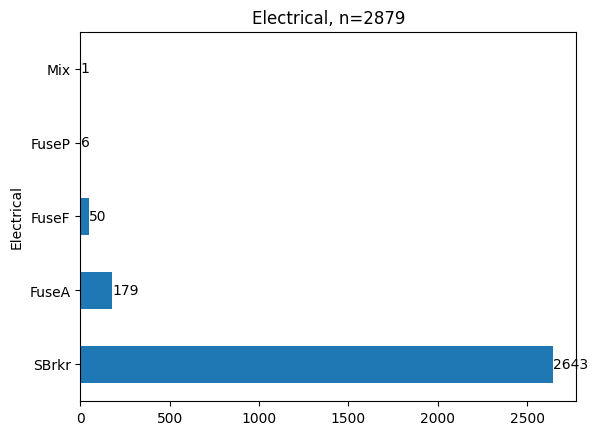

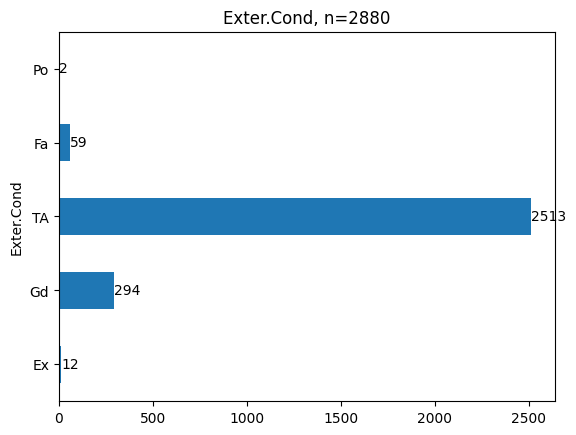

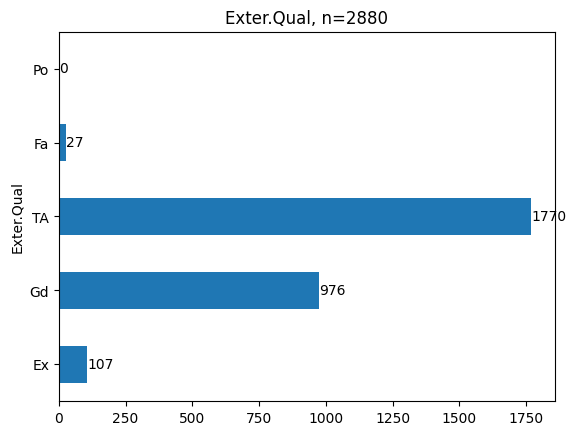

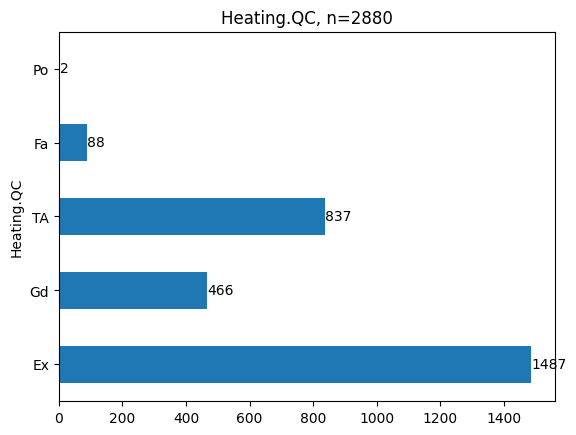

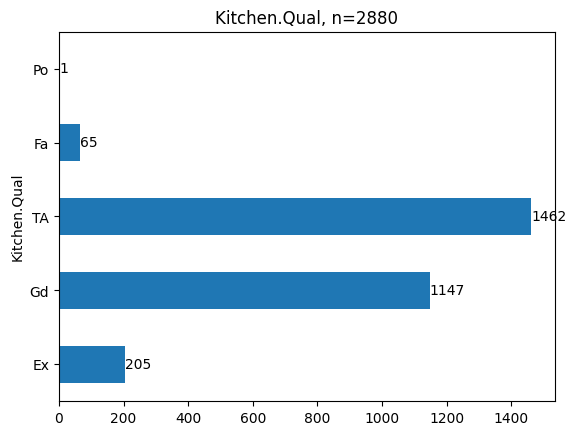

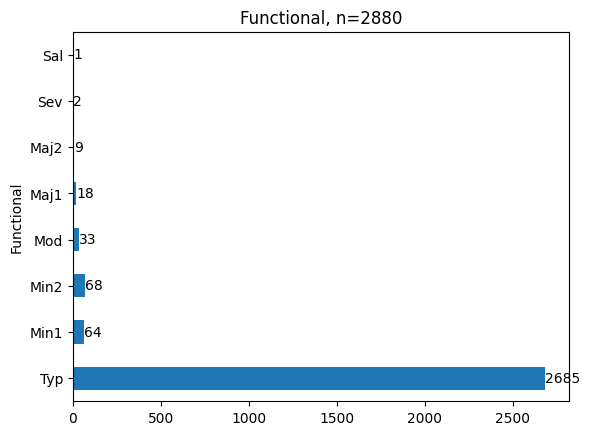

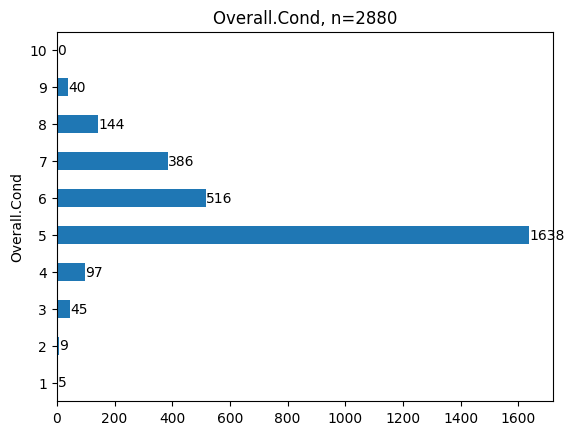

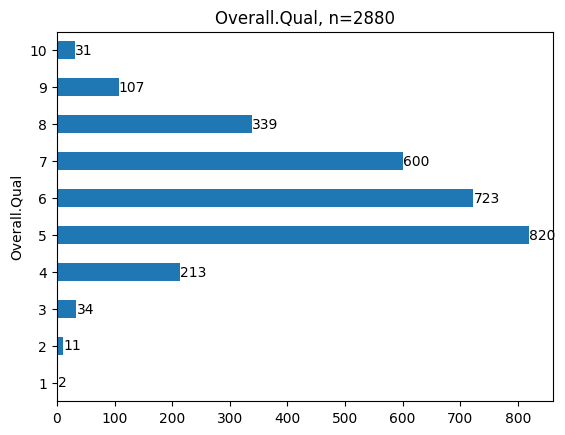

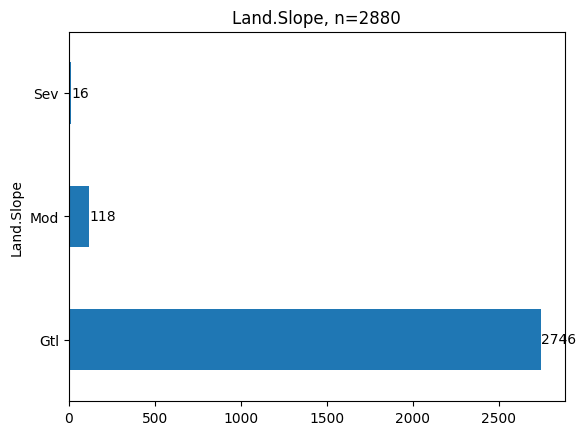

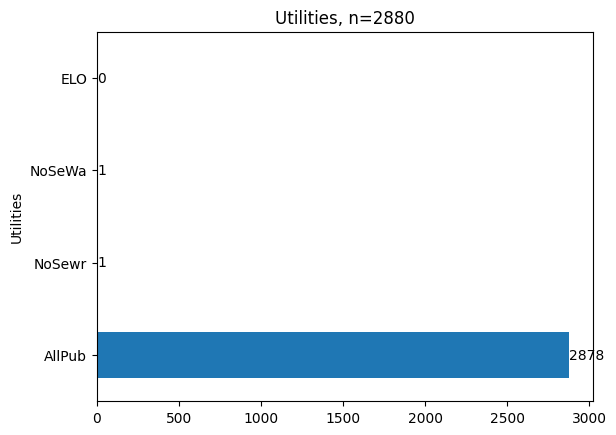

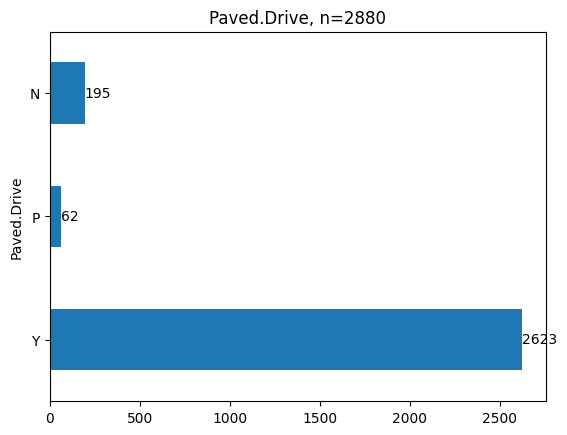

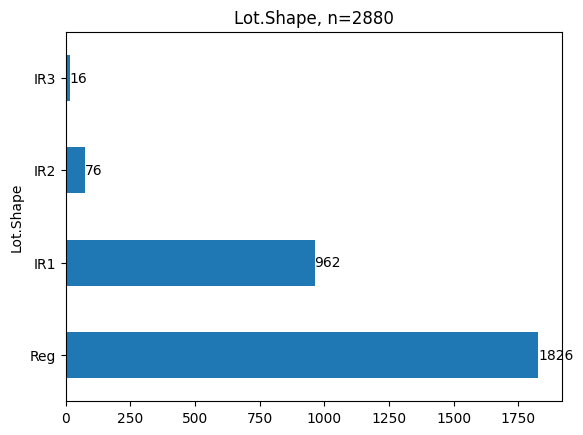

In [402]:
plot_categoricals(data, ordinal_variables, sorted=False)

Ouch! Again, we suffer from the existence of categories with very low representativity! But here, different from the nominal variables, we have a choice. If we model the ordinal variables as increaasing numbers (we'll do that when preparing the data for the model), than the low representativity of some categories is no longer a problem: it is just a number that does not occur often!

So the only problems to address here are:

- Extreme cases of low representativity: the `Utilities` feature.
- Large number of missing values.

#### `Utilities`

This one is easy: the low representativity here is so extreme that we will just drop this column.

In [403]:
data = data.drop(columns='Utilities')

#### Large number of missing values

There are aa few different cases here:


##### `Pool.QC`

Negligible information here, drop the column.

In [404]:
data = data.drop(columns='Pool.QC')

##### `Fence`

This is interesting. The documentation says:

```
Fence (Ordinal): Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
```

Since the `Fence` feature means to convey the level of privacy that a fence brings to the residence, we can create a new category `NoFence` and set it to be the category with the lowest privacy level! Then we mark all missing values as `NoFence`!

In [405]:
data['Fence'].value_counts().sort_index()

Fence
GdPrv    113
MnPrv    325
GdWo     111
MnWw      12
Name: count, dtype: int64

In [406]:
old_categories = list(data['Fence'].cat.categories)
old_categories

['GdPrv', 'MnPrv', 'GdWo', 'MnWw']

In [407]:
new_categories = old_categories + ['NoFence']
new_categories

['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NoFence']

In [408]:
data['Fence'] = data['Fence'].cat.set_categories(new_categories)

In [409]:
data['Fence'].dtype

CategoricalDtype(categories=['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NoFence'], ordered=True, categories_dtype=object)

In [410]:
data['Fence'][data['Fence'].isna()] = 'NoFence'

In [411]:
data['Fence'].value_counts().sort_index()

Fence
GdPrv       113
MnPrv       325
GdWo        111
MnWw         12
NoFence    2319
Name: count, dtype: int64

##### `Fireplace.Qu`

This is a hard one. There is a lot of information there, but also a lot of missing values with no obvious way to transform them into something meaningful (like in the `Fence` case).

In [412]:
data['Fireplace.Qu'].value_counts().sort_index()

Fireplace.Qu
Ex     43
Gd    742
TA    583
Fa     74
Po     46
Name: count, dtype: int64

Observe that most fireplace quality indicators are between "good" and "typical". Also notice that there is a variable `Fireplaces` that list how many fireplaces a house has.

In [413]:
data['Fireplaces'].value_counts()

Fireplaces
0.0    1392
1.0    1257
2.0     219
3.0      11
4.0       1
Name: count, dtype: int64

These observations give us an alternative here: drop the `Fireplace.Qu` column. Reasons:

- If there is a fireplace, it will usually be "good" or "typical" - there is a fair amount of lower and higher level fireplaces, but we have to choose to ignore something;
- The `Fireplaces` variable already conveys the idea of whether there is a fireplace (or many).

In [414]:
data = data.drop(columns='Fireplace.Qu')

##### `Garage.Cond`, `Garage.Qual`, `Garage.Finish`

All of these variables (plus the `Garage.Yr.Blt`) have the same number of non-missing entries:

              count unique  top  freq
Garage.Cond    2731      5   TA  2631
Garage.Qual    2731      5   TA  2580
Garage.Finish  2731      3  Unf  1210


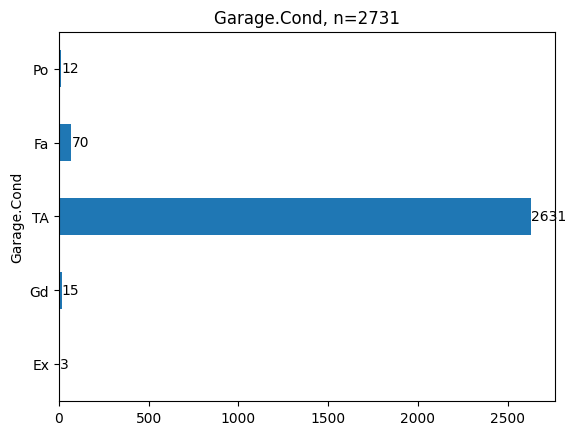

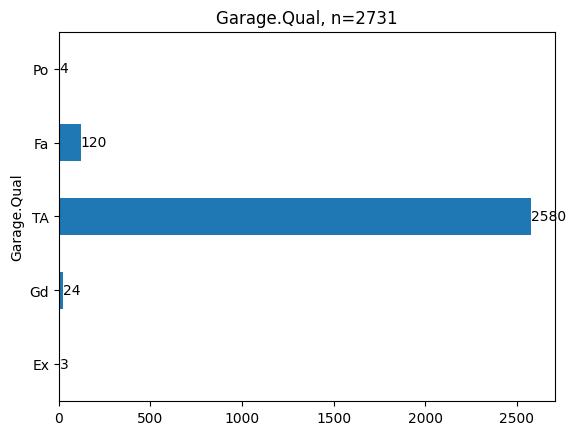

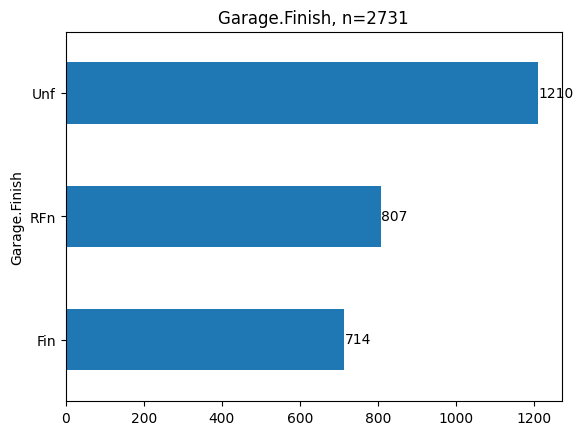

In [415]:
plot_categoricals(
    data,
    [
        'Garage.Cond',
        'Garage.Qual',
        'Garage.Finish',
    ],
    sorted=False,
)

While the `Garage.Cond` and `Garage.Qual` features can be ignored, the `Garage.Finish` feature seems to have relevant information. What to do?

In [416]:
data = data.drop(columns=['Garage.Cond', 'Garage.Qual'])


As always, some information will be discarded in one way or another. In this case we can transform the `Garage.Finish` variable from an ordinal variable to a nominal variable - that is, we discard the ordering of the finishing levels. This way we can create a new category `NoGarage` to account for the missing values.

In [417]:
data['Garage.Finish'] = data['Garage.Finish'] \
    .cat \
    .as_unordered() \
    .cat \
    .add_categories(['NoGarage'])
data['Garage.Finish'][data['Garage.Finish'].isna()] = 'NoGarage'

In [418]:
data['Garage.Finish'].value_counts()

Garage.Finish
Unf         1210
RFn          807
Fin          714
NoGarage     149
Name: count, dtype: int64

In [419]:
data['Garage.Finish'].dtype

CategoricalDtype(categories=['Fin', 'RFn', 'Unf', 'NoGarage'], ordered=False, categories_dtype=object)

In [420]:
data['Garage.Finish'].cat.ordered

False

##### `Electrical`

In [421]:
data['Electrical'].isna().value_counts()

Electrical
False    2879
True        1
Name: count, dtype: int64

           count unique    top  freq
Electrical  2879      5  SBrkr  2643


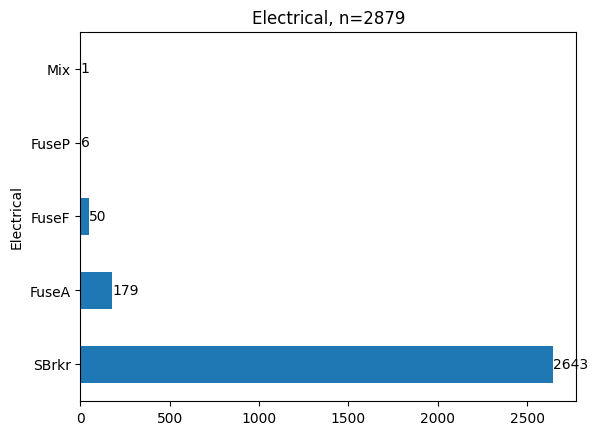

In [422]:
plot_categoricals(data, ['Electrical'], sorted=False)

So we can drop the only row with a missing value for the `Electrical` variable, or we can fill it with something. Given the high prevalence of the `SBrkr` category, lets set the missing value as that.

In [423]:
data['Electrical'][data['Electrical'].isna()] = 'SBrkr'

In [424]:
ordinal_columns = [col for col in data.select_dtypes('category') if data[col].cat.ordered]

In [425]:
data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2880 entries, 0 to 2929
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Lot.Shape       2880 non-null   category
 1   Land.Slope      2880 non-null   category
 2   Overall.Qual    2880 non-null   category
 3   Overall.Cond    2880 non-null   category
 4   Exter.Qual      2880 non-null   category
 5   Exter.Cond      2880 non-null   category
 6   Bsmt.Qual       2805 non-null   category
 7   Bsmt.Cond       2805 non-null   category
 8   Bsmt.Exposure   2802 non-null   category
 9   BsmtFin.Type.1  2805 non-null   category
 10  BsmtFin.Type.2  2804 non-null   category
 11  Heating.QC      2880 non-null   category
 12  Electrical      2880 non-null   category
 13  Kitchen.Qual    2880 non-null   category
 14  Functional      2880 non-null   category
 15  Fireplace.Qu    1488 non-null   category
 16  Paved.Drive     2880 non-null   category
 17  Fence           288

##### `Bsmt.Qual`, `Bsmt.Cond`, `Bsmt.Exposure`, `BsmtFin.Type.1`, `BsmtFin.Type.2`

               count unique  top  freq
Bsmt.Exposure   2802      4   No  1879
BsmtFin.Type.2  2804      6  Unf  2459
Bsmt.Qual       2805      4   TA  1262
Bsmt.Cond       2805      5   TA  2577
BsmtFin.Type.1  2805      6  GLQ   843


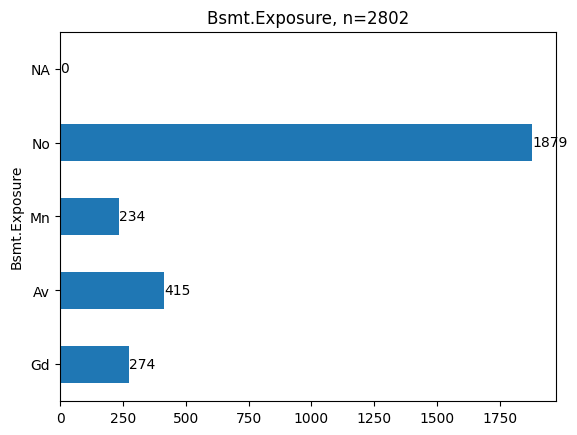

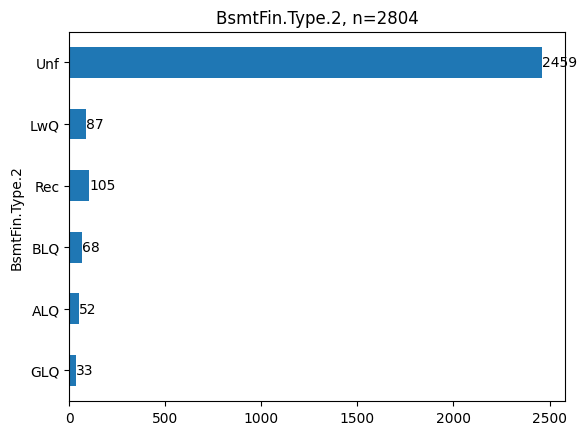

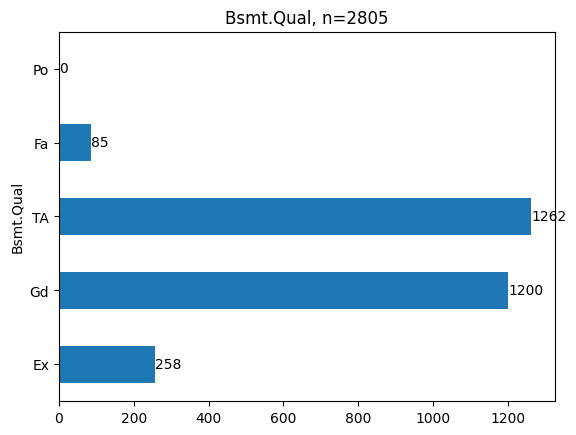

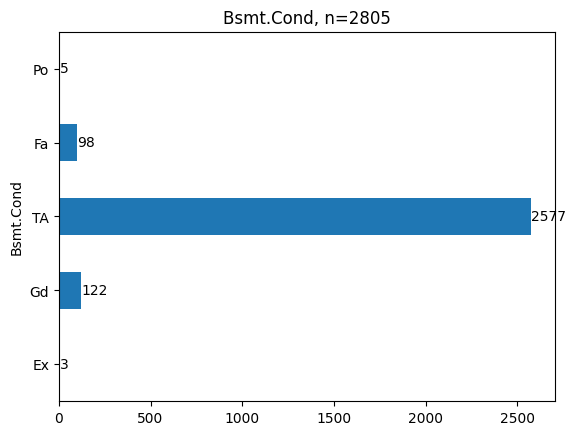

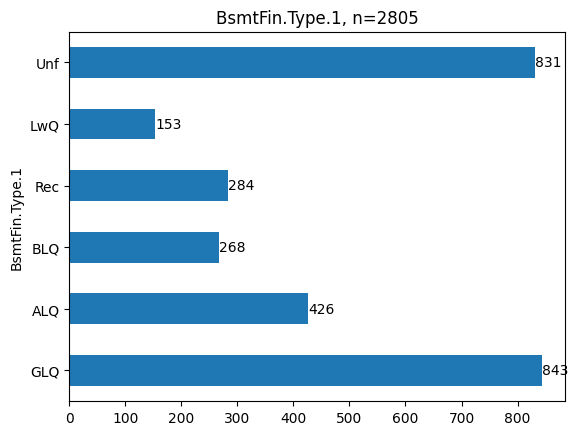

In [426]:
plot_categoricals(
    data,
    [
        'Bsmt.Qual',
        'Bsmt.Cond',
        'Bsmt.Exposure',
        'BsmtFin.Type.1',
        'BsmtFin.Type.2',
    ],
    sorted=False,
)

For `Bsmt.Exposure`, lets assign the missing entries to the `NA` category. For all the other columns (`Bsmt.Qual`, `Bsmt.Cond`, `BsmtFin.Type.1`, `BsmtFin.Type.2`) lets also create the `NA` category and assign the missing entries to that category. Finally, since the `NA` category does not fit into a sequence with the other classes, lets convert these columns to nominal (that is, categoricals without category order). Notice that in this case we need to eliminate the unused categories.

In [427]:
data['Bsmt.Exposure'].unique()

['Gd', 'No', 'Mn', 'Av', NaN]
Categories (5, object): ['Gd' < 'Av' < 'Mn' < 'No' < 'NA']

In [428]:
data['Bsmt.Exposure'][data['Bsmt.Exposure'].isna()] = 'NA'
data['Bsmt.Exposure'] = data['Bsmt.Exposure'] \
    .cat \
    .as_unordered() \
    .cat \
    .remove_unused_categories()

In [429]:
for col in ('Bsmt.Qual', 'Bsmt.Cond', 'BsmtFin.Type.1', 'BsmtFin.Type.2'):
    data[col] = data[col].cat.add_categories(['NA'])
    data[col][data[col].isna()] = 'NA'
    data[col] = data[col] \
        .cat \
        .as_unordered() \
        .cat \
        .remove_unused_categories()

               count unique  top  freq
Bsmt.Qual       2880      5   TA  1262
Bsmt.Cond       2880      6   TA  2577
Bsmt.Exposure   2880      5   No  1879
BsmtFin.Type.1  2880      7  GLQ   843
BsmtFin.Type.2  2880      7  Unf  2459


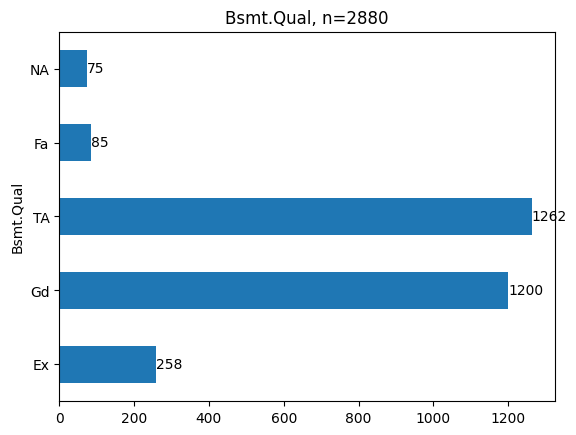

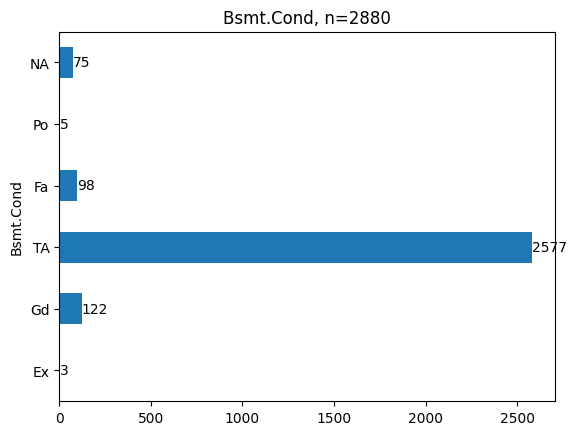

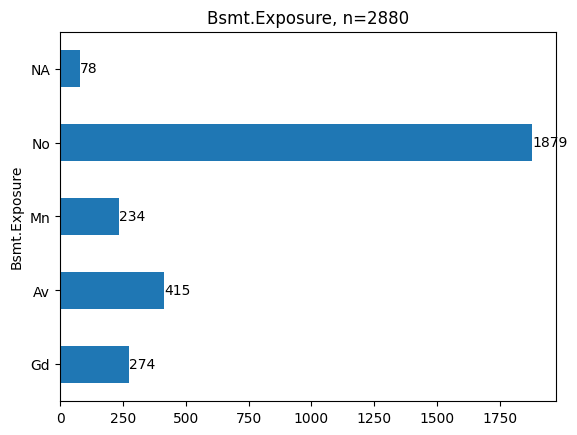

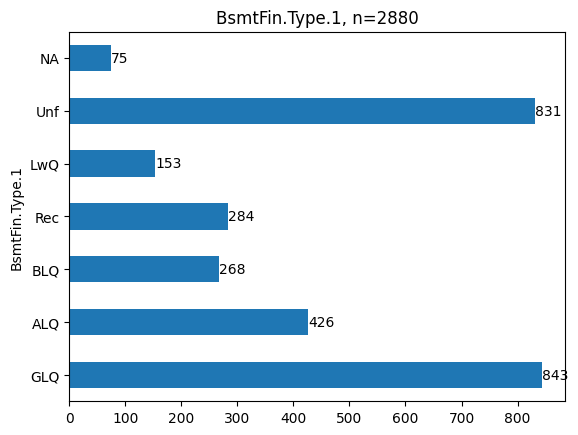

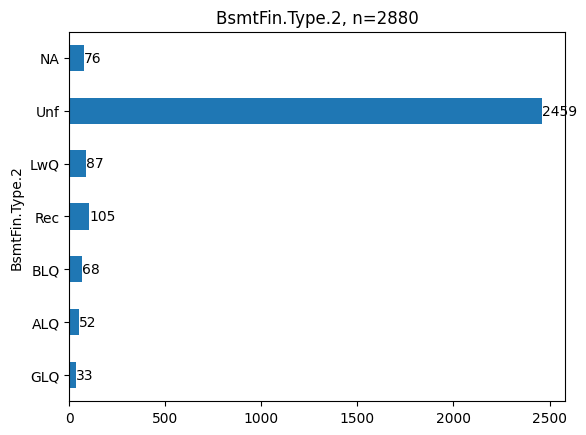

In [430]:
plot_categoricals(
    data,
    [
        'Bsmt.Qual',
        'Bsmt.Cond',
        'Bsmt.Exposure',
        'BsmtFin.Type.1',
        'BsmtFin.Type.2',
    ],
    sorted=False,
)

Lets also place the entries from the minor categories of `Bsmt.Cond` into neighboring categories, to simplify the dataset.


In [431]:
data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Po'] = 'Fa'
data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Ex'] = 'Gd'
data['Bsmt.Cond'] = data['Bsmt.Cond'].cat.remove_unused_categories()

In [432]:
data['Bsmt.Cond'].value_counts()

Bsmt.Cond
TA    2577
Gd     125
Fa     103
NA      75
Name: count, dtype: int64

In [433]:
data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2880 entries, 0 to 2929
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Lot.Shape       2880 non-null   category
 1   Land.Slope      2880 non-null   category
 2   Overall.Qual    2880 non-null   category
 3   Overall.Cond    2880 non-null   category
 4   Exter.Qual      2880 non-null   category
 5   Exter.Cond      2880 non-null   category
 6   Bsmt.Qual       2880 non-null   category
 7   Bsmt.Cond       2880 non-null   category
 8   Bsmt.Exposure   2880 non-null   category
 9   BsmtFin.Type.1  2880 non-null   category
 10  BsmtFin.Type.2  2880 non-null   category
 11  Heating.QC      2880 non-null   category
 12  Electrical      2880 non-null   category
 13  Kitchen.Qual    2880 non-null   category
 14  Functional      2880 non-null   category
 15  Fireplace.Qu    1488 non-null   category
 16  Paved.Drive     2880 non-null   category
 17  Fence           288

Great! All ordinal variables are corrected!

### Analyzing the continuous variables

Lets look for missing values, anomalies, outliers, and all sorts of things that may hinder our modeling.

                  count           mean           std      min        25%  \
Lot.Frontage     2397.0      69.472257     23.261537     21.0      59.00   
Garage.Yr.Blt    2731.0    1978.341633     25.388716   1900.0    1960.00   
Mas.Vnr.Area     2857.0     103.596430    180.153725      0.0       0.00   
Bsmt.Half.Bath   2878.0       0.061849      0.246625      0.0       0.00   
Bsmt.Full.Bath   2878.0       0.433634      0.525612      0.0       0.00   
Garage.Cars      2879.0       1.774575      0.757336      0.0       1.00   
Garage.Area      2879.0     474.925669    214.001822      0.0     325.50   
BsmtFin.SF.1     2879.0     444.993053    456.336521      0.0       0.00   
BsmtFin.SF.2     2879.0      50.041334    169.929207      0.0       0.00   
Bsmt.Unf.SF      2879.0     562.549844    440.582493      0.0     222.00   
Total.Bsmt.SF    2879.0    1057.584231    439.306589      0.0     796.00   
Wood.Deck.SF     2880.0      94.259375    126.960359      0.0       0.00   
Screen.Porch

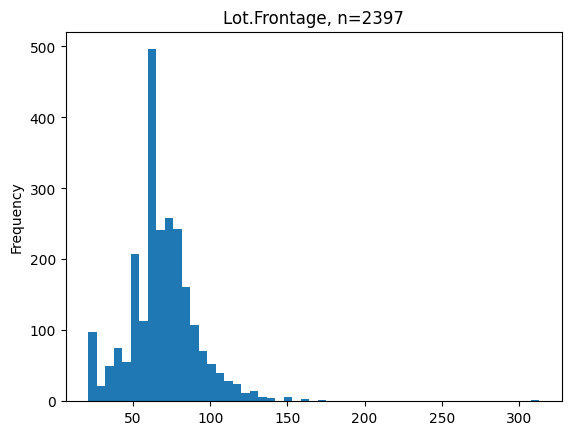

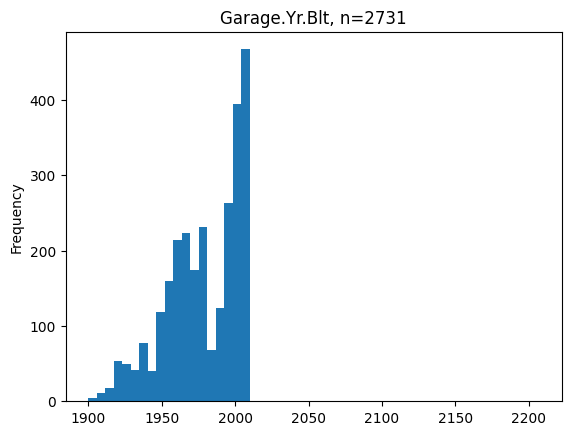

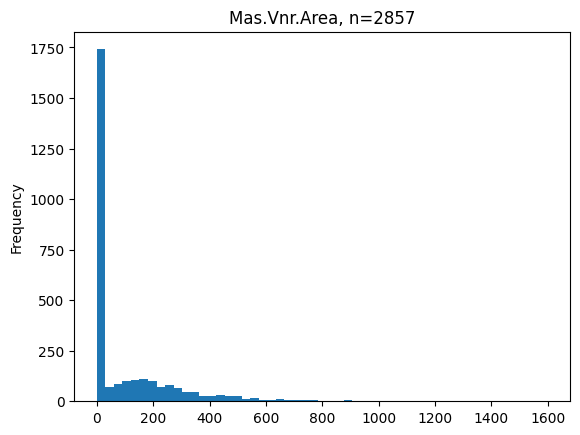

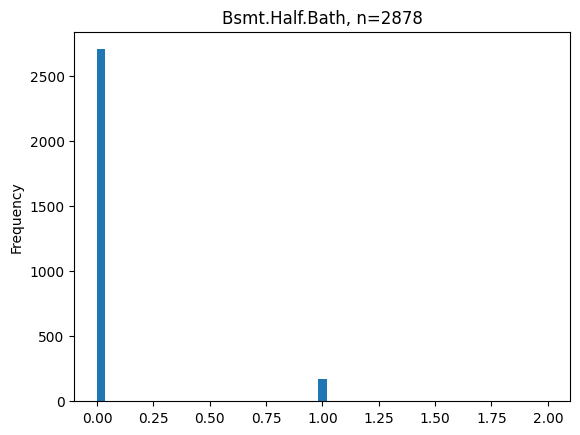

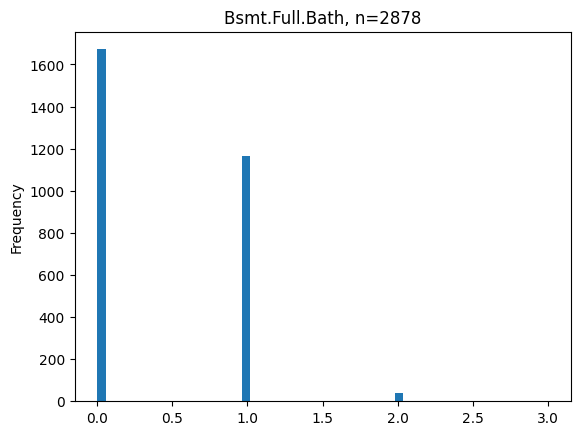

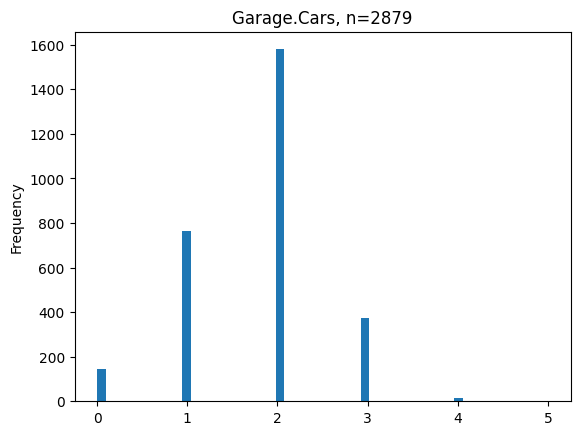

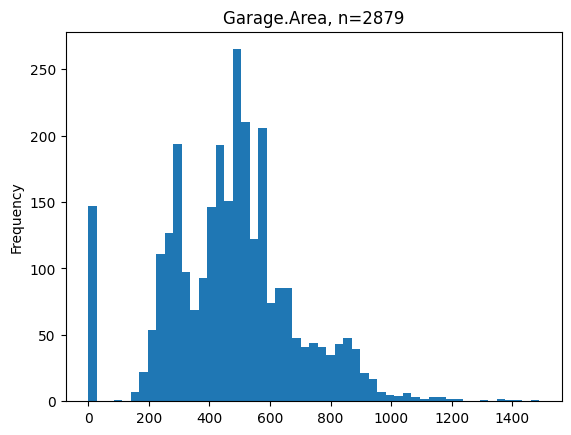

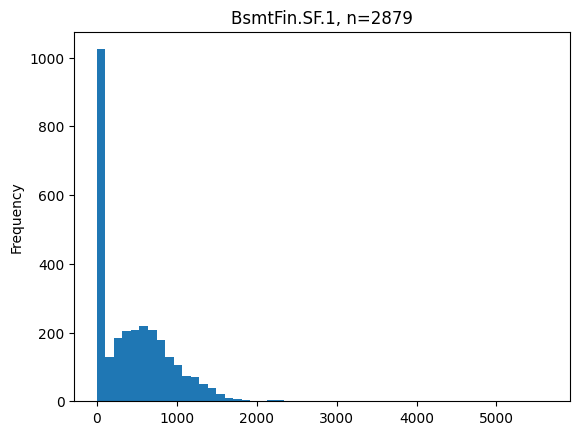

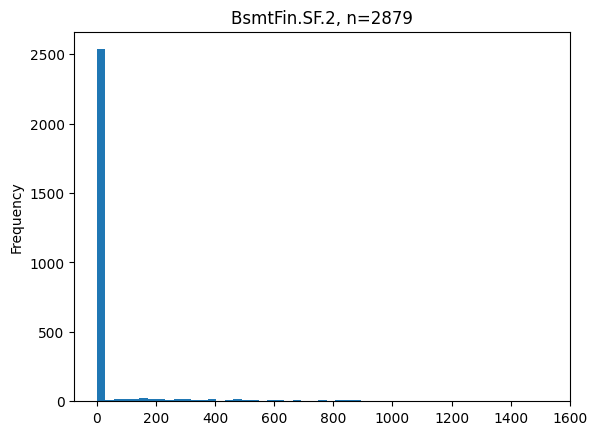

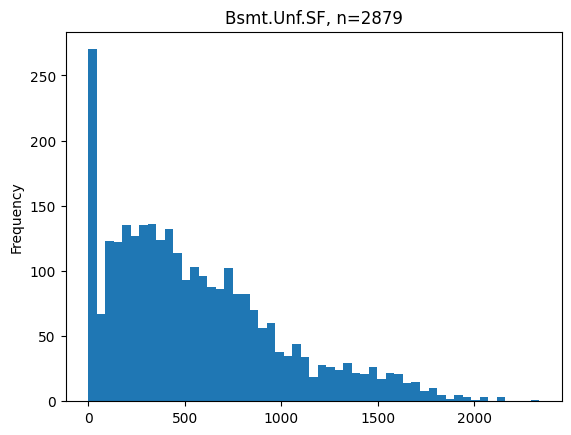

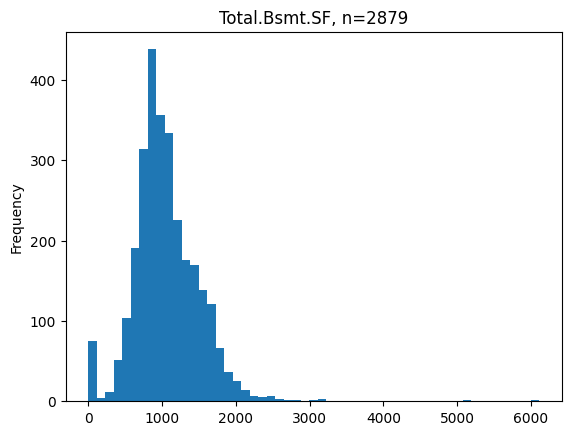

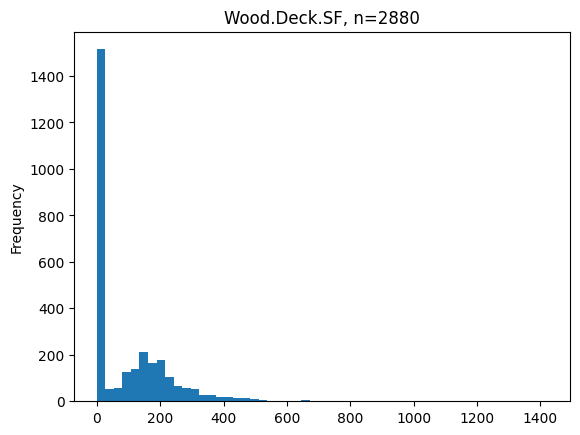

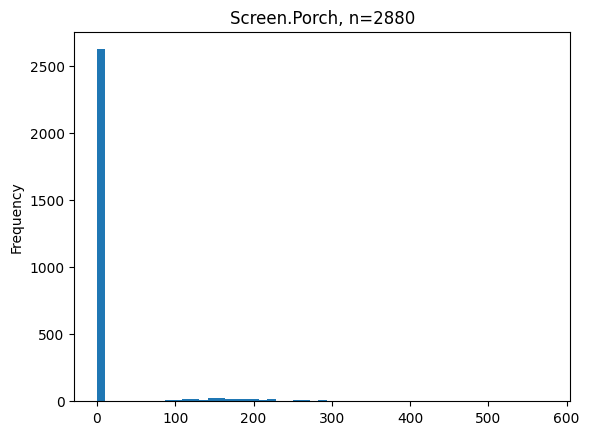

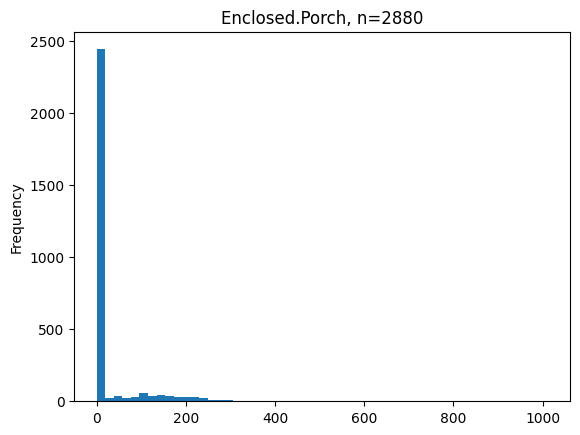

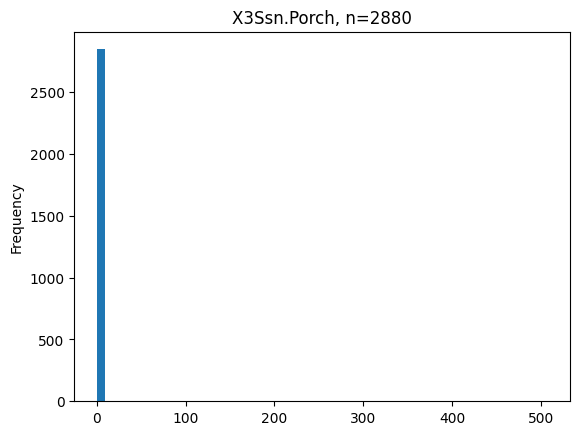

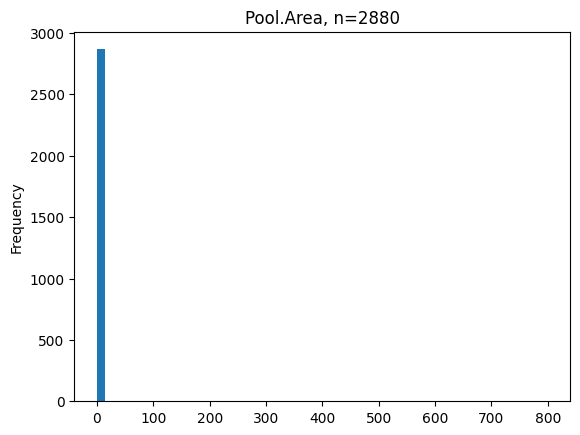

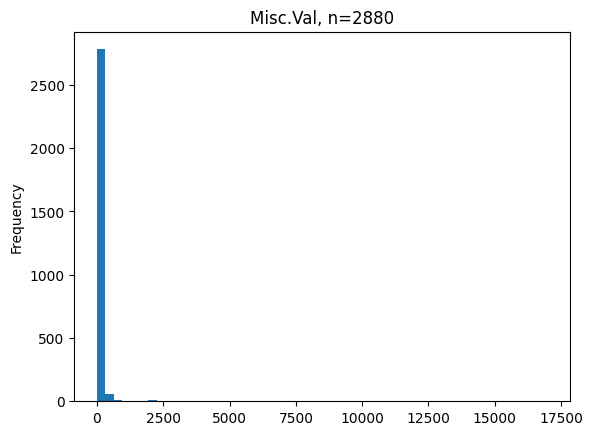

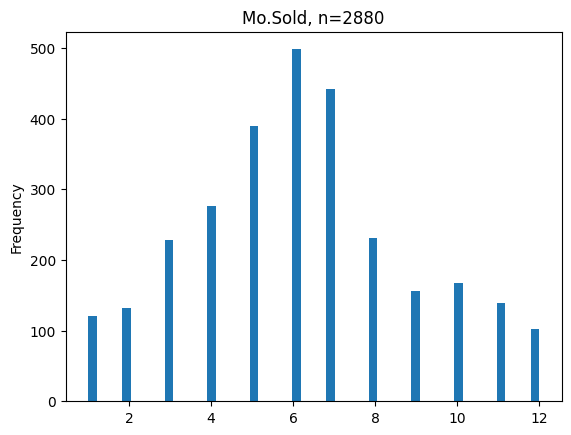

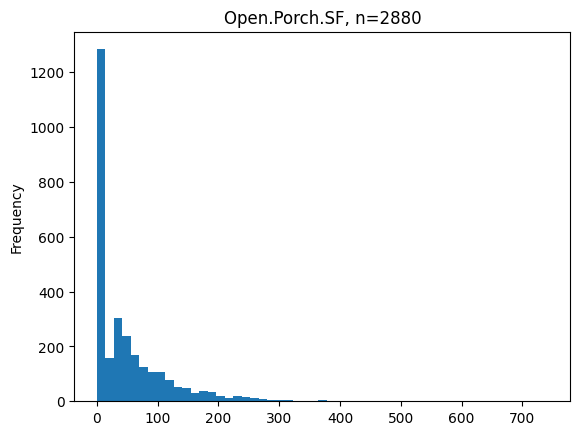

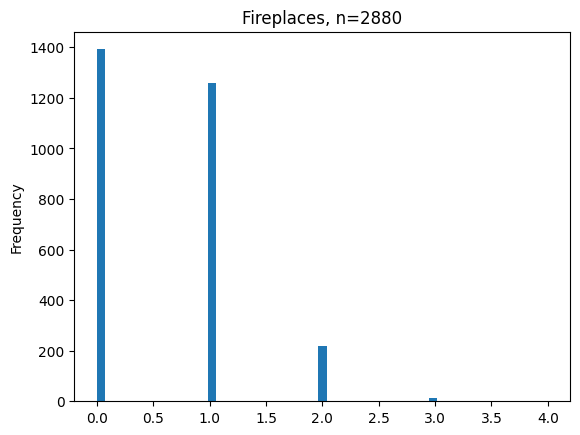

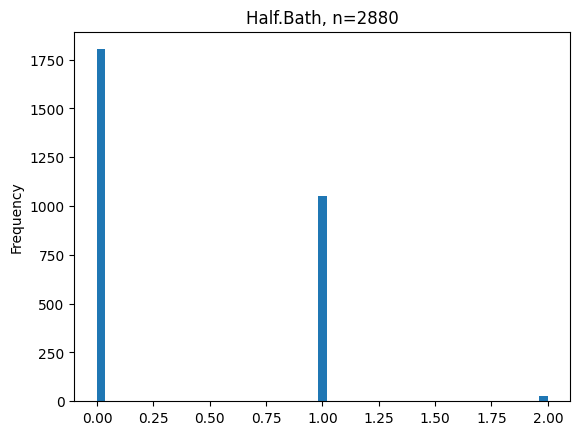

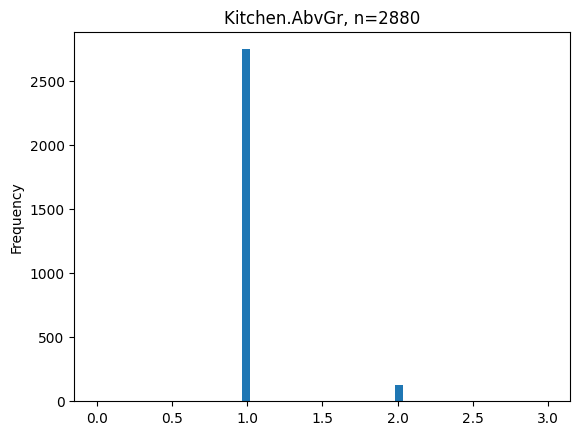

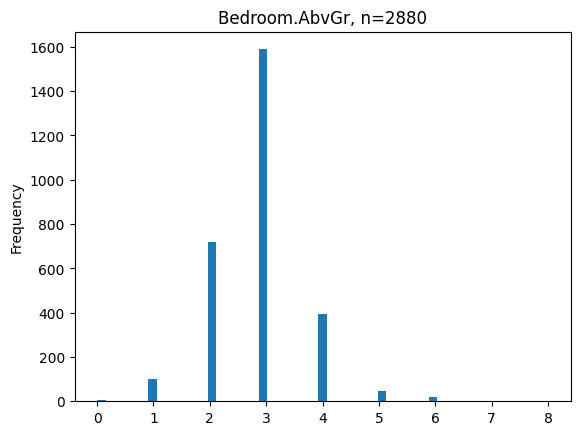

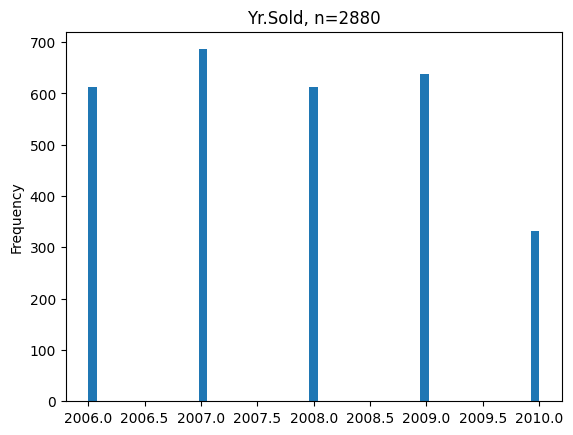

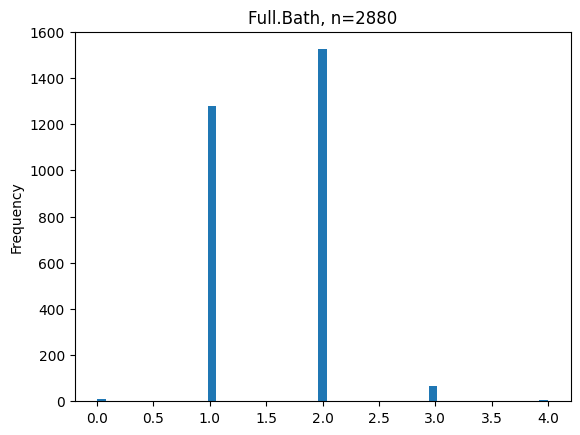

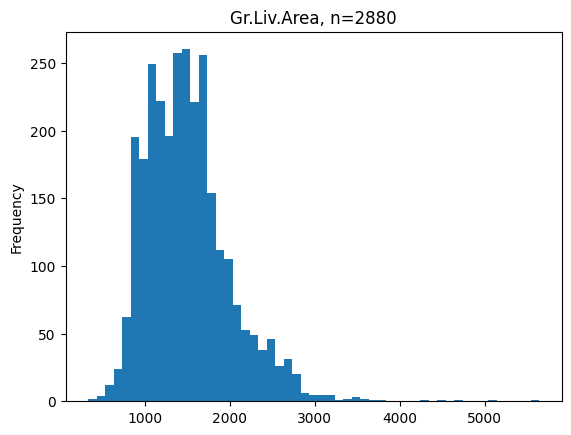

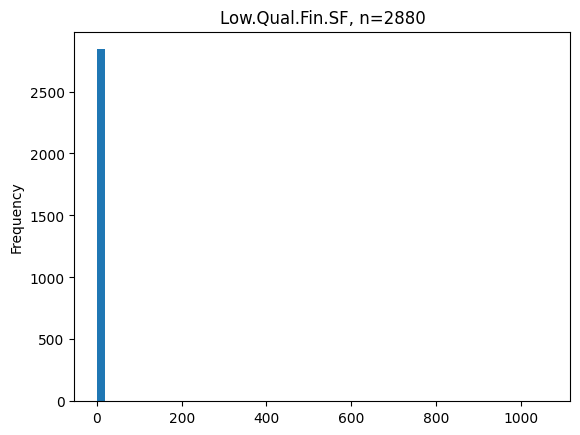

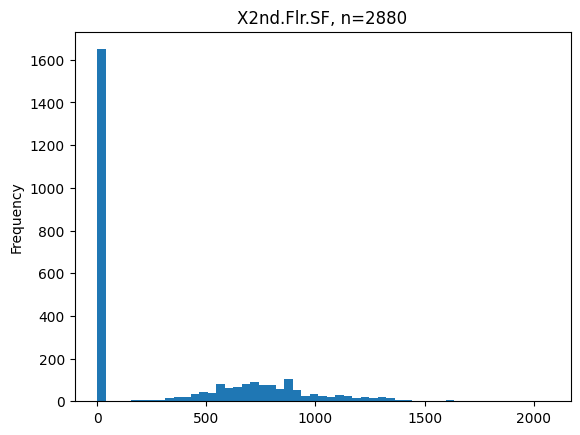

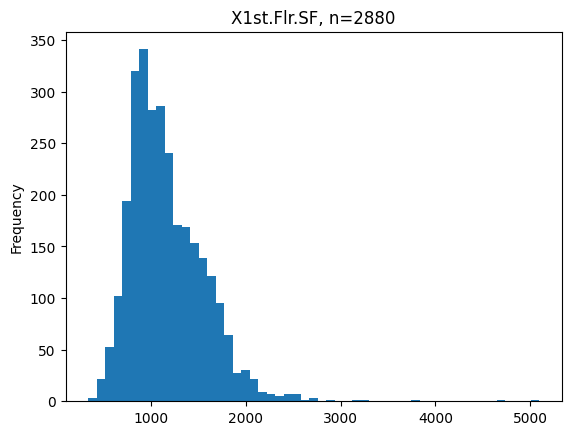

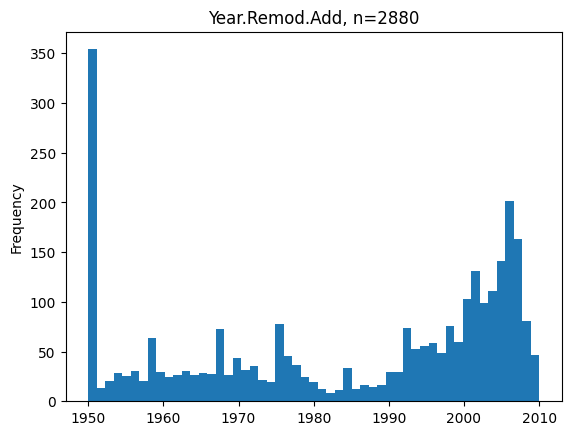

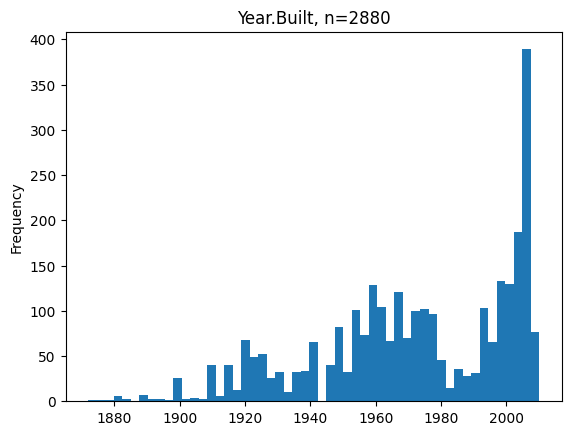

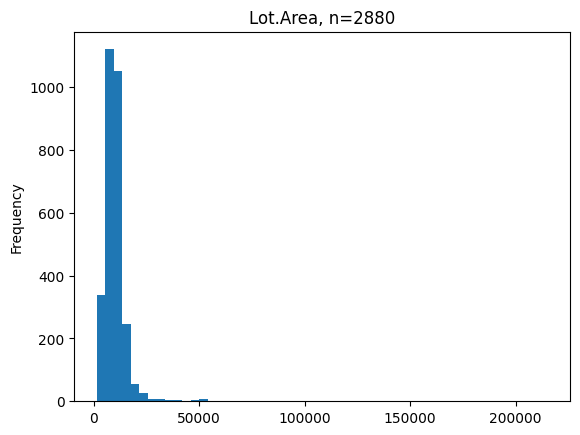

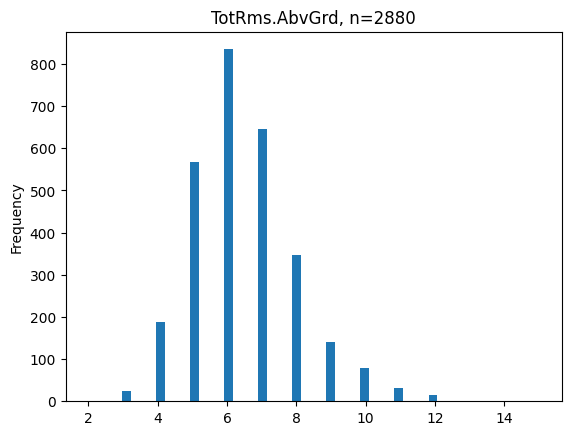

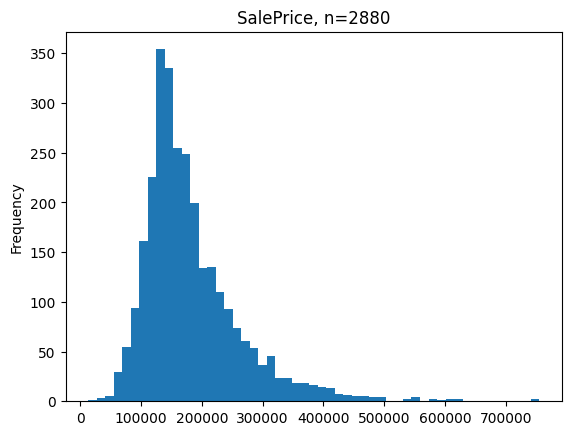

In [434]:
def plot_numericals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    n = data.shape[0]
    b = int(np.sqrt(n))
    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        data[col].plot.hist(bins=b)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_numericals(data, data.select_dtypes('number').columns)

#### `SalePrice`

Ah, the target! The most special feature of all! Sale prices have a few special properties:

- They are always non-negative, and most likely have a min value that is positive.
- The *importance of the difference* of sale prices is not absolute: a difference of $10k in a house valued at $100k is a lot (10%), but in a house valued at $1M is negligible.

These characteristics suggest something important: maybe our model should predict the *logarithm* of the sale price, rather than the actual price! This way, errors are associated with proportions, rather than absolute values! 

Lets analyze the previous sentence mathematically. Call $P$ the real value of a house, and $\hat{P}$ the value given by our (yet to be developed) model. However, since we will work with the logarithm of $P$ and $\hat{P}$ instead, lets name the log-values as well: $y = \log_{10}{(P)}$ and $\hat{y} = \log_{10}{(\hat{P})}$.

(Why base $10$? Mere convenience: the value of $y$ or $\hat{y}$ can be immediately associated with the base-$10$ magnitude of the house price they represent. For instance: $y = 5.6$ implies $P = 10^{5.6} = 10^{0.6} \times 10^{5}$, which is something in the range of hundreds of thousands. So, take the integer part of the base-$10$ logarithm and you automatically have the order of magnitude of the price).

Now, when we have a prediction value $\hat{y}$ for a house with log-price $y$, the error is $\varepsilon = (\hat{y} - y)$. Substituting the definitions of $y$ and $\hat{y}$ we have:

$$
\varepsilon = \hat{y} - y = \log_{10}{(\hat{P})} - \log_{10}{(P)} = \log_{10}{\left(\frac{\hat{P}}{P}\right)}
$$

Therefore we can obtain the prediction error for this house as a fraction:

$$
10^{\varepsilon} = 10^{\log_{10}{\left(\frac{\hat{P}}{P}\right)}} = \frac{\hat{P}}{P}
$$

And we can convert it into a percentage:

$$
\varepsilon_{\%} = 100 * (10^{\varepsilon} - 1) = 100 * \left(\frac{\hat{P}}{P} - 1\right) = 100 * \left(\frac{\hat{P} - P}{P}\right)
$$

Percentual errors are much more informative of the practical value of our (future) model. If I tell you that the average error of a model is 50k USD, is this good or bad? It depends on the price of the house we are considering: an error of 50k USD in a house valued at 250k USD is very significant, whereas if the house costed 10 million USD, then an error of 50k USD is quite acceptable. Now, if I tell you that the model has an average error of $5\%$, this is understandable across all ranges of house prices.


Lets work this out:

In [435]:
data['SalePrice'].describe()

count      2880.000000
mean     181875.418403
std       79723.474874
min       12789.000000
25%      130000.000000
50%      161000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Lets remap the `SalePrice` variable to represent the base-10 logarithm of the original value. Again, why base 10? Any base will do, but the base 10 is a bit more interpretable: a value of 3 means thousands, 4 means tens of thousands, 6 means million, etc.

In [436]:
data['SalePrice'] = data['SalePrice'].apply(np.log10)

In [437]:
data['SalePrice'].describe()

count    2880.000000
mean        5.224370
std         0.172850
min         4.106837
25%         5.113943
50%         5.206826
75%         5.330414
max         5.877947
Name: SalePrice, dtype: float64

#### `Lot.Frontage`

In [438]:
data['Lot.Frontage'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Lot.Frontage
Non-Null Count  Dtype  
--------------  -----  
2397 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


Plenty of missing values here, what do they mean? The documentation is not very helpful:

```
Lot Frontage (Continuous): Linear feet of street connected to property
```

Maybe the relation between this feature and some other feature will explain it.

In [439]:
missing_lot_frontage = data['Lot.Frontage'].isna()

In [440]:
data['MS.SubClass'][missing_lot_frontage].value_counts()

MS.SubClass
20       185
60       133
80        33
120       32
50        25
90        17
85        16
30        12
160       12
70         9
Other      5
190        4
Name: count, dtype: int64

In [441]:
data['Lot.Config'][missing_lot_frontage].value_counts()

Lot.Config
Inside     268
Corner     104
CulDSac     87
FR2         20
FR3          4
Name: count, dtype: int64

In [442]:
data['Land.Contour'][missing_lot_frontage].value_counts()

Land.Contour
Lvl    430
Low     26
Bnk     16
HLS     11
Name: count, dtype: int64

Nope, no obvious relationship. Is this column even useful for prediction? Lets compare it with `SalePrice`:

Text(0, 0.5, '$\\log_{10} SalePrice$')

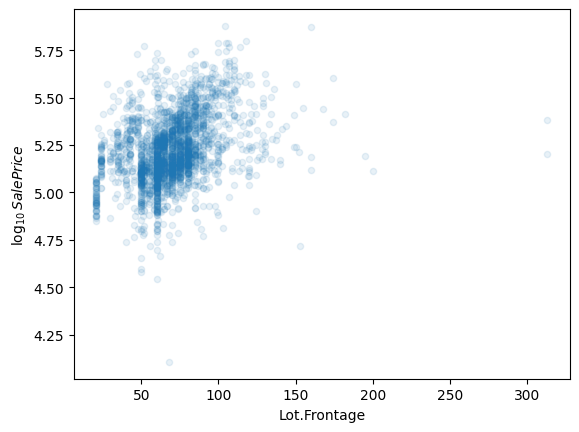

In [443]:
data.plot.scatter(x='Lot.Frontage', y='SalePrice', alpha=0.1)
plt.ylabel('$\log_{10} SalePrice$')

Yikes, no way to ignore this feature! Can we at least relate it to `Lot.Area`?

In [444]:
data[['Lot.Frontage', 'Lot.Area']].corr()

Lot.Frontage  Lot.Area
Lot.Frontage      1.000000  0.483203
Lot.Area          0.483203  1.000000

There is some correlation there, maybe the square-root of the lot area shows better correlation?

In [445]:
aux_data = data[['Lot.Frontage', 'Lot.Area']].copy()
aux_data['Sqrt.Lot.Area'] = aux_data['Lot.Area'].apply(np.sqrt)

In [446]:
aux_data[['Lot.Frontage', 'Sqrt.Lot.Area']].corr()

Lot.Frontage  Sqrt.Lot.Area
Lot.Frontage       1.000000       0.640834
Sqrt.Lot.Area      0.640834       1.000000

Nice! There is a healthy relationship between `Lot.Frontage` and the square root of `Lot.Area`!

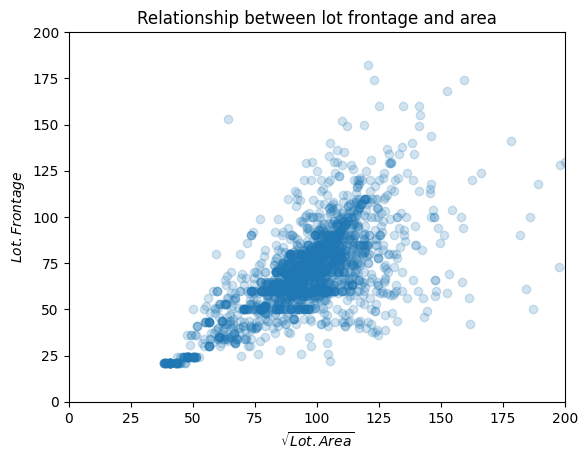

In [447]:
x = np.sqrt(data['Lot.Area'])
y = data['Lot.Frontage']
plt.scatter(x, y, alpha=0.2)
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.xlabel('$\sqrt{Lot.Area}$')
plt.ylabel('$Lot.Frontage$')
plt.title('Relationship between lot frontage and area')
plt.show()

We could *predict* the `Lot.Frontage` for the mising entries from the `Lot.Area` feature!

The task of filling up missing values is called **Imputation**. There are several imputation strategies, some of them are:

- Replace with some meaningful constant independent of the dataset - e.g. zero.
- Replace with a constant derived from the dataset, like the mean or median.
- Replace with a predicted value from other variables.

So, fitting a linear model to predict `Lot.Frontage` from the square root of `Lot.Area` could be a good alternative. But for now lets do the simplest thing: impute the missing values of `Lot.Frontage` simply with the median of `Lot.Frontage`. Once we are more familiar with modelling we can revisit this decision.

**Caution**: There is also the possibility that the missing values represent residences that *do not have a frontage*! No way to tell from the documentation or the relationship with other relevant variables! Another moment here where the really best course of action is to go back to the expert and ask questions, ok?

In [448]:
data['Lot.Frontage'] = data['Lot.Frontage'].fillna(data['Lot.Frontage'].median())

In [449]:
data['Lot.Frontage'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Lot.Frontage
Non-Null Count  Dtype  
--------------  -----  
2880 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


#### `Garage.Yr.Blt` 

In [450]:
data['Garage.Yr.Blt'].describe()

count    2731.000000
mean     1978.341633
std        25.388716
min      1900.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: Garage.Yr.Blt, dtype: float64

Oops! Looks like someone built a garage in the future!

The documentation states that the residential sales were collected from 2006 to 2010. We have the `Yr.Sold` variable to let us know when the house was sold. So we can obtain from those the information of how old the garage was when the house was sold! That is a better variable than `Garage.Yr.Blt` by itself.

In [451]:
garage_age = data['Yr.Sold'] - data['Garage.Yr.Blt']
garage_age.describe()

count    2731.000000
mean       29.443061
std        25.425924
min      -200.000000
25%         6.000000
50%        28.000000
75%        47.500000
max       110.000000
dtype: float64

Lets look at the garages "from the future"

In [452]:
data[garage_age < 0.0].transpose()

2180      2260
MS.SubClass            20        20
MS.Zoning              RL        RL
Lot.Frontage        128.0      68.0
Lot.Area          39290.0    8298.0
Lot.Shape             IR1       IR1
Land.Contour          Bnk       HLS
Lot.Config         Inside    Inside
Land.Slope            Gtl       Gtl
Neighborhood      Edwards    Timber
Bldg.Type            1Fam      1Fam
House.Style        1Story    1Story
Overall.Qual           10         8
Overall.Cond            5         5
Year.Built         2008.0    2006.0
Year.Remod.Add     2009.0    2007.0
Roof.Style            Hip       Hip
Mas.Vnr.Type        Stone      None
Mas.Vnr.Area       1224.0       NaN
Exter.Qual             Ex        Gd
Exter.Cond             TA        TA
Foundation          PConc     PConc
Bsmt.Qual              Ex        Gd
Bsmt.Cond              TA        TA
Bsmt.Exposure          Gd        Av
BsmtFin.Type.1        GLQ       GLQ
BsmtFin.SF.1       4010.0     583.0
BsmtFin.Type.2        Unf       Unf
BsmtFin.SF.2          0.0       0.0
Bsmt.Unf.SF        1085.0     963.0
Total.Bsmt.SF      5095.0    1546.0
Heating.QC             Ex        Ex
Central.Air             Y         Y
Electrical          SBrkr     SBrkr
X1st.Flr.SF        5095.0    1564.0
X2nd.Flr.SF           0.0       0.0
Low.Qual.Fin.SF       0.0       0.0
Gr.Liv.Area        5095.0    1564.0
Bsmt.Full.Bath        1.0       0.0
Bsmt.Half.Bath        1.0       0.0
Full.Bath             2.0       2.0
Half.Bath             1.0       0.0
Bedroom.AbvGr         2.0       2.0
Kitchen.AbvGr         1.0       1.0
Kitchen.Qual           Ex        Ex
TotRms.AbvGrd        15.0       6.0
Functional            Typ       Typ
Fireplaces            2.0       1.0
Fireplace.Qu           Gd        Gd
Garage.Type        Attchd    Attchd
Garage.Yr.Blt      2008.0    2207.0
Garage.Finish         Fin       RFn
Garage.Cars           3.0       2.0
Garage.Area        1154.0     502.0
Paved.Drive             Y         Y
Wood.Deck.SF        546.0     132.0
Open.Porch.SF       484.0       0.0
Enclosed.Porch        0.0       0.0
X3Ssn.Porch           0.0       0.0
Screen.Porch          0.0       0.0
Pool.Area             0.0       0.0
Fence             NoFence   NoFence
Misc.Val          17000.0       0.0
Mo.Sold              10.0       9.0
Yr.Sold            2007.0    2007.0
Sale.Type             New       New
Sale.Condition    Partial   Partial
SalePrice        5.264464  5.426999
Condition            Norm      Norm
HasShed             False     False
HasAlley            False     False
Exterior          CemntBd   VinylSd

Only two rows. One is an obvious mistake, the other looks somewhat legitimate: house was sold new in 2007, garage was only finished in 2008. We can safely correct these errors, but if there was any doubt about the validity of fixing them, it is better to get rid of the rows. In our case we will set the garage age to zero.

In [453]:
garage_age[garage_age < 0.0] = 0.0

And now we remove the `Garage.Yr.Blt` column, replacing it with a new `Garage.Age` column.

In [454]:
data = data.drop(columns='Garage.Yr.Blt')
data['Garage.Age'] = garage_age

What about the missing values of the new `Garage.Age` column?

In [455]:
data['Garage.Age'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Garage.Age
Non-Null Count  Dtype  
--------------  -----  
2731 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


In [456]:
data['Garage.Type'][data['Garage.Age'].isna()].value_counts()

Garage.Type
NoGarage    147
Detchd        2
2Types        0
Attchd        0
Basment       0
BuiltIn       0
CarPort       0
Name: count, dtype: int64

Seems like they correspond to the absence of garage. What is a reasonable value for imputation of `Garage.Age` when there is no garage? Zero? Median? 

Or drop the rows altogether? (Seems excessive!)

Lets just impute the median here. The logic is that we want to cause the least harm to the data by doing this.

In [457]:
data['Garage.Age'] = data['Garage.Age'].fillna(data['Garage.Age'].median())

#### `Year.Remod.Add`, `Year.Built`

Lets apply the same age treatment to these variables

In [458]:
data[['Year.Remod.Add', 'Year.Built', 'Yr.Sold']].describe()

Year.Remod.Add   Year.Built      Yr.Sold
count     2880.000000  2880.000000  2880.000000
mean      1984.514236  1971.773264  2007.788542
std         20.799105    30.012773     1.313914
min       1950.000000  1872.000000  2006.000000
25%       1966.000000  1954.000000  2007.000000
50%       1993.000000  1973.000000  2008.000000
75%       2004.000000  2001.000000  2009.000000
max       2010.000000  2010.000000  2010.000000

In [459]:
remod_age = data['Yr.Sold'] - data['Year.Remod.Add']
remod_age.describe()

count    2880.000000
mean       23.274306
std        20.792340
min        -2.000000
25%         4.000000
50%        15.000000
75%        42.000000
max        60.000000
dtype: float64

Oops, another weirdness, lets check

In [460]:
data[remod_age < 0.0].transpose()

1702      2180      2181
MS.SubClass            60        20        60
MS.Zoning              RL        RL        RL
Lot.Frontage        134.0     128.0     130.0
Lot.Area          16659.0   39290.0   40094.0
Lot.Shape             IR1       IR1       IR1
Land.Contour          Lvl       Bnk       Bnk
Lot.Config         Corner    Inside    Inside
Land.Slope            Gtl       Gtl       Gtl
Neighborhood      NridgHt   Edwards   Edwards
Bldg.Type            1Fam      1Fam      1Fam
House.Style        2Story    1Story    2Story
Overall.Qual            8        10        10
Overall.Cond            5         5         5
Year.Built         2007.0    2008.0    2007.0
Year.Remod.Add     2008.0    2009.0    2008.0
Roof.Style          Gable       Hip       Hip
Mas.Vnr.Type         None     Stone     Stone
Mas.Vnr.Area          0.0    1224.0     762.0
Exter.Qual             Gd        Ex        Ex
Exter.Cond             TA        TA        TA
Foundation          PConc     PConc     PConc
Bsmt.Qual              Gd        Ex        Ex
Bsmt.Cond              TA        TA        TA
Bsmt.Exposure          No        Gd        Gd
BsmtFin.Type.1        Unf       GLQ       GLQ
BsmtFin.SF.1          0.0    4010.0    2260.0
BsmtFin.Type.2        Unf       Unf       Unf
BsmtFin.SF.2          0.0       0.0       0.0
Bsmt.Unf.SF        1582.0    1085.0     878.0
Total.Bsmt.SF      1582.0    5095.0    3138.0
Heating.QC             Ex        Ex        Ex
Central.Air             Y         Y         Y
Electrical          SBrkr     SBrkr     SBrkr
X1st.Flr.SF        1582.0    5095.0    3138.0
X2nd.Flr.SF         570.0       0.0    1538.0
Low.Qual.Fin.SF       0.0       0.0       0.0
Gr.Liv.Area        2152.0    5095.0    4676.0
Bsmt.Full.Bath        0.0       1.0       1.0
Bsmt.Half.Bath        0.0       1.0       0.0
Full.Bath             2.0       2.0       3.0
Half.Bath             1.0       1.0       1.0
Bedroom.AbvGr         3.0       2.0       3.0
Kitchen.AbvGr         1.0       1.0       1.0
Kitchen.Qual           Gd        Ex        Ex
TotRms.AbvGrd         7.0      15.0      11.0
Functional            Typ       Typ       Typ
Fireplaces            1.0       2.0       1.0
Fireplace.Qu           Gd        Gd        Gd
Garage.Type        Detchd    Attchd   BuiltIn
Garage.Finish         Unf       Fin       Fin
Garage.Cars           2.0       3.0       3.0
Garage.Area         728.0    1154.0     884.0
Paved.Drive             Y         Y         Y
Wood.Deck.SF          0.0     546.0     208.0
Open.Porch.SF       368.0     484.0     406.0
Enclosed.Porch        0.0       0.0       0.0
X3Ssn.Porch           0.0       0.0       0.0
Screen.Porch          0.0       0.0       0.0
Pool.Area             0.0       0.0       0.0
Fence             NoFence   NoFence   NoFence
Misc.Val              0.0   17000.0       0.0
Mo.Sold               6.0      10.0      10.0
Yr.Sold            2007.0    2007.0    2007.0
Sale.Type             New       New       New
Sale.Condition    Partial   Partial   Partial
SalePrice        5.415167  5.264464  5.266584
Condition            Norm      Norm  Positive
HasShed             False     False     False
HasAlley            False     False     False
Exterior          VinylSd   CemntBd   CemntBd
Garage.Age            0.0       0.0       0.0

Same story, lets set the remodeling age to zero for these cases

In [461]:
remod_age[remod_age < 0.0] = 0.0

In [462]:
house_age = data['Yr.Sold'] - data['Year.Built']
house_age.describe()

count    2880.000000
mean       36.015278
std        30.053254
min        -1.000000
25%         7.000000
50%        34.000000
75%        54.000000
max       136.000000
dtype: float64

Again...

In [463]:
data[house_age < 0.0].transpose()

2180
MS.SubClass            20
MS.Zoning              RL
Lot.Frontage        128.0
Lot.Area          39290.0
Lot.Shape             IR1
Land.Contour          Bnk
Lot.Config         Inside
Land.Slope            Gtl
Neighborhood      Edwards
Bldg.Type            1Fam
House.Style        1Story
Overall.Qual           10
Overall.Cond            5
Year.Built         2008.0
Year.Remod.Add     2009.0
Roof.Style            Hip
Mas.Vnr.Type        Stone
Mas.Vnr.Area       1224.0
Exter.Qual             Ex
Exter.Cond             TA
Foundation          PConc
Bsmt.Qual              Ex
Bsmt.Cond              TA
Bsmt.Exposure          Gd
BsmtFin.Type.1        GLQ
BsmtFin.SF.1       4010.0
BsmtFin.Type.2        Unf
BsmtFin.SF.2          0.0
Bsmt.Unf.SF        1085.0
Total.Bsmt.SF      5095.0
Heating.QC             Ex
Central.Air             Y
Electrical          SBrkr
X1st.Flr.SF        5095.0
X2nd.Flr.SF           0.0
Low.Qual.Fin.SF       0.0
Gr.Liv.Area        5095.0
Bsmt.Full.Bath        1.0
Bsmt.Half.Bath        1.0
Full.Bath             2.0
Half.Bath             1.0
Bedroom.AbvGr         2.0
Kitchen.AbvGr         1.0
Kitchen.Qual           Ex
TotRms.AbvGrd        15.0
Functional            Typ
Fireplaces            2.0
Fireplace.Qu           Gd
Garage.Type        Attchd
Garage.Finish         Fin
Garage.Cars           3.0
Garage.Area        1154.0
Paved.Drive             Y
Wood.Deck.SF        546.0
Open.Porch.SF       484.0
Enclosed.Porch        0.0
X3Ssn.Porch           0.0
Screen.Porch          0.0
Pool.Area             0.0
Fence             NoFence
Misc.Val          17000.0
Mo.Sold              10.0
Yr.Sold            2007.0
Sale.Type             New
Sale.Condition    Partial
SalePrice        5.264464
Condition            Norm
HasShed             False
HasAlley            False
Exterior          CemntBd
Garage.Age            0.0

Same approach, lets set the age to zero in this case.

In [464]:
house_age[house_age < 0.0] = 0.0

In [465]:
data = data.drop(columns=['Year.Remod.Add', 'Year.Built'])
data['Remod.Age'] = remod_age
data['House.Age'] = house_age

#### `Mas.Vnr.Area`

In [466]:
data['Mas.Vnr.Area'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Mas.Vnr.Area
Non-Null Count  Dtype  
--------------  -----  
2857 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


Just a few missing values here. Do they correspond to the absence of veneer?

In [467]:
data['Mas.Vnr.Type'][data['Mas.Vnr.Area'].isna()].value_counts()

Mas.Vnr.Type
None       23
BrkFace     0
Stone       0
Other       0
Name: count, dtype: int64

Yep. Impute with zeros.

In [468]:
data.loc[data['Mas.Vnr.Area'].isna(), 'Mas.Vnr.Area'] = 0.0

#### Features that contain a lot of zeros

In the case of features that contain a lot of zeros, it could be that the feature contains actual information in the non-zero cases, and zero to indicate that the feature is absent. Consider, for instance, the `Pool.Area` feature:

In [469]:
num_houses = data.shape[0]
num_houses_with_pool = data[data['Pool.Area'] > 0].shape[0]
print(f'Out of {num_houses} houses, only {num_houses_with_pool} have a pool.')

Out of 2880 houses, only 13 have a pool.


What to do? Discard the column? Discard the rows (we don't appraise houses with pools!)? Transform the column into a categorical `HasPool`?

Actually, it depends on the model. A linear model, for instance, can safely process this column: since the pool area for houses without pools is zero, the contribution of the pool area to the house price will be zero (remember that a linear model associates a multiplicative coefficient for each variable).

So we leave them all as is! We can revisit our decisions once we play a bit with the predictive model *as long as we only use the training dataset* - more on this later.

#### Final cleanup

In [470]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2880 entries, 0 to 2929
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2880 non-null   category
 1   MS.Zoning        2880 non-null   category
 2   Lot.Frontage     2880 non-null   float64 
 3   Lot.Area         2880 non-null   float64 
 4   Lot.Shape        2880 non-null   category
 5   Land.Contour     2880 non-null   category
 6   Lot.Config       2880 non-null   category
 7   Land.Slope       2880 non-null   category
 8   Neighborhood     2880 non-null   category
 9   Bldg.Type        2880 non-null   category
 10  House.Style      2880 non-null   category
 11  Overall.Qual     2880 non-null   category
 12  Overall.Cond     2880 non-null   category
 13  Roof.Style       2880 non-null   category
 14  Mas.Vnr.Type     2880 non-null   category
 15  Mas.Vnr.Area     2880 non-null   float64 
 16  Exter.Qual       2880 non-null   category
 17  

After all this effort, only a few columns have just one missing value! We suffered enough, lets just drop those rows.

In [471]:
data = data.dropna(axis=0)

In [472]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1487 entries, 0 to 2929
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      1487 non-null   category
 1   MS.Zoning        1487 non-null   category
 2   Lot.Frontage     1487 non-null   float64 
 3   Lot.Area         1487 non-null   float64 
 4   Lot.Shape        1487 non-null   category
 5   Land.Contour     1487 non-null   category
 6   Lot.Config       1487 non-null   category
 7   Land.Slope       1487 non-null   category
 8   Neighborhood     1487 non-null   category
 9   Bldg.Type        1487 non-null   category
 10  House.Style      1487 non-null   category
 11  Overall.Qual     1487 non-null   category
 12  Overall.Cond     1487 non-null   category
 13  Roof.Style       1487 non-null   category
 14  Mas.Vnr.Type     1487 non-null   category
 15  Mas.Vnr.Area     1487 non-null   float64 
 16  Exter.Qual       1487 non-null   category
 17  

Nice, not a single missing value! Let us also remove unused categories, for good measure.

In [473]:
for col in data.select_dtypes('category').columns:
    data[col] = data[col].cat.remove_unused_categories()

## Joint feature analysis

There are two types of joint feature analysis:

- feature versus feature
- feature versus target

Lets start with the "feature versus target" analysis.

### Feature versus target

In this scenario we are exploring the relationship between an individual feature and the target. Since we are involving the target, it is best to do this after splitting the dataset into training and testing subsets, to avoid inferring deep relations between the features and the target without an "out-of-sample" dataset to use to measure the generalization capacity of our (soon-to-be-developed) model. 

Why? Because this involuntary "peeking into the test dataset" may cause us to make design decisions for our model that are way too adapted to the entire dataset, leaving no way to investigate if our decisions truly lead us to a model that makes effective predictions for unseen data, or if it is only "memorizing" the entire dataset. Looking into test data before all model-design decisions are made is called **data snooping**.

So the only thing we will look at prior to train-test splitting is a simple numerical and visual correlation between the features and the target.

Here are the scatter plots between the numerical features and the target. Look for perfect correlations: they may indicate that one of the features is the target in disguise!

In [474]:
numerical_data = data.select_dtypes('number').drop(columns='SalePrice').copy()
target = data['SalePrice'].copy()

In [475]:
numerical_data.corrwith(target).sort_values()

House.Age         -0.587555
Remod.Age         -0.585770
Garage.Age        -0.569052
Enclosed.Porch    -0.137533
Bsmt.Half.Bath    -0.082414
Kitchen.AbvGr     -0.071549
Low.Qual.Fin.SF   -0.047147
Yr.Sold           -0.036604
Misc.Val          -0.023303
BsmtFin.SF.2      -0.004531
X3Ssn.Porch        0.019965
Pool.Area          0.046318
Mo.Sold            0.056745
Screen.Porch       0.058628
Fireplaces         0.105821
Bedroom.AbvGr      0.108756
Bsmt.Unf.SF        0.157776
Lot.Area           0.200904
Half.Bath          0.235417
X2nd.Flr.SF        0.239101
Wood.Deck.SF       0.275074
Lot.Frontage       0.290958
Bsmt.Full.Bath     0.294942
Open.Porch.SF      0.302125
BsmtFin.SF.1       0.399875
Mas.Vnr.Area       0.460524
TotRms.AbvGrd      0.486026
Full.Bath          0.531659
X1st.Flr.SF        0.551373
Total.Bsmt.SF      0.593228
Garage.Area        0.646296
Gr.Liv.Area        0.662956
Garage.Cars        0.686272
dtype: float64

Unsurprisingly:

- The older the house, the lower the price
- The larger the house, the higher the price

Surprisingly, the `Lot.Area` has low correlation with the target!

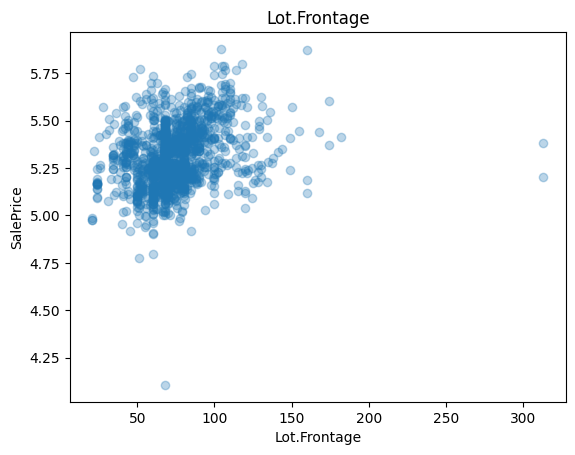

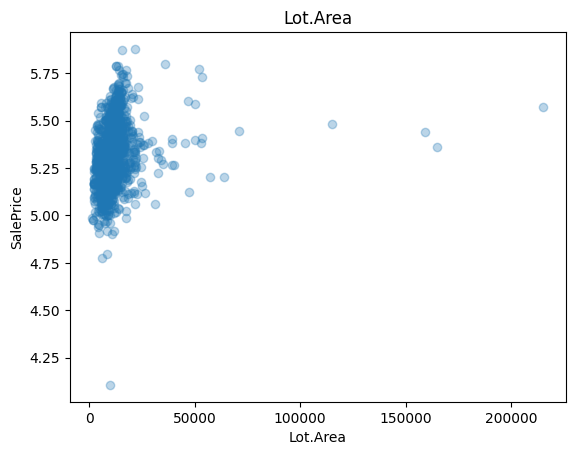

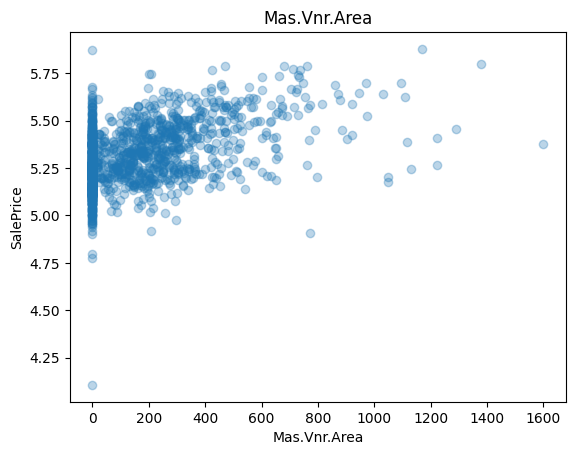

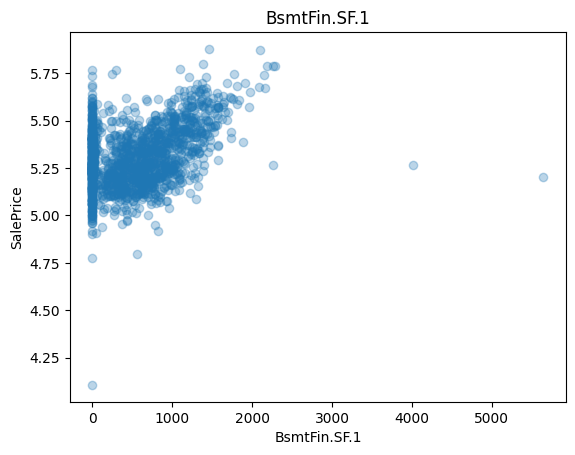

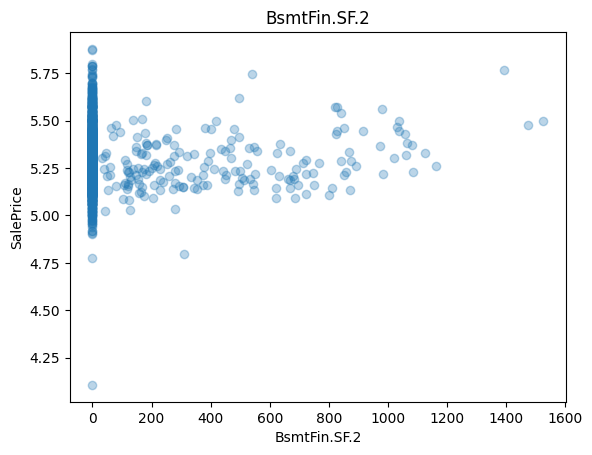

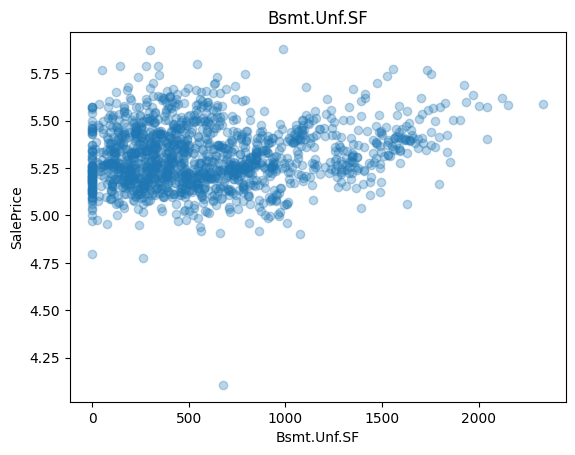

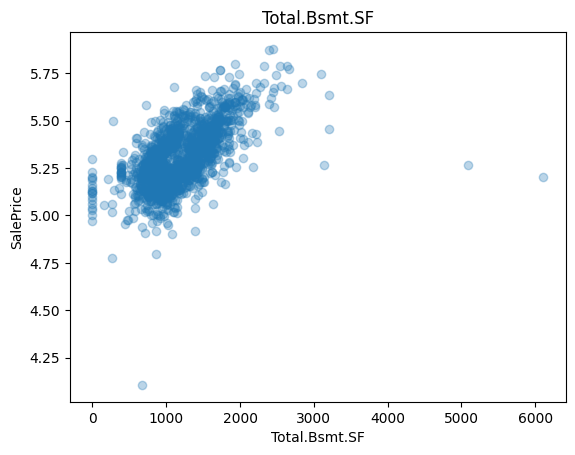

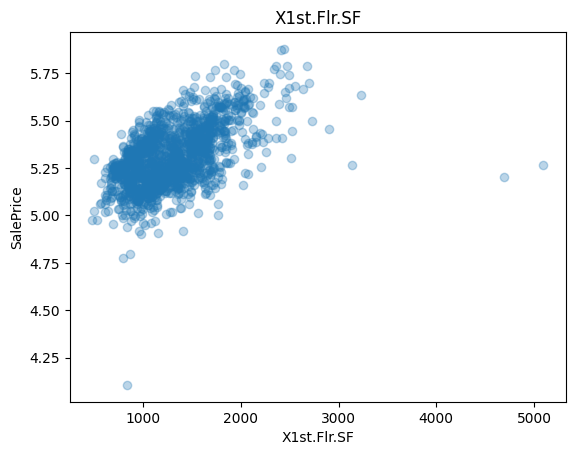

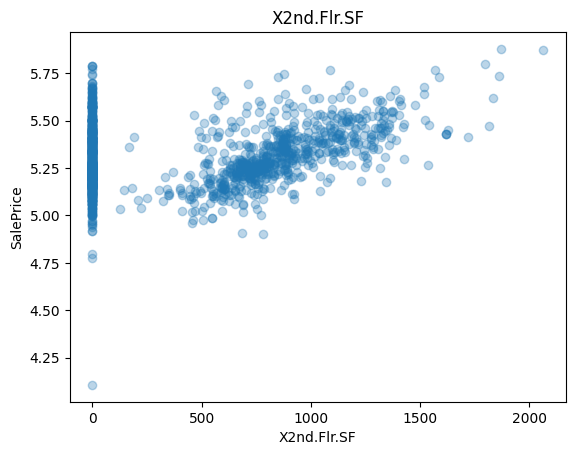

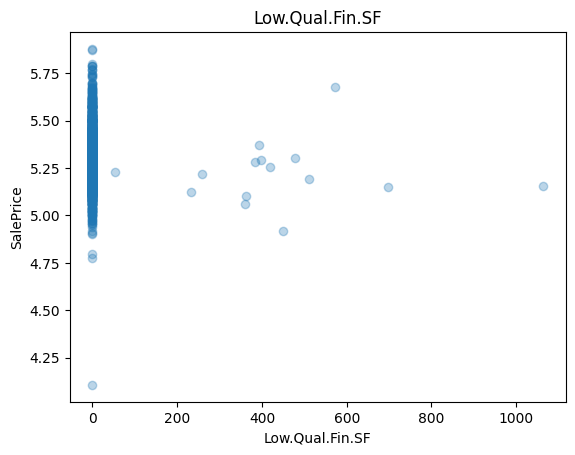

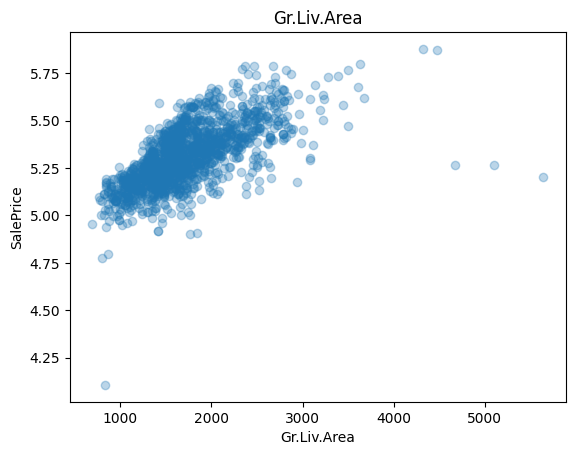

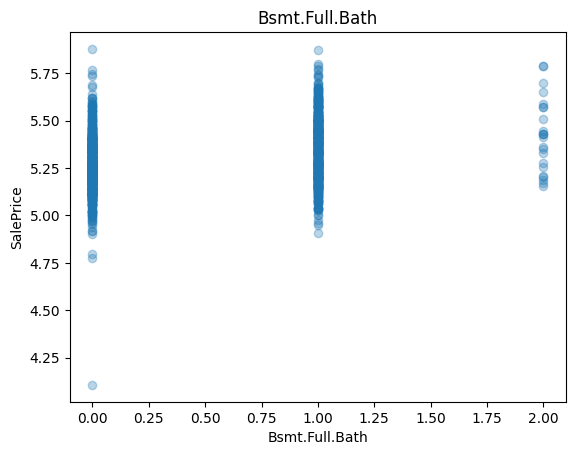

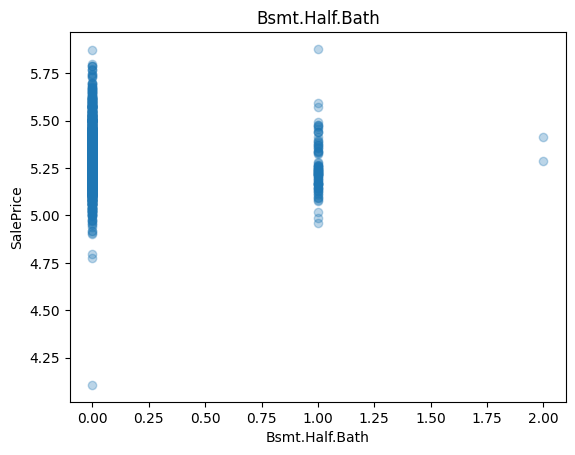

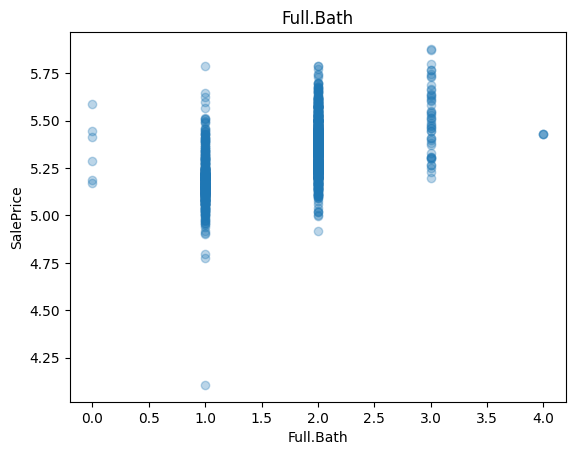

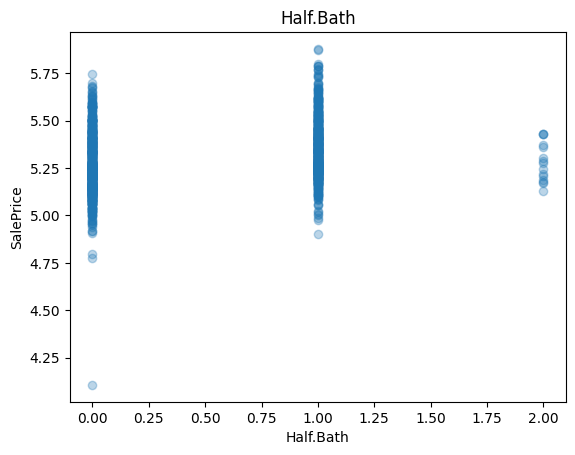

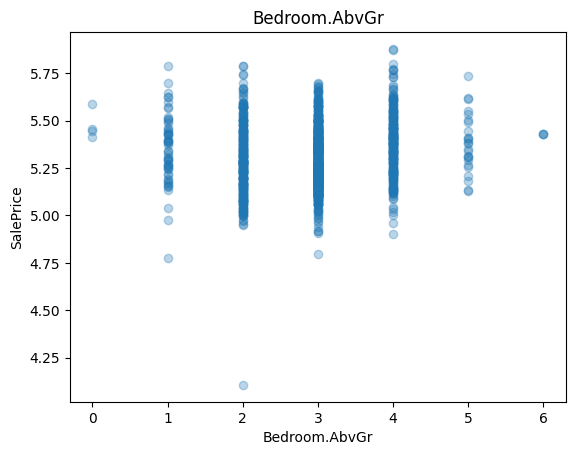

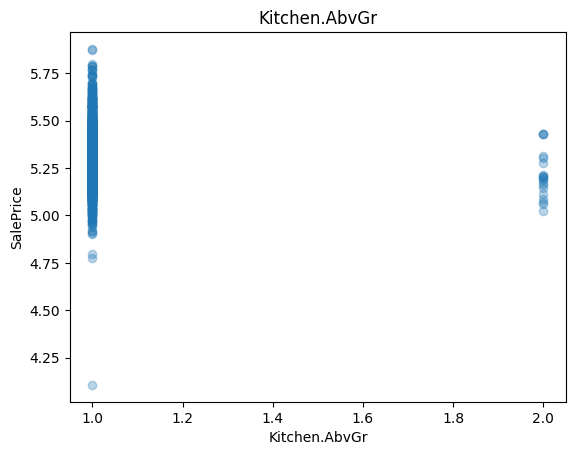

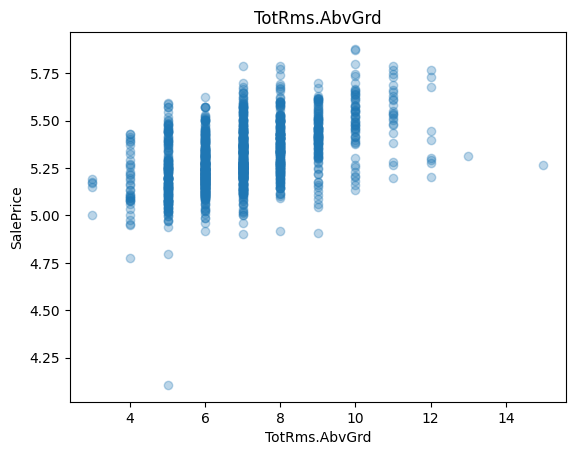

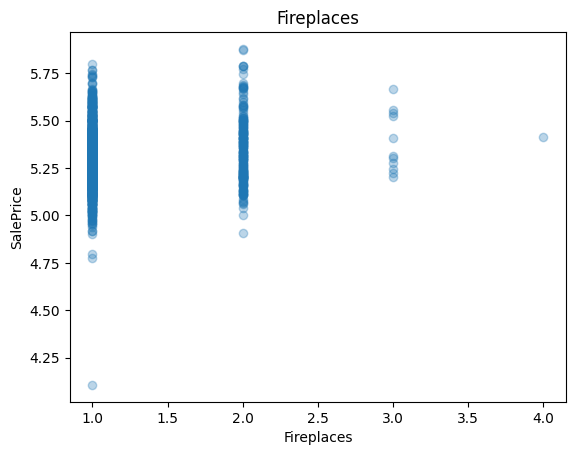

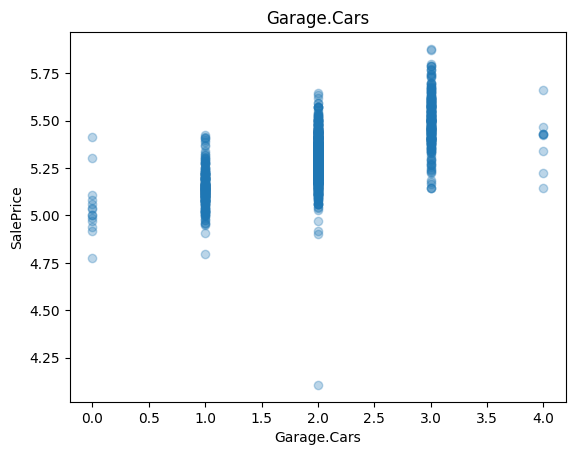

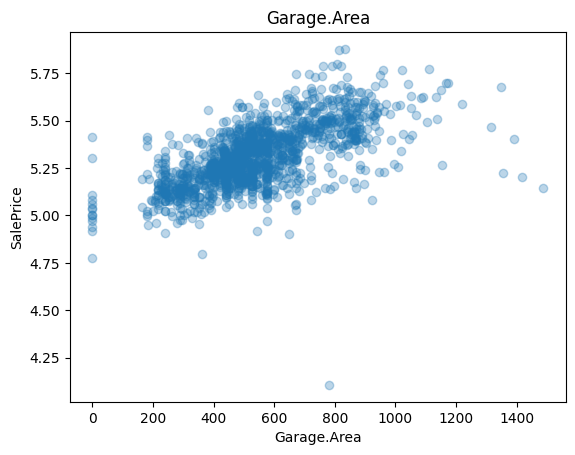

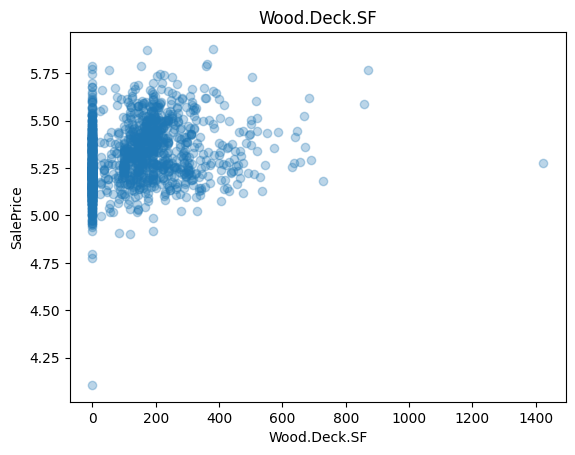

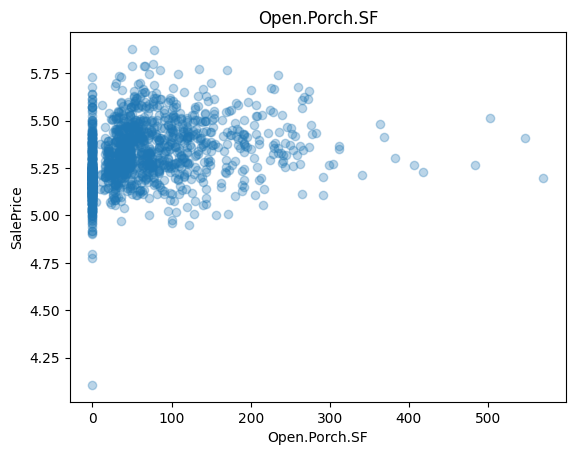

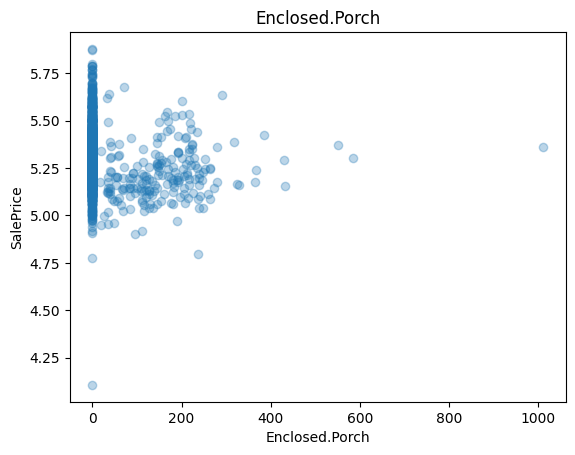

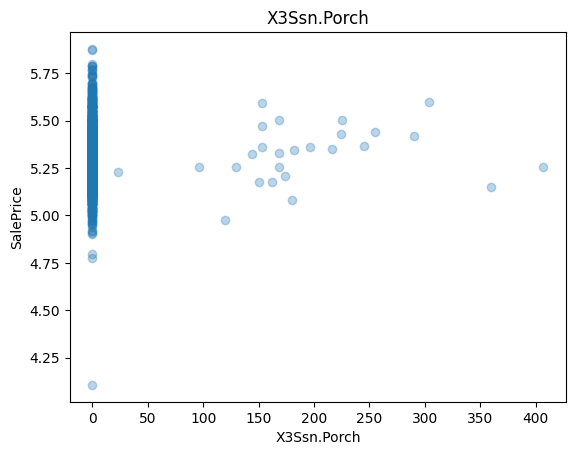

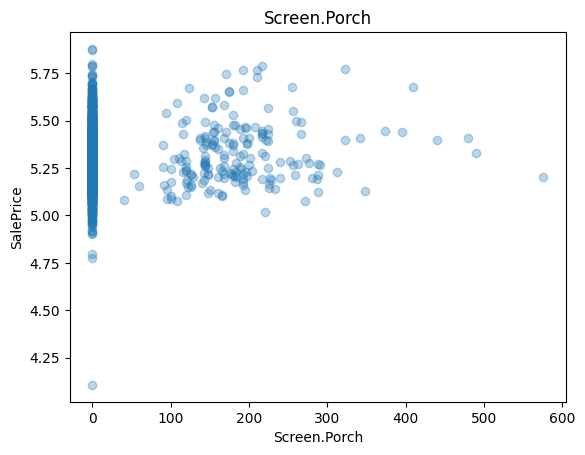

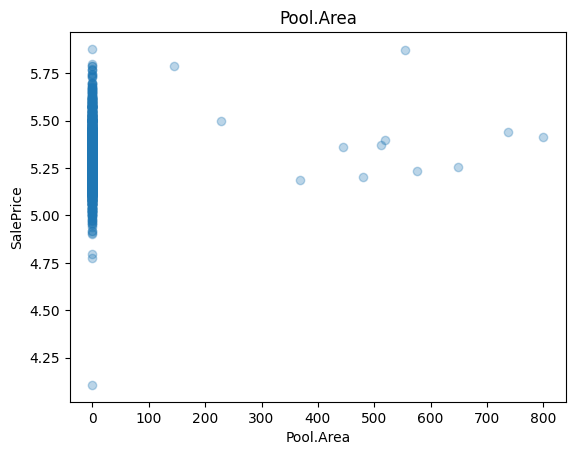

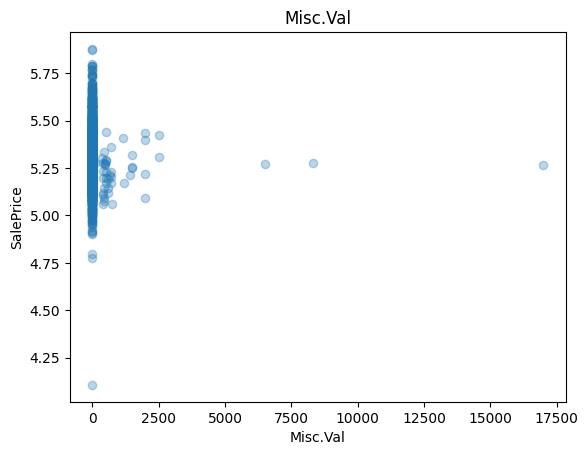

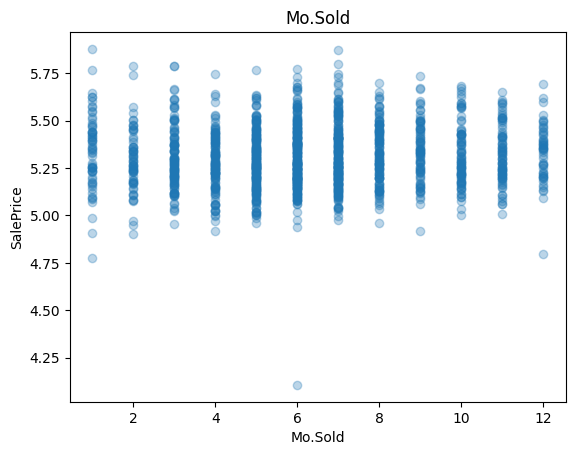

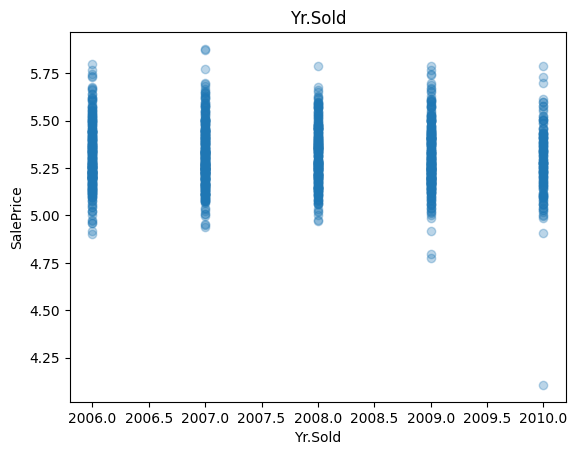

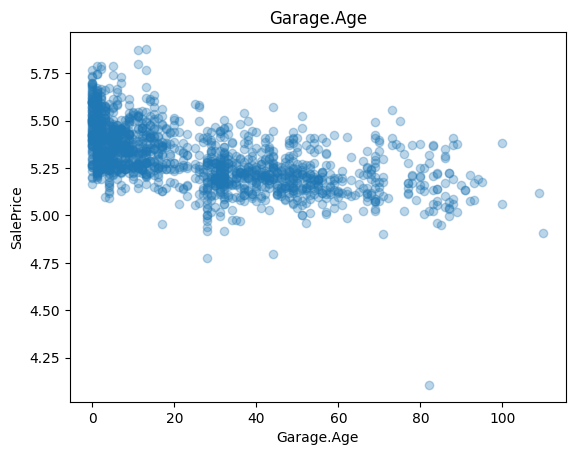

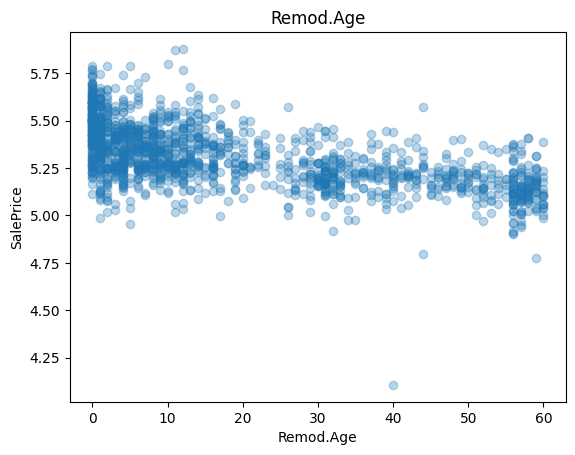

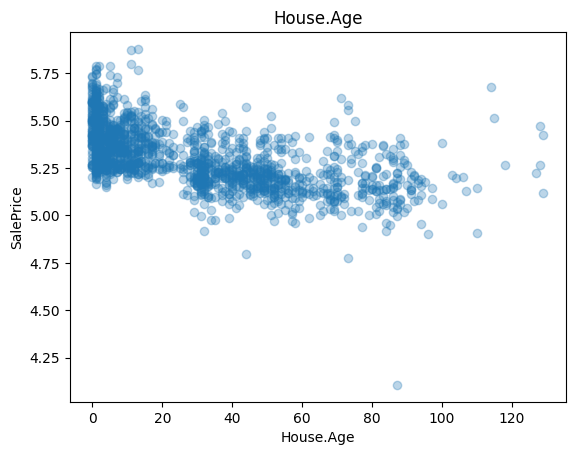

In [476]:
for column, series in numerical_data.items():
    plt.figure()
    plt.scatter(series, target, alpha=0.3)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('SalePrice')
    plt.show()

Looks like no feature is perfectly predicting the target, which could indicate an obvious error in understanding the dataset.

For the categorical features we will use box plots:

In [477]:
categorical_columns = data.select_dtypes('category').columns

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


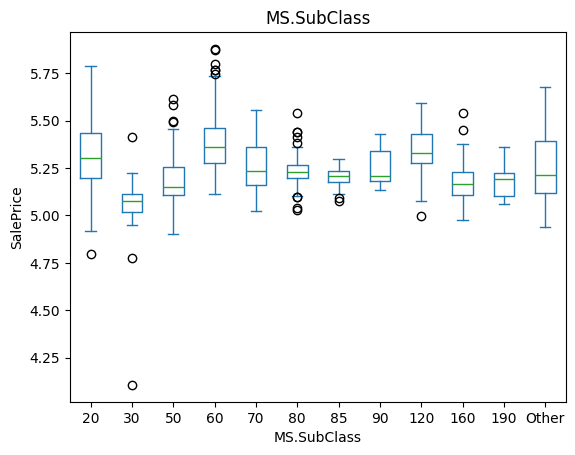

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


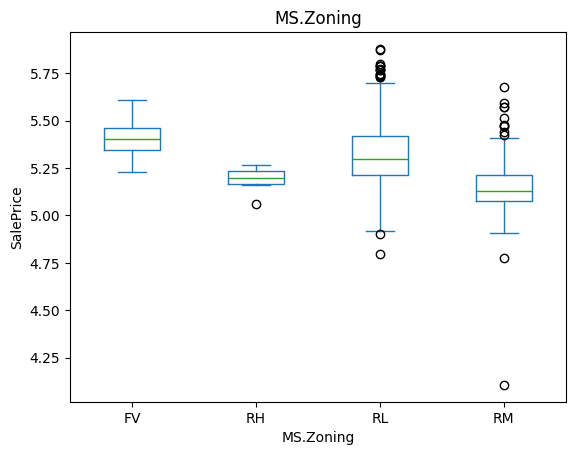

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


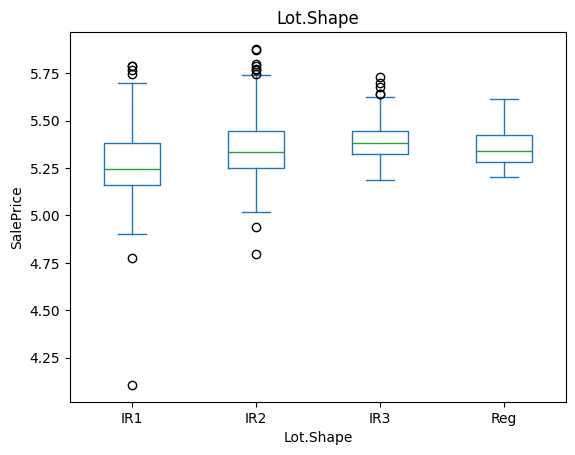

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


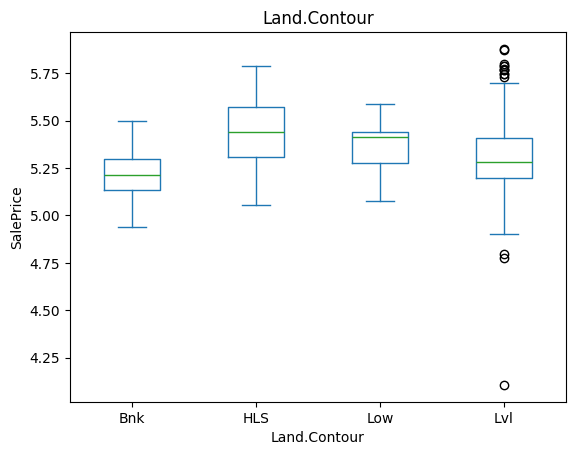

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


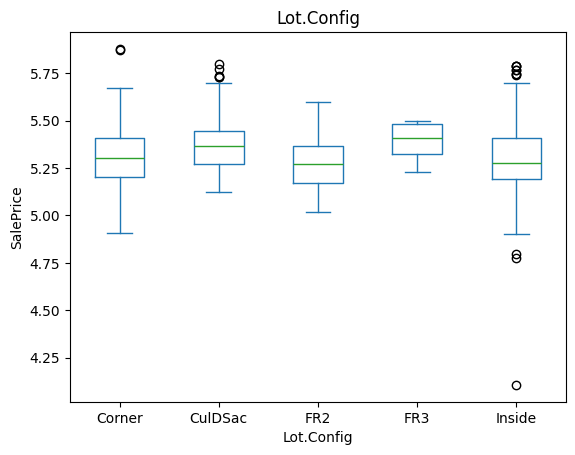

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


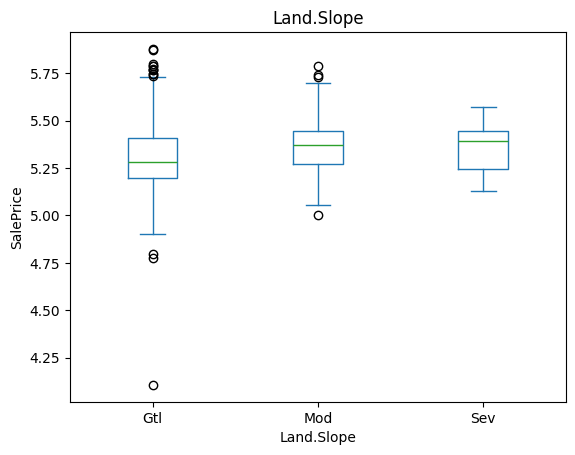

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


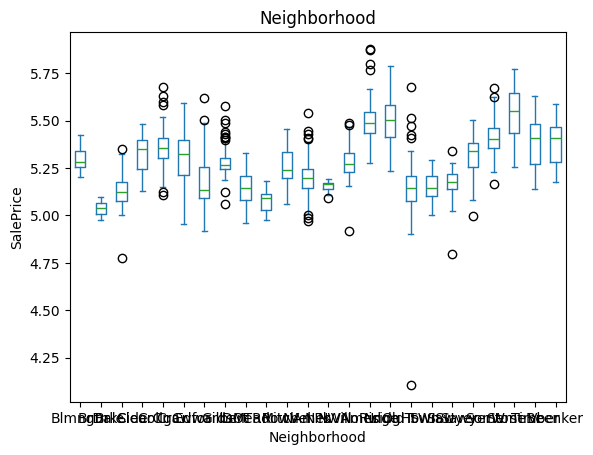

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


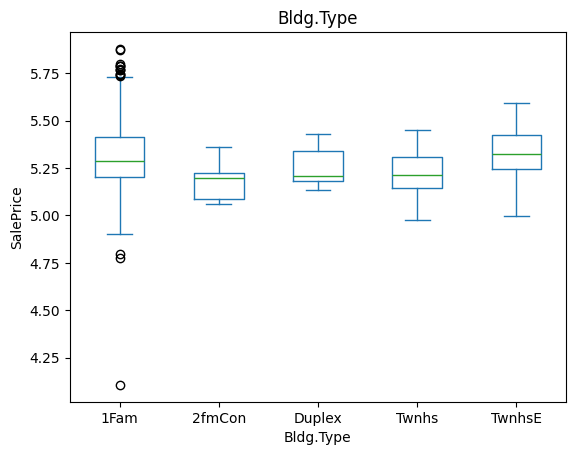

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


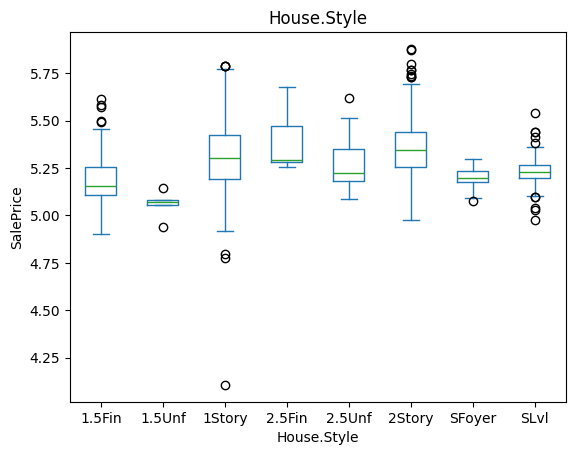

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


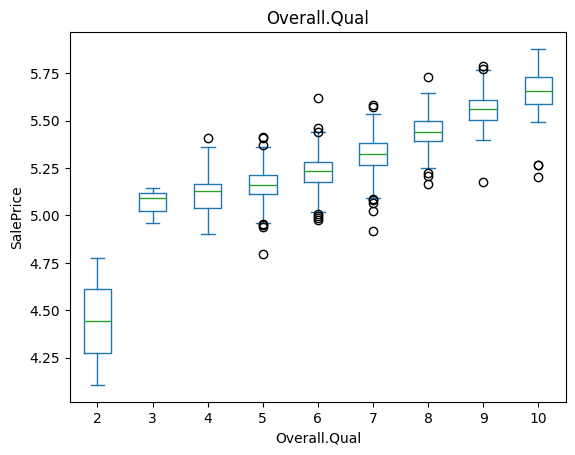

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


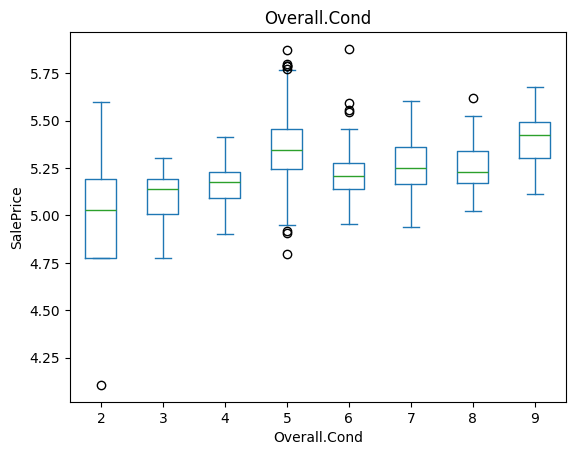

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


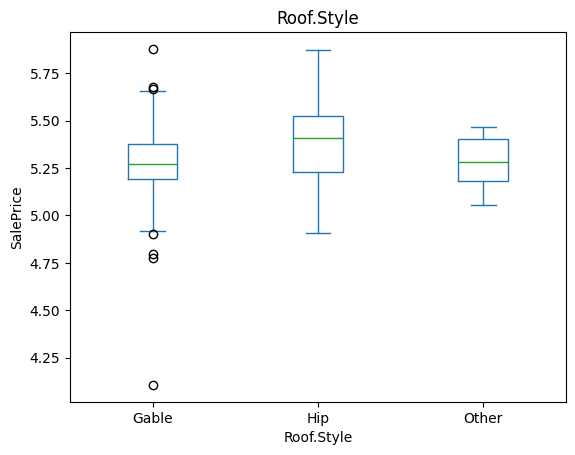

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


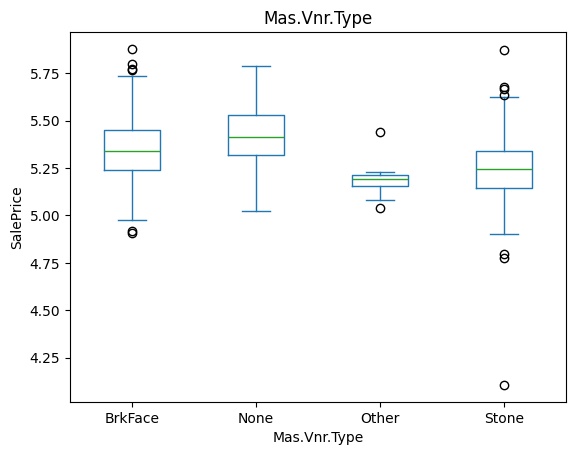

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


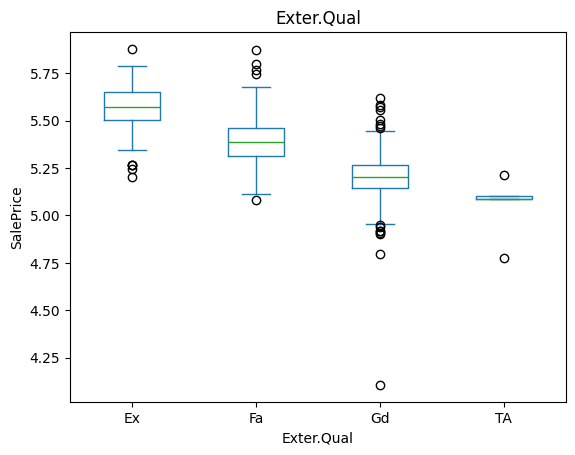

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


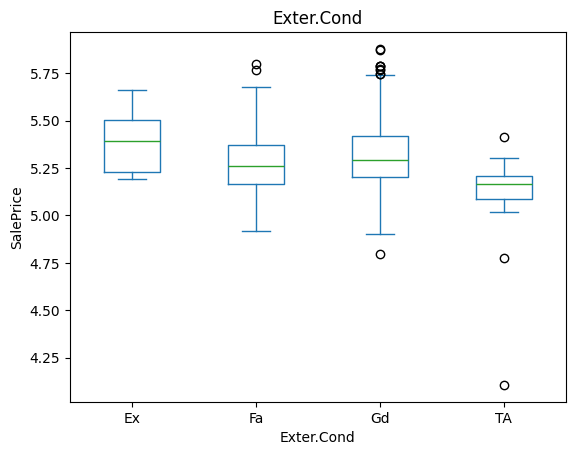

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


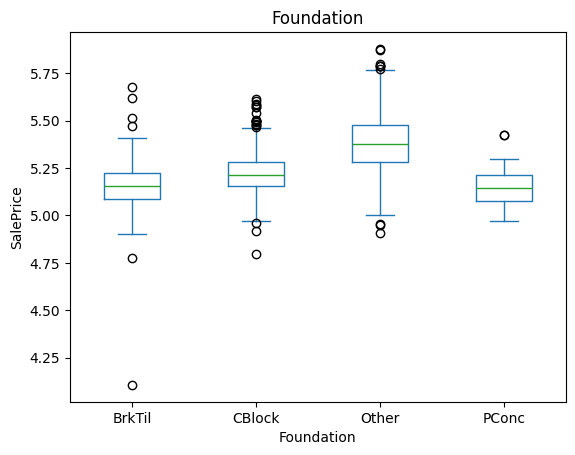

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


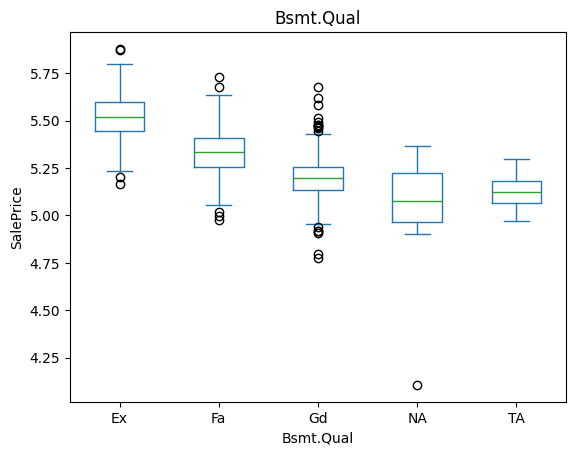

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


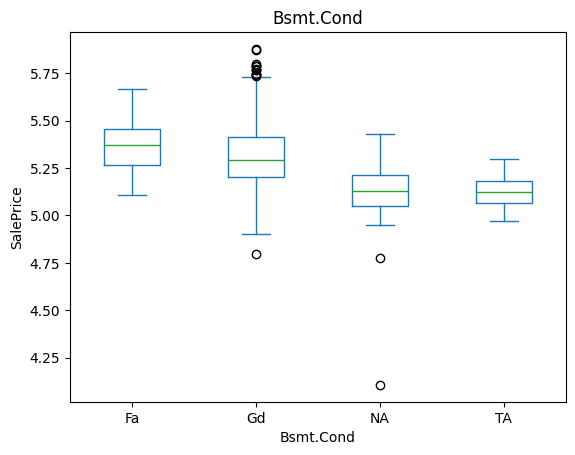

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


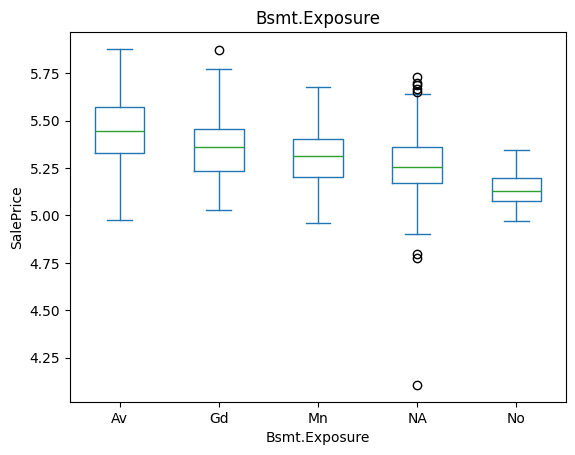

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


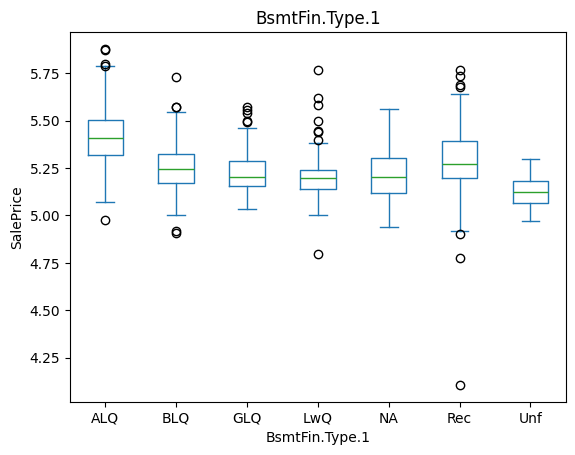

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


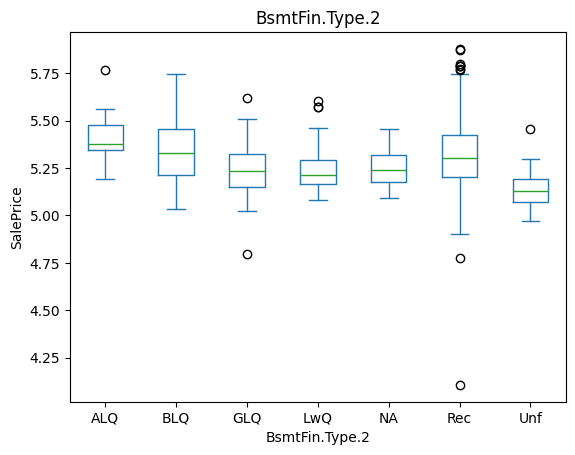

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


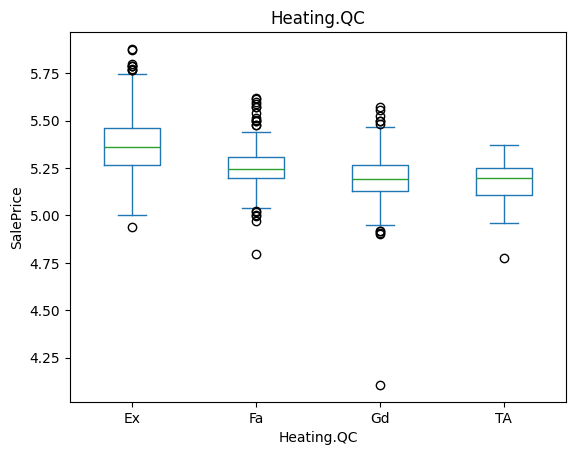

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


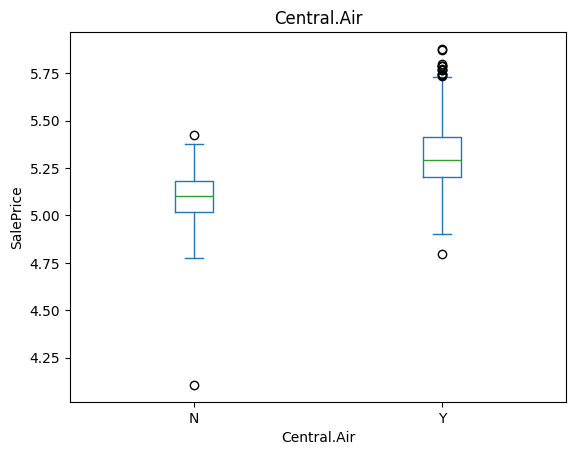

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


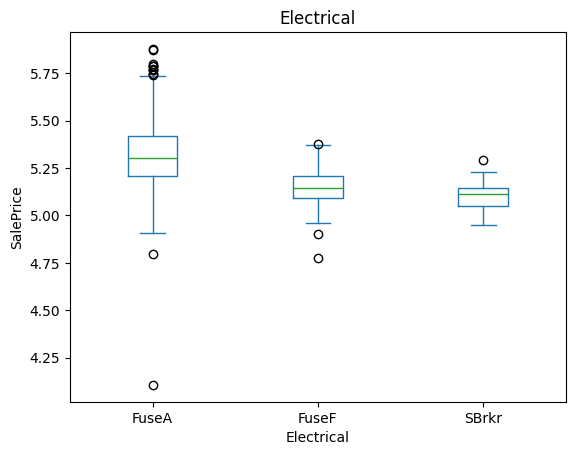

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


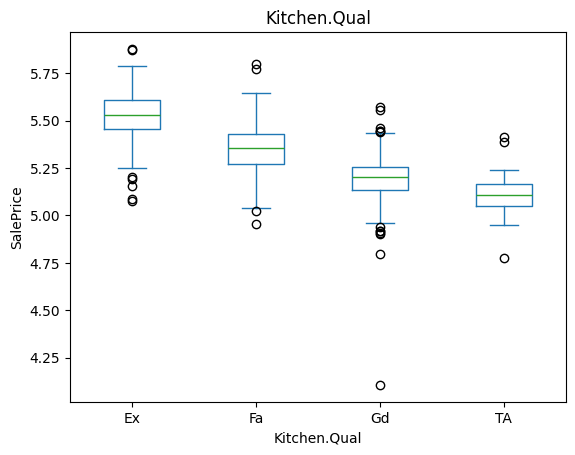

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


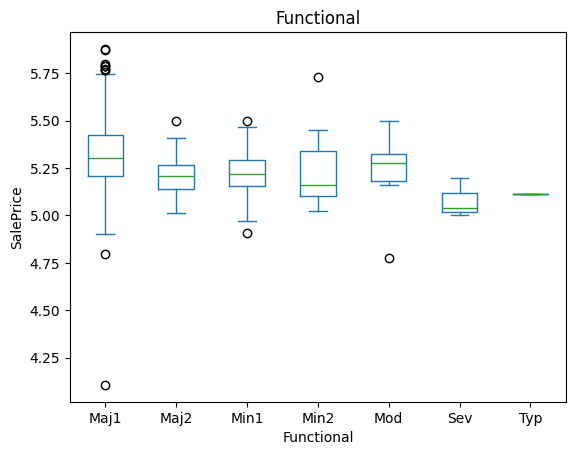

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


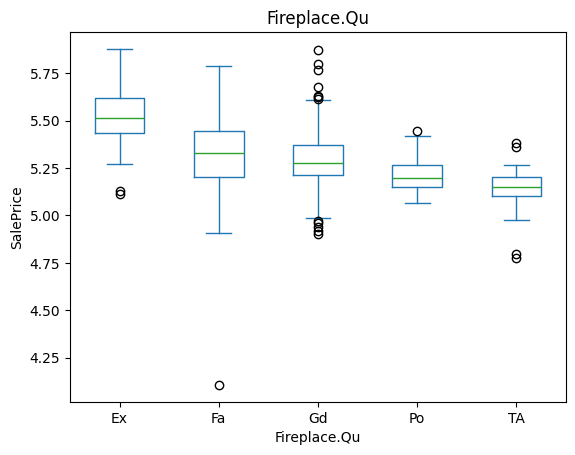

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


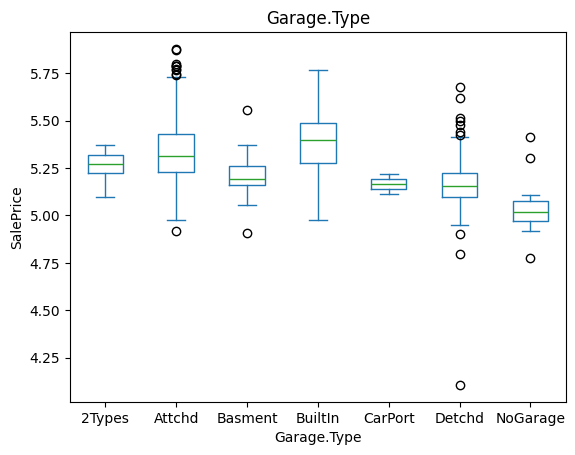

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


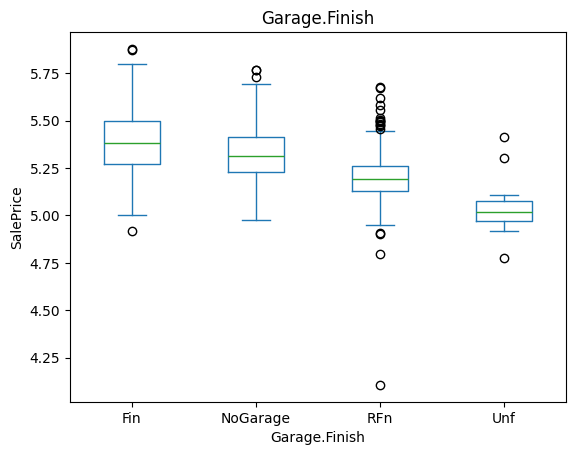

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


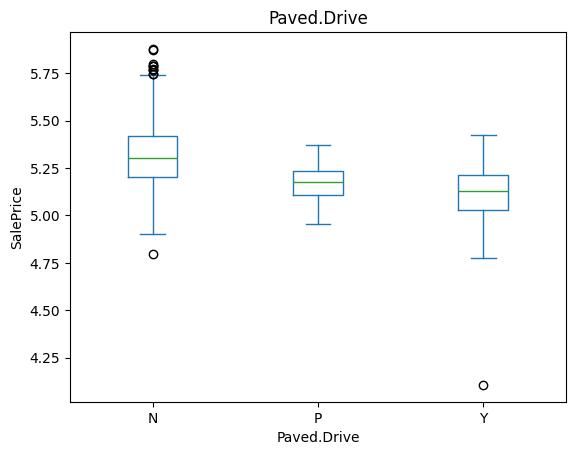

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


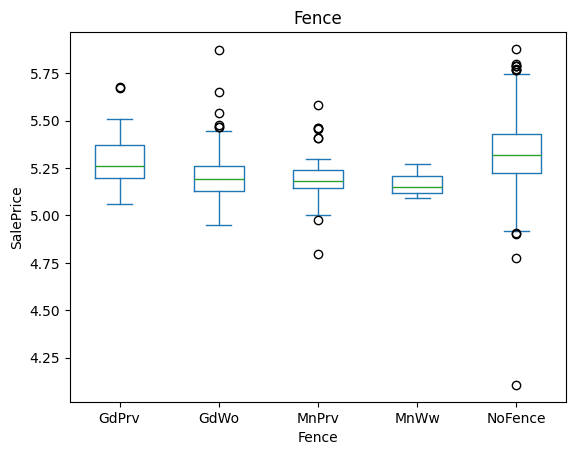

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


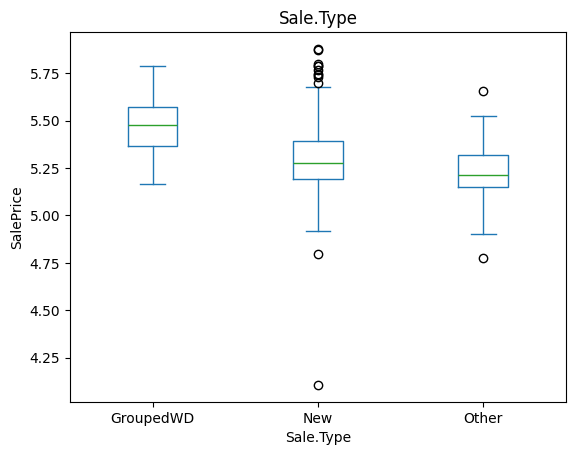

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


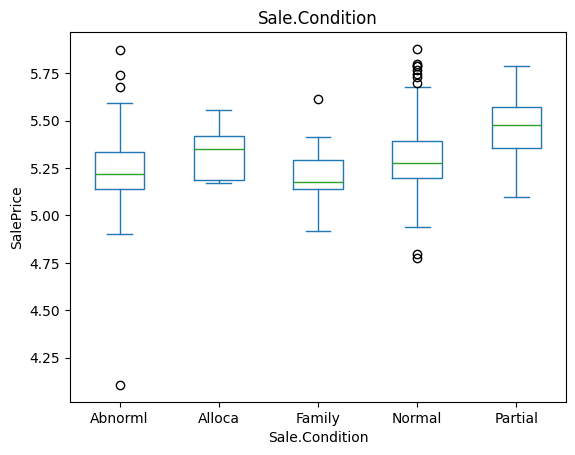

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


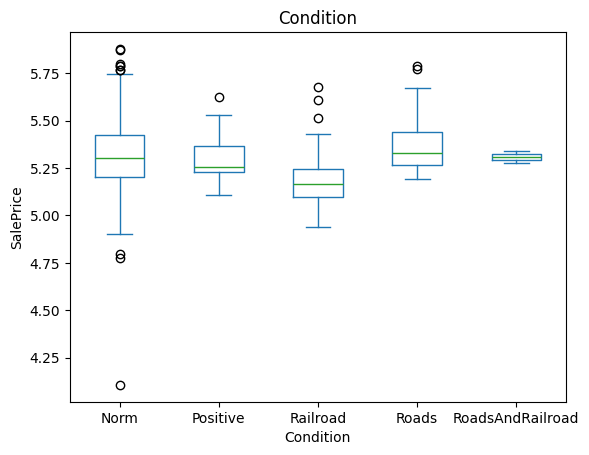

C:\Users\code\AppData\Local\Temp\ipykernel_27632\2153531921.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux_dataframe.plot.box(by=column)


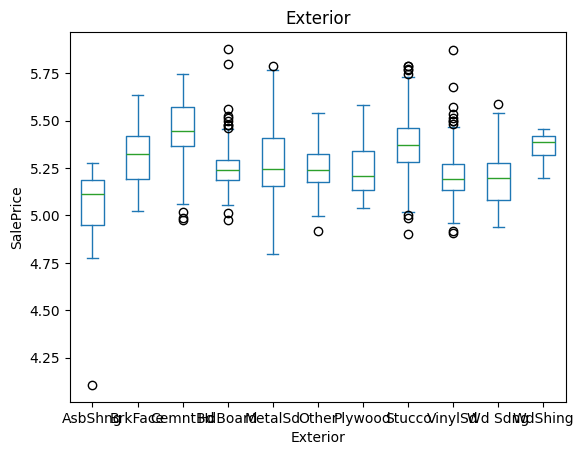

In [478]:
for column in categorical_columns:
    aux_dataframe = data[[column, 'SalePrice']]
    aux_dataframe.plot.box(by=column)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('SalePrice')
    plt.show()

Looks like there is no suspicious relationship between the target and the features, moving on:

### Feature versus feature

This topic is a bit more complicated. First of all, there is a quadratic number of relationships for feature-versus-feature comparisons here, so it is not feasible to really analyze them all. We will limit ourselves to the analysis of correlations between numerical variables for now:

In [479]:
corr = data.corr(numeric_only=True)
corr

Lot.Frontage  Lot.Area  Mas.Vnr.Area  BsmtFin.SF.1  \
Lot.Frontage         1.000000  0.267203      0.250670      0.209201   
Lot.Area             0.267203  1.000000      0.107355      0.183079   
Mas.Vnr.Area         0.250670  0.107355      1.000000      0.284751   
BsmtFin.SF.1         0.209201  0.183079      0.284751      1.000000   
BsmtFin.SF.2         0.038434  0.105969     -0.020524     -0.073424   
Bsmt.Unf.SF          0.044752 -0.016879      0.113766     -0.501847   
Total.Bsmt.SF        0.290147  0.228630      0.416946      0.596046   
X1st.Flr.SF          0.345524  0.264417      0.419518      0.522149   
X2nd.Flr.SF          0.066420  0.022251      0.069921     -0.208052   
Low.Qual.Fin.SF      0.018627  0.010685     -0.063535     -0.066567   
Gr.Liv.Area          0.342925  0.235655      0.398174      0.223876   
Bsmt.Full.Bath       0.120541  0.151545      0.135848      0.656283   
Bsmt.Half.Bath      -0.025584  0.017640      0.000873      0.083622   
Full.Bath            0.140332  0.077831      0.226922      0.066751   
Half.Bath            0.040515  0.006547      0.123534     -0.057112   
Bedroom.AbvGr        0.204921  0.095332      0.053738     -0.194428   
Kitchen.AbvGr       -0.055049 -0.017745     -0.058080     -0.010953   
TotRms.AbvGrd        0.299109  0.155992      0.266937      0.026147   
Fireplaces           0.122047  0.234055      0.070348      0.229269   
Garage.Cars          0.269228  0.122445      0.385698      0.262010   
Garage.Area          0.331621  0.166773      0.428199      0.348869   
Wood.Deck.SF         0.052291  0.120449      0.135991      0.197428   
Open.Porch.SF        0.169587  0.086802      0.129519      0.140853   
Enclosed.Porch       0.034732  0.032023     -0.105471     -0.079878   
X3Ssn.Porch         -0.002775  0.001000      0.015382      0.056711   
Screen.Porch         0.025654  0.020395      0.038396      0.082307   
Pool.Area            0.160353  0.069191     -0.009761      0.098267   
Misc.Val             0.046329  0.088176      0.090428      0.136028   
Mo.Sold              0.006400  0.007900     -0.025861     -0.009105   
Yr.Sold             -0.025958 -0.026545     -0.019585      0.054929   
SalePrice            0.290958  0.200904      0.460524      0.399875   
HasShed             -0.002004  0.126580     -0.037270     -0.026413   
HasAlley            -0.131854 -0.075714     -0.081739     -0.108019   
Garage.Age          -0.064593  0.046495     -0.262687     -0.196759   
Remod.Age           -0.096707  0.015110     -0.204192     -0.150910   
House.Age           -0.088548  0.029349     -0.299742     -0.244025   

                 BsmtFin.SF.2  Bsmt.Unf.SF  Total.Bsmt.SF  X1st.Flr.SF  \
Lot.Frontage         0.038434     0.044752       0.290147     0.345524   
Lot.Area             0.105969    -0.016879       0.228630     0.264417   
Mas.Vnr.Area        -0.020524     0.113766       0.416946     0.419518   
BsmtFin.SF.1        -0.073424    -0.501847       0.596046     0.522149   
BsmtFin.SF.2         1.000000    -0.231440       0.092063     0.112367   
Bsmt.Unf.SF         -0.231440     1.000000       0.314746     0.209042   
Total.Bsmt.SF        0.092063     0.314746       1.000000     0.824400   
X1st.Flr.SF          0.112367     0.209042       0.824400     1.000000   
X2nd.Flr.SF         -0.090078    -0.017690      -0.283286    -0.347614   
Low.Qual.Fin.SF     -0.004774     0.051470      -0.026116    -0.005913   
Gr.Liv.Area          0.007194     0.157803       0.402855     0.487451   
Bsmt.Full.Bath       0.138934    -0.436849       0.361840     0.296230   
Bsmt.Half.Bath       0.070212    -0.119116       0.005830     0.014691   
Full.Bath           -0.067474     0.222187       0.261118     0.257053   
Half.Bath           -0.049816    -0.066438      -0.146983    -0.200418   
Bedroom.AbvGr       -0.013796     0.092963      -0.131448    -0.088807   
Kitchen.AbvGr       -0.006326    -0.058295      -0.070759    -0.017531   
TotRms.AbvGrd       -0.030336     0.188669       0.198570

<Axes: >

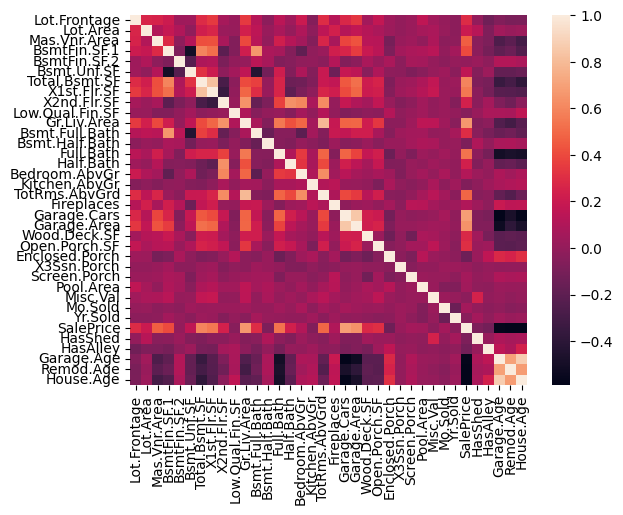

In [480]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Why look for high correlations? In some models, the presence of high correlations may prevent the good fitting of the data onto the model. This is the case for the simple linear model. For now it seems that there are no damaging correlations here.

In [486]:
#Juntar 2.5Unf, 1.5Unf e 2.5Fin em others 

data["House.Style"] = remap_categories(
    series=data["House.Style"],
    old_categories=[
    '2.5Unf',     
    '1.5Unf',      
    '2.5Fin' 
    ],
    new_category='Other',
)


data["House.Style"].value_counts().item


<bound method IndexOpsMixin.item of House.Style
1Story    694
2Story    529
1.5Fin    129
SLvl       84
SFoyer     26
Other      25
Name: count, dtype: int64>

In [488]:
data["Bldg.Type"] = remap_categories(
    series=data["Bldg.Type"],
    old_categories=[
       "Twnhs",
       "2fmCon",
       "Duplex"
    ],
    new_category='Others',
)


data["Bldg.Type"].value_counts().item

<bound method IndexOpsMixin.item of Bldg.Type
1Fam      1308
TwnhsE     132
Others      47
Name: count, dtype: int64>

In [490]:
data["Lot.Config"] = remap_categories(
    series=data["Lot.Config"],
    old_categories=[
       "FR2",
       "FR3",
    ],
    new_category='Others',
)
data["Lot.Config"].value_counts().item

<bound method IndexOpsMixin.item of Lot.Config
Inside     1058
Corner      258
CulDSac     125
Others       46
Name: count, dtype: int64>

In [491]:
data["Exter.Cond"] = remap_categories(
    series=data["Exter.Cond"],
    old_categories=[
       "Po",
       "Fa",
    ],
    new_category='Ruim',
)


data["Exter.Cond"] = remap_categories(
    series=data["Exter.Cond"],
    old_categories=[
       "Gd",
       "Ex",
    ],
    new_category='Bom',
)

data["Exter.Cond"] = remap_categories(
    series=data["Exter.Cond"],
    old_categories=[
       "TA",
    ],
    new_category='Normal',
)
data["Exter.Cond"].value_counts().item

<bound method IndexOpsMixin.item of Exter.Cond
Normal    1327
Bom        140
Ruim        20
Name: count, dtype: int64>

In [492]:
data["Exter.Qual"] = remap_categories(
    series=data["Exter.Qual"],
    old_categories=[
       "Po",
       "Fa",
    ],
    new_category='Ruim',
)


data["Exter.Qual"] = remap_categories(
    series=data["Exter.Qual"],
    old_categories=[
       "Gd",
       "Ex",
    ],
    new_category='Bom',
)

data["Exter.Qual"] = remap_categories(
    series=data["Exter.Qual"],
    old_categories=[
       "TA",
    ],
    new_category='Normal',
)
data["Exter.Qual"].value_counts().item

<bound method IndexOpsMixin.item of Exter.Qual
Bom       743
Normal    739
Ruim        5
Name: count, dtype: int64>

In [493]:
data["Bsmt.Cond"] = remap_categories(
    series=data["Bsmt.Cond"],
    old_categories=[
       "Po",
       "Fa",
    ],
    new_category='Ruim',
)


data["Bsmt.Cond"] = remap_categories(
    series=data["Bsmt.Cond"],
    old_categories=[
       "Gd",
       "Ex",
    ],
    new_category='Bom',
)

data["Bsmt.Cond"] = remap_categories(
    series=data["Bsmt.Cond"],
    old_categories=[
       "TA",
    ],
    new_category='Normal',
)
data["Bsmt.Cond"].value_counts().item

<bound method IndexOpsMixin.item of Bsmt.Cond
Normal    1352
Bom         78
Ruim        39
NA          18
Name: count, dtype: int64>

## Save the cleaned data

In [494]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

In [495]:
with open(clean_data_path, 'wb') as file:
    pickle.dump(data, file)